In [ ]:
# %load_ext pretty_jupyter

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
os.environ["WORLD_SIZE"] = "1"
import torch

torch.cuda.is_available()


import sys
from pathlib import Path
import scvi
import cellxgene_census
import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings
import faiss
sys.path.insert(0, "../")
import scgpt as scg


Global seed set to 0
/rwthfs/rz/cluster/home/an417130/Dokumente/GPM/analysis/scanpy_pipeline/annotation_test/.pixi/envs/default/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/rwthfs/rz/cluster/home/an417130/Dokumente/GPM/analysis/scanpy_pipeline/annotation_test/.pixi/envs/default/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/rwthfs/rz/cluster/home/an417130/Dokumente/GPM/analysis/scanpy_pipeline/annotation_test/.pixi/envs/default/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


# scGPT

In [2]:
torch.cuda.device_count()

1

In [3]:
model_dir = Path("../resources/scGPT_human")
adata = sc.read_h5ad("../save/marcelo_ref.h5ad")
cell_type_key = "scGPT_metainfo"
gene_col = "index"
adata.obs[cell_type_key] = 0

adata_sub = adata

In [4]:
adata_sub_embed = scg.tasks.embed_data(
    adata_sub,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=1024,
    return_new_adata=True,
)
adata_sub_emebd = adata_sub_embed.X

scGPT - INFO - match 20569/28892 genes in vocabulary of size 60697.


/rwthfs/rz/cluster/home/an417130/Dokumente/GPM/analysis/scanpy_pipeline/annotation_test/.pixi/envs/default/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 33/33 [01:00<00:00,  1.83s/it]
/rwthfs/rz/cluster/home/an417130/Dokumente/GPM/analysis/scanpy_pipeline/annotation_test/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
%%time

from build_atlas_index_faiss import load_index, vote

use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="../resources/CellXGene_faiss_index/",
    use_config_file=False,
    use_gpu=True,
)
print(f"Loaded index with {index.ntotal} cells")


k = 50
# test with the first 100 cells
distances, idx = index.search(adata_sub_emebd, k)

predict_labels = meta_labels[idx]
from scipy.stats import mode
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)


adata_sub.obs["scGPT"] = voting

Loading index and meta from ../resources/CellXGene_faiss_index/ ...
Index loaded, num_embeddings: 35096827
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 35096827 cells


100%|██████████| 33337/33337 [00:00<00:00, 63700.17it/s]

CPU times: user 1min 22s, sys: 4.43 s, total: 1min 27s
Wall time: 1min 41s


In [6]:
adata_sub.obs["manual_annotation"].value_counts()

manual_annotation
Stromal cells                         9841
Monocyte                              9349
Neutrophils                           3526
Mast cells (Immature)                 2640
Eosinophils (immature)                2273
Mast cells (activated?)               1681
Endothelial cells                      756
Eosinophils (mature)                   612
Granulocyte progenitors                601
Hemogenic endothelium/Stem cell        593
Megakaryocytes                         565
Hematopoietic progenitor/stem cell     519
Pericytes                              214
Astrocytes                             167
Name: count, dtype: int64

In [7]:
adata_sub.obs["scGPT"].value_counts()

scGPT
macrophage                             10468
mast cell                               7039
fibroblast of lung                      5648
classical monocyte                      2395
fibroblast                              2315
                                       ...  
skeletal muscle satellite cell             1
platelet                                   1
reticular cell                             1
migratory enteric neural crest cell        1
proerythroblast                            1
Name: count, Length: 90, dtype: int64

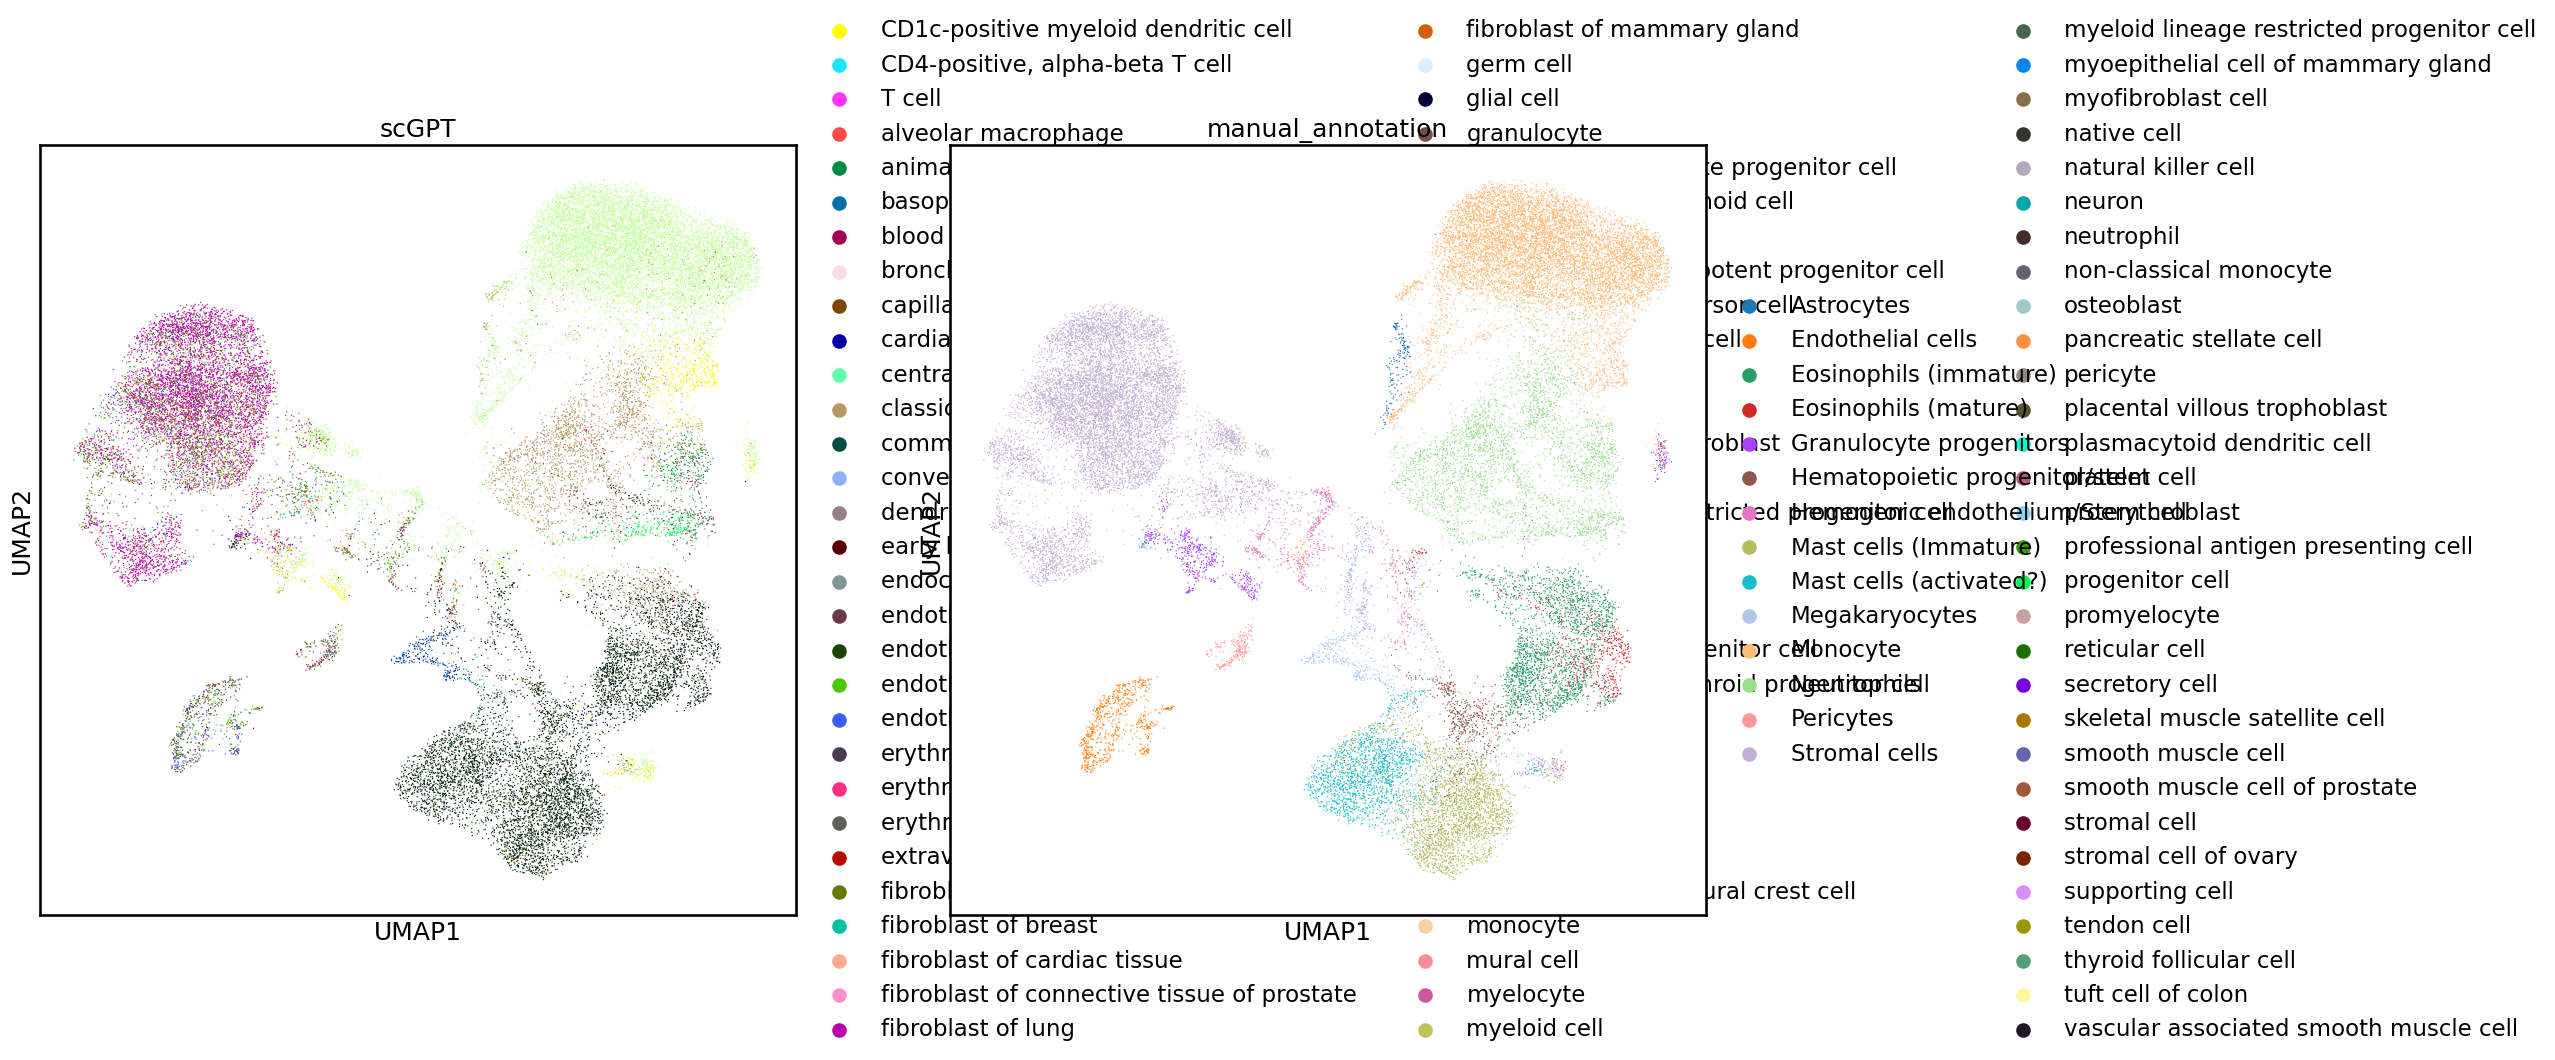

<Figure size 1000x1000 with 0 Axes>

In [8]:
from matplotlib import rc_context
import matplotlib.pyplot as plt
with rc_context({"figure.figsize": (10,10)}):
    sc.pl.umap(adata_sub, color=["scGPT", "manual_annotation"])
    plt.tight_layout()


In [ ]:
pd.crosstab(adata.obs["manual_annotation"][adata.obs["manual_annotation"].str.contains("Neutrophils")], adata.obs["scGPT"]).T

In [ ]:
adata.obs["manual_annotation"].value_counts()

# scVI + cellxgene

In [16]:
import cellxgene_census
import cellxgene_census.experimental


In [17]:
census_version = "2023-12-15"
organism = "homo_sapiens"

census = cellxgene_census.open_soma(census_version=census_version)

scvi_info = cellxgene_census.experimental.get_embedding_metadata_by_name(
    embedding_name="scvi",
    organism=organism,
    census_version=census_version,
)


In [20]:
import warnings

warnings.filterwarnings("ignore")

import anndata
import cellxgene_census
import numpy as np
import scanpy as sc
import scvi
from sklearn.ensemble import RandomForestClassifier


In [56]:
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/


2024-06-20 15:17:22 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


In [57]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")


In [62]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e
dataset_ids = [
    "fa8605cf-f27e-44af-ac2a-476bee4410d3",
    "3c75a463-6a87-4132-83a8-c3002624394d",
]

adata_census = cellxgene_census.get_anndata(
    census=census,
    measurement_name="RNA",
    organism="Homo sapiens",
    obs_value_filter=f"dataset_id in {dataset_ids}",
    obs_embeddings=["scvi"],
)
adata_census.var.set_index("feature_id", inplace=True)


In [67]:
adata_census.obsm["scvi"]

array([[-2.5390625e-02, -2.1839142e-04, -4.4140625e-01, ...,
        -1.1718750e+00, -2.9563904e-04,  1.1138916e-03],
       [-6.7187500e-01,  8.6975098e-04, -2.4902344e-01, ...,
        -1.8750000e+00,  1.4266968e-03,  2.5024414e-03],
       [ 1.9628906e-01, -2.5787354e-03, -1.7968750e-01, ...,
        -1.0546875e+00, -2.0904541e-03, -4.6691895e-03],
       ...,
       [ 1.0234375e+00, -2.5482178e-03, -7.3046875e-01, ...,
        -4.9218750e-01, -6.6528320e-03,  6.0319901e-05],
       [-5.7031250e-01,  2.7465820e-03,  2.0629883e-02, ...,
        -4.0429688e-01,  4.9743652e-03, -3.6926270e-03],
       [-3.2031250e-01, -6.0119629e-03, -1.1796875e+00, ...,
        -9.0234375e-01,  1.7929077e-03, -4.0283203e-03]], dtype=float32)

In [63]:
adata.obs["dataset_id"] = "QUERY"
# Subset the reference dataset to have a similar number of cells to the query dataset
index_subset = np.random.choice(adata_census.n_obs, size=3000, replace=False)
adata_census_subset = adata_census[index_subset, :]


ValueError: Did not find scvi in `.obsm.keys()`. You need to compute it first.

In [ ]:

adata_combined = anndata.concat([adata_census_subset, adata])
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep="scvi", metric="correlation")
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color=["dataset_id"])


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(adata_census.obsm["scvi"], adata_census.obs["cell_type"].values)
adata.obs["predicted_cell_type"] = rfc.predict(adata.obsm["scvi"])

# let's get confidence scores
probabilities = rfc.predict_proba(adata.obsm["scvi"])
confidence = np.zeros(adata.n_obs)
for i in range(adata.n_obs):
    confidence[i] = probabilities[i][rfc.classes_ == adata.obs["predicted_cell_type"][i]]


INFO     File ../resources/scvi.model_homo_sapiens/model.pt already downloaded                                     


KeyError: "Values ['ENSG00000233576', 'ENSG00000234667', 'ENSG00000214141', 'ENSG00000248574', 'ENSG00000260089', 'ENSG00000248144', 'ENSG00000273540', 'ENSG00000241532', 'ENSG00000228816', 'ENSG00000255838', 'ENSG00000223621', 'ENSG00000214992', 'ENSG00000250794', 'ENSG00000219249', 'ENSG00000272031', 'ENSG00000230006', 'ENSG00000216740', 'ENSG00000243478', 'ENSG00000270560', 'ENSG00000255700', 'ENSG00000248122', 'ENSG00000254351', 'ENSG00000230418', 'ENSG00000236818', 'ENSG00000255014', 'ENSG00000267333', 'ENSG00000220517', 'ENSG00000217791', 'ENSG00000214342', 'ENSG00000214003', 'ENSG00000227590', 'ENSG00000224948', 'ENSG00000261102', 'ENSG00000242561', 'ENSG00000253502', 'ENSG00000230948', 'ENSG00000187172', 'ENSG00000278910', 'ENSG00000282851', 'ENSG00000281406', 'ENSG00000236323', 'ENSG00000231099', 'ENSG00000272779', 'ENSG00000270270', 'ENSG00000268174', 'ENSG00000268438', 'ENSG00000265631', 'ENSG00000269662', 'ENSG00000269431', 'ENSG00000266575', 'ENSG00000125997', 'ENSG00000271209', 'ENSG00000235334', 'ENSG00000167798', 'ENSG00000260133', 'ENSG00000227742', 'ENSG00000232004', 'ENSG00000259151', 'ENSG00000227835', 'ENSG00000214321', 'ENSG00000254496', 'ENSG00000276085', 'ENSG00000214998', 'ENSG00000249616', 'ENSG00000224473', 'ENSG00000251433', 'ENSG00000250526', 'ENSG00000234585', 'ENSG00000232610', 'ENSG00000204936', 'ENSG00000272398', 'ENSG00000219738', 'ENSG00000226020', 'ENSG00000233681', 'ENSG00000236123', 'ENSG00000231561', 'ENSG00000224109', 'ENSG00000226937', 'ENSG00000224786', 'ENSG00000235084', 'ENSG00000186940', 'ENSG00000259156', 'ENSG00000225270', 'ENSG00000258788', 'ENSG00000227069', 'ENSG00000232185', 'ENSG00000259100', 'ENSG00000260318', 'ENSG00000236764', 'ENSG00000235957', 'ENSG00000280837', 'ENSG00000214076', 'ENSG00000250293', 'ENSG00000232254', 'ENSG00000271449', 'ENSG00000269096', 'ENSG00000278085', 'ENSG00000249026', 'ENSG00000236417', 'ENSG00000231009', 'ENSG00000229754', 'ENSG00000232901', 'ENSG00000255379', 'ENSG00000223625', 'ENSG00000229120', 'ENSG00000233548', 'ENSG00000227735', 'ENSG00000240194', 'ENSG00000256612', 'ENSG00000237180', 'ENSG00000273330', 'ENSG00000241095', 'ENSG00000233588', 'ENSG00000218748', 'ENSG00000272886', 'ENSG00000233614', 'ENSG00000230986', 'ENSG00000215378', 'ENSG00000179611', 'ENSG00000226758', 'ENSG00000261645', 'ENSG00000237195', 'ENSG00000228045', 'ENSG00000224071', 'ENSG00000271464', 'ENSG00000223722', 'ENSG00000216439', 'ENSG00000270552', 'ENSG00000282757', 'ENSG00000261771', 'ENSG00000223822', 'ENSG00000249963', 'ENSG00000237757', 'ENSG00000261557', 'ENSG00000196205', 'ENSG00000234785', 'ENSG00000234125', 'ENSG00000248998', 'ENSG00000206120', 'ENSG00000280739', 'ENSG00000229704', 'ENSG00000233300', 'ENSG00000226388', 'ENSG00000231752', 'ENSG00000250476', 'ENSG00000233347', 'ENSG00000269763', 'ENSG00000241735', 'ENSG00000213716', 'ENSG00000231584', 'ENSG00000230562', 'ENSG00000227248', 'ENSG00000251106', 'ENSG00000278763', 'ENSG00000218772', 'ENSG00000223839', 'ENSG00000235297', 'ENSG00000237806', 'ENSG00000224763', 'ENSG00000251463', 'ENSG00000276399', 'ENSG00000215834', 'ENSG00000214295', 'ENSG00000261711', 'ENSG00000223361', 'ENSG00000218213', 'ENSG00000242992', 'ENSG00000232187', 'ENSG00000228347', 'ENSG00000226608', 'ENSG00000266989', 'ENSG00000213594', 'ENSG00000250982', 'ENSG00000239207', 'ENSG00000248626', 'ENSG00000277172', 'ENSG00000250130', 'ENSG00000228312', 'ENSG00000226769', 'ENSG00000236167', 'ENSG00000231072', 'ENSG00000223460', 'ENSG00000213376', 'ENSG00000270878', 'ENSG00000233994', 'ENSG00000223772', 'ENSG00000197421', 'ENSG00000265107', 'ENSG00000178723', 'ENSG00000255749', 'ENSG00000251215', 'ENSG00000277494', 'ENSG00000266242', 'ENSG00000257569', 'ENSG00000251254', 'ENSG00000277053', 'ENSG00000228315', 'ENSG00000254781', 'ENSG00000224860', 'ENSG00000231095', 'ENSG00000206159', 'ENSG00000277745', 'ENSG00000269466', 'ENSG00000235655', 'ENSG00000232087', 'ENSG00000258978', 'ENSG00000253952', 'ENSG00000237148', 'ENSG00000231531', 'ENSG00000274997', 'ENSG00000276368', 'ENSG00000278677', 'ENSG00000287080', 'ENSG00000273983', 'ENSG00000274618', 'ENSG00000270276', 'ENSG00000229391', 'ENSG00000218194', 'ENSG00000216753', 'ENSG00000251566', 'ENSG00000243873', 'ENSG00000243877', 'ENSG00000254146', 'ENSG00000132967', 'ENSG00000229992', 'ENSG00000259318', 'ENSG00000230326', 'ENSG00000239614', 'ENSG00000214578', 'ENSG00000229367', 'ENSG00000260602', 'ENSG00000179362', 'ENSG00000228611', 'ENSG00000218347', 'ENSG00000214223', 'ENSG00000228168', 'ENSG00000249920', 'ENSG00000227688', 'ENSG00000263179', 'ENSG00000220305', 'ENSG00000251557', 'ENSG00000259335', 'ENSG00000255047', 'ENSG00000187481', 'ENSG00000183199', 'ENSG00000259706', 'ENSG00000225217', 'ENSG00000215357', 'ENSG00000228036', 'ENSG00000249768', 'ENSG00000183935', 'ENSG00000285219', 'ENSG00000251563', 'ENSG00000231195', 'ENSG00000226597', 'ENSG00000270505', 'ENSG00000259337', 'ENSG00000271288', 'ENSG00000188403', 'ENSG00000261704', 'ENSG00000277282', 'ENSG00000270467', 'ENSG00000271178', 'ENSG00000270864', 'ENSG00000271620', 'ENSG00000271130', 'ENSG00000283906', 'ENSG00000211979', 'ENSG00000283195', 'ENSG00000211592', 'ENSG00000211597', 'ENSG00000211596', 'ENSG00000211595', 'ENSG00000211594', 'ENSG00000211593', 'ENSG00000278857', 'ENSG00000276566', 'ENSG00000241244', 'ENSG00000242766', 'ENSG00000224607', 'ENSG00000239975', 'ENSG00000250036', 'ENSG00000251546', 'ENSG00000211633', 'ENSG00000242580', 'ENSG00000156755', 'ENSG00000253481', 'ENSG00000204780', 'ENSG00000254220', 'ENSG00000241566', 'ENSG00000211623', 'ENSG00000242534', 'ENSG00000243264', 'ENSG00000239571', 'ENSG00000251039', 'ENSG00000253460', 'ENSG00000253691', 'ENSG00000211632', 'ENSG00000224041', 'ENSG00000211625', 'ENSG00000211598', 'ENSG00000225523', 'ENSG00000211626', 'ENSG00000211675', 'ENSG00000211677', 'ENSG00000211679', 'ENSG00000254029', 'ENSG00000222037', 'ENSG00000211685', 'ENSG00000211674', 'ENSG00000211676', 'ENSG00000211678', 'ENSG00000211684', 'ENSG00000211648', 'ENSG00000211645', 'ENSG00000211644', 'ENSG00000211642', 'ENSG00000211668', 'ENSG00000211666', 'ENSG00000211664', 'ENSG00000211660', 'ENSG00000253451', 'ENSG00000253234', 'ENSG00000278196', 'ENSG00000211673', 'ENSG00000211669', 'ENSG00000211667', 'ENSG00000253590', 'ENSG00000211665', 'ENSG00000253152', 'ENSG00000211663', 'ENSG00000253963', 'ENSG00000211662', 'ENSG00000211661', 'ENSG00000253822', 'ENSG00000211659', 'ENSG00000253913', 'ENSG00000211658', 'ENSG00000253448', 'ENSG00000254077', 'ENSG00000211670', 'ENSG00000211672', 'ENSG00000211639', 'ENSG00000211637', 'ENSG00000211647', 'ENSG00000211643', 'ENSG00000211640', 'ENSG00000211649', 'ENSG00000211638', 'ENSG00000223350', 'ENSG00000253126', 'ENSG00000253752', 'ENSG00000253239', 'ENSG00000257720', 'ENSG00000230589', 'ENSG00000283154', 'ENSG00000251347', 'ENSG00000259405', 'ENSG00000266853', 'ENSG00000231491', 'ENSG00000233603', 'ENSG00000232558', 'ENSG00000135253', 'ENSG00000225014', 'ENSG00000248216', 'ENSG00000260726', 'ENSG00000224344', 'ENSG00000237672', 'ENSG00000226145', 'ENSG00000231645', 'ENSG00000186082', 'ENSG00000215149', 'ENSG00000240128', 'ENSG00000249438', 'ENSG00000254831', 'ENSG00000258948', 'ENSG00000229320', 'ENSG00000233579', 'ENSG00000258828', 'ENSG00000242841', 'ENSG00000214930', 'ENSG00000274749', 'ENSG00000228825', 'ENSG00000232021', 'ENSG00000226869', 'ENSG00000280798', 'ENSG00000226722', 'ENSG00000258791', 'ENSG00000281664', 'ENSG00000278811', 'ENSG00000167459', 'ENSG00000280734', 'ENSG00000204272', 'ENSG00000280719', 'ENSG00000271601', 'ENSG00000246582', 'ENSG00000260014', 'ENSG00000259823', 'ENSG00000269153', 'ENSG00000242520', 'ENSG00000234456', 'ENSG00000267647', 'ENSG00000277443', 'ENSG00000242062', 'ENSG00000242600', 'ENSG00000220884', 'ENSG00000260220', 'ENSG00000225358', 'ENSG00000224783', 'ENSG00000255248', 'ENSG00000283320', 'ENSG00000207744', 'ENSG00000221533', 'ENSG00000221603', 'ENSG00000221656', 'ENSG00000284378', 'ENSG00000208008', 'ENSG00000207971', 'ENSG00000199161', 'ENSG00000221634', 'ENSG00000221463', 'ENSG00000221680', 'ENSG00000221763', 'ENSG00000221287', 'ENSG00000221604', 'ENSG00000221269', 'ENSG00000207649', 'ENSG00000265154', 'ENSG00000222831', 'ENSG00000207978', 'ENSG00000215417', 'ENSG00000207605', 'ENSG00000207614', 'ENSG00000208024', 'ENSG00000252466', 'ENSG00000267195', 'ENSG00000252695', 'ENSG00000284336', 'ENSG00000207749', 'ENSG00000207927', 'ENSG00000199102', 'ENSG00000263793', 'ENSG00000264720', 'ENSG00000264725', 'ENSG00000264354', 'ENSG00000265333', 'ENSG00000264678', 'ENSG00000265725', 'ENSG00000266712', 'ENSG00000263628', 'ENSG00000263436', 'ENSG00000264226', 'ENSG00000284399', 'ENSG00000264395', 'ENSG00000265306', 'ENSG00000171889', 'ENSG00000211491', 'ENSG00000211513', 'ENSG00000280870', 'ENSG00000207761', 'ENSG00000207762', 'ENSG00000199051', 'ENSG00000265635', 'ENSG00000264901', 'ENSG00000266151', 'ENSG00000275708', 'ENSG00000281156', 'ENSG00000266782', 'ENSG00000264139', 'ENSG00000263813', 'ENSG00000266617', 'ENSG00000284568', 'ENSG00000199015', 'ENSG00000283829', 'ENSG00000199127', 'ENSG00000264249', 'ENSG00000263894', 'ENSG00000265102', 'ENSG00000264069', 'ENSG00000283514', 'ENSG00000265584', 'ENSG00000199109', 'ENSG00000283296', 'ENSG00000265321', 'ENSG00000265806', 'ENSG00000265432', 'ENSG00000272458', 'ENSG00000266104', 'ENSG00000266417', 'ENSG00000283795', 'ENSG00000264010', 'ENSG00000283204', 'ENSG00000263828', 'ENSG00000265253', 'ENSG00000264585', 'ENSG00000266515', 'ENSG00000283792', 'ENSG00000263670', 'ENSG00000284000', 'ENSG00000266760', 'ENSG00000263790', 'ENSG00000266852', 'ENSG00000283813', 'ENSG00000199132', 'ENSG00000263643', 'ENSG00000266305', 'ENSG00000265612', 'ENSG00000264922', 'ENSG00000266415', 'ENSG00000263734', 'ENSG00000264494', 'ENSG00000263575', 'ENSG00000284118', 'ENSG00000264210', 'ENSG00000264049', 'ENSG00000266640', 'ENSG00000266594', 'ENSG00000264268', 'ENSG00000264684', 'ENSG00000264623', 'ENSG00000264099', 'ENSG00000283736', 'ENSG00000202609', 'ENSG00000263909', 'ENSG00000284407', 'ENSG00000264796', 'ENSG00000207800', 'ENSG00000266307', 'ENSG00000283490', 'ENSG00000266146', 'ENSG00000264653', 'ENSG00000207981', 'ENSG00000207784', 'ENSG00000207587', 'ENSG00000264419', 'ENSG00000265829', 'ENSG00000265653', 'ENSG00000212036', 'ENSG00000221214', 'ENSG00000221594', 'ENSG00000221782', 'ENSG00000221348', 'ENSG00000221369', 'ENSG00000221669', 'ENSG00000221510', 'ENSG00000275453', 'ENSG00000221263', 'ENSG00000221331', 'ENSG00000265520', 'ENSG00000263581', 'ENSG00000263945', 'ENSG00000212024', 'ENSG00000207750', 'ENSG00000207974', 'ENSG00000266570', 'ENSG00000263675', 'ENSG00000263540', 'ENSG00000264614', 'ENSG00000264621', 'ENSG00000207626', 'ENSG00000265135', 'ENSG00000264084', 'ENSG00000266318', 'ENSG00000264857', 'ENSG00000263511', 'ENSG00000207988', 'ENSG00000207756', 'ENSG00000207632', 'ENSG00000207930', 'ENSG00000207976', 'ENSG00000284005', 'ENSG00000275373', 'ENSG00000207983', 'ENSG00000207967', 'ENSG00000207766', 'ENSG00000284343', 'ENSG00000207972', 'ENSG00000207802', 'ENSG00000284049', 'ENSG00000278418', 'ENSG00000284311', 'ENSG00000277057', 'ENSG00000274988', 'ENSG00000275967', 'ENSG00000207703', 'ENSG00000211579', 'ENSG00000284570', 'ENSG00000277255', 'ENSG00000276221', 'ENSG00000277387', 'ENSG00000273882', 'ENSG00000276765', 'ENSG00000216191', 'ENSG00000216009', 'ENSG00000216192', 'ENSG00000207757', 'ENSG00000216058', 'ENSG00000207807', 'ENSG00000198975', 'ENSG00000199030', 'ENSG00000199072', 'ENSG00000262406', 'ENSG00000255040', 'ENSG00000260314', 'ENSG00000257480', 'ENSG00000234587', 'ENSG00000235299', 'ENSG00000254305', 'ENSG00000259186', 'ENSG00000226013', 'ENSG00000226395', 'ENSG00000243406', 'ENSG00000263639', 'ENSG00000260549', 'ENSG00000213761', 'ENSG00000231831', 'ENSG00000264697', 'ENSG00000228166', 'ENSG00000227225', 'ENSG00000251449', 'ENSG00000251407', 'ENSG00000225972', 'ENSG00000254346', 'ENSG00000263914', 'ENSG00000225630', 'ENSG00000230302', 'ENSG00000251353', 'ENSG00000242214', 'ENSG00000247627', 'ENSG00000236254', 'ENSG00000227584', 'ENSG00000250169', 'ENSG00000230225', 'ENSG00000236626', 'ENSG00000238256', 'ENSG00000232447', 'ENSG00000233039', 'ENSG00000229163', 'ENSG00000224816', 'ENSG00000131401', 'ENSG00000253937', 'ENSG00000223875', 'ENSG00000205449', 'ENSG00000215864', 'ENSG00000234523', 'ENSG00000277586', 'ENSG00000270754', 'ENSG00000230757', 'ENSG00000167984', 'ENSG00000231504', 'ENSG00000259573', 'ENSG00000188599', 'ENSG00000223864', 'ENSG00000229417', 'ENSG00000240804', 'ENSG00000239351', 'ENSG00000232054', 'ENSG00000225159', 'ENSG00000259259', 'ENSG00000197085', 'ENSG00000226933', 'ENSG00000223705', 'ENSG00000177144', 'ENSG00000271121', 'ENSG00000198284', 'ENSG00000248916', 'ENSG00000235823', 'ENSG00000268221', 'ENSG00000227423', 'ENSG00000255538', 'ENSG00000224709', 'ENSG00000236083', 'ENSG00000273423', 'ENSG00000237225', 'ENSG00000262085', 'ENSG00000273234', 'ENSG00000254475', 'ENSG00000228307', 'ENSG00000197067', 'ENSG00000254663', 'ENSG00000230484', 'ENSG00000225003', 'ENSG00000188691', 'ENSG00000255083', 'ENSG00000181282', 'ENSG00000180714', 'ENSG00000255431', 'ENSG00000233499', 'ENSG00000255303', 'ENSG00000254848', 'ENSG00000249975', 'ENSG00000279395', 'ENSG00000254613', 'ENSG00000230576', 'ENSG00000269552', 'ENSG00000235623', 'ENSG00000182531', 'ENSG00000189398', 'ENSG00000205897', 'ENSG00000197882', 'ENSG00000184669', 'ENSG00000180926', 'ENSG00000179799', 'ENSG00000228547', 'ENSG00000255203', 'ENSG00000250640', 'ENSG00000188668', 'ENSG00000255030', 'ENSG00000284723', 'ENSG00000186508', 'ENSG00000186124', 'ENSG00000276045', 'ENSG00000243775', 'ENSG00000234315', 'ENSG00000264522', 'ENSG00000263405', 'ENSG00000230457', 'ENSG00000228595', 'ENSG00000281880', 'ENSG00000235701', 'ENSG00000276545', 'ENSG00000270772', 'ENSG00000180867', 'ENSG00000261371', 'ENSG00000271077', 'ENSG00000249834', 'ENSG00000248913', 'ENSG00000230251', 'ENSG00000244730', 'ENSG00000213713', 'ENSG00000235892', 'ENSG00000215057', 'ENSG00000280109', 'ENSG00000228600', 'ENSG00000258284', 'ENSG00000232647', 'ENSG00000272391', 'ENSG00000224124', 'ENSG00000229266', 'ENSG00000248365', 'ENSG00000244196', 'ENSG00000234363', 'ENSG00000258477', 'ENSG00000220541', 'ENSG00000213082', 'ENSG00000255255', 'ENSG00000231989', 'ENSG00000102055', 'ENSG00000213177', 'ENSG00000248987', 'ENSG00000259592', 'ENSG00000227972', 'ENSG00000248320', 'ENSG00000259205', 'ENSG00000226847', 'ENSG00000232314', 'ENSG00000259078', 'ENSG00000275450', 'ENSG00000237514', 'ENSG00000213005', 'ENSG00000258571', 'ENSG00000227613', 'ENSG00000216817', 'ENSG00000276600', 'ENSG00000266520', 'ENSG00000214283', 'ENSG00000214405', 'ENSG00000214561', 'ENSG00000230399', 'ENSG00000271488', 'ENSG00000277769', 'ENSG00000265203', 'ENSG00000215477', 'ENSG00000204787', 'ENSG00000236158', 'ENSG00000248720', 'ENSG00000266613', 'ENSG00000234123', 'ENSG00000255794', 'ENSG00000283293', 'ENSG00000223341', 'ENSG00000263740', 'ENSG00000265735', 'ENSG00000222832', 'ENSG00000201962', 'ENSG00000252745', 'ENSG00000199839', 'ENSG00000252002', 'ENSG00000201736', 'ENSG00000252451', 'ENSG00000222054', 'ENSG00000207129', 'ENSG00000201532', 'ENSG00000222308', 'ENSG00000222248', 'ENSG00000222383', 'ENSG00000212176', 'ENSG00000202263', 'ENSG00000201939', 'ENSG00000251978', 'ENSG00000222747', 'ENSG00000222955', 'ENSG00000222920', 'ENSG00000222459', 'ENSG00000199638', 'ENSG00000212396', 'ENSG00000199364', 'ENSG00000202147', 'ENSG00000222578', 'ENSG00000252364', 'ENSG00000252747', 'ENSG00000223046', 'ENSG00000222302', 'ENSG00000251756', 'ENSG00000223177', 'ENSG00000202193', 'ENSG00000252456', 'ENSG00000253058', 'ENSG00000223138', 'ENSG00000199373', 'ENSG00000212536', 'ENSG00000199509', 'ENSG00000201728', 'ENSG00000238627', 'ENSG00000252950', 'ENSG00000200985', 'ENSG00000212542', 'ENSG00000201620', 'ENSG00000212601', 'ENSG00000252650', 'ENSG00000201492', 'ENSG00000201610', 'ENSG00000231381', 'ENSG00000233333', 'ENSG00000202347', 'ENSG00000200795', 'ENSG00000200156', 'ENSG00000199906', 'ENSG00000252574', 'ENSG00000251722', 'ENSG00000199849', 'ENSG00000207449', 'ENSG00000206712', 'ENSG00000199226', 'ENSG00000200840', 'ENSG00000207298', 'ENSG00000210181', 'ENSG00000252222', 'ENSG00000251712', 'ENSG00000238446', 'ENSG00000252206', 'ENSG00000238830', 'ENSG00000251981', 'ENSG00000238417', 'ENSG00000252750', 'ENSG00000253054', 'ENSG00000238778', 'ENSG00000238884', 'ENSG00000238782', 'ENSG00000207325', 'ENSG00000206617', 'ENSG00000202124', 'ENSG00000255547', 'ENSG00000269609', 'ENSG00000250732', 'ENSG00000188873', 'ENSG00000230853', 'ENSG00000233913', 'ENSG00000216412', 'ENSG00000235330', 'ENSG00000242941', 'ENSG00000228754', 'ENSG00000234498', 'ENSG00000236552', 'ENSG00000213885', 'ENSG00000215030', 'ENSG00000243402', 'ENSG00000233045', 'ENSG00000216917', 'ENSG00000233445', 'ENSG00000234742', 'ENSG00000241809', 'ENSG00000236058', 'ENSG00000231211', 'ENSG00000213700', 'ENSG00000226084', 'ENSG00000213307', 'ENSG00000240870', 'ENSG00000240827', 'ENSG00000232429', 'ENSG00000242747', 'ENSG00000219133', 'ENSG00000229554', 'ENSG00000220749', 'ENSG00000232037', 'ENSG00000216718', 'ENSG00000224593', 'ENSG00000237551', 'ENSG00000213178', 'ENSG00000234851', 'ENSG00000243265', 'ENSG00000244229', 'ENSG00000225912', 'ENSG00000229659', 'ENSG00000229423', 'ENSG00000224993', 'ENSG00000244712', 'ENSG00000230202', 'ENSG00000230169', 'ENSG00000232430', 'ENSG00000241281', 'ENSG00000239261', 'ENSG00000213657', 'ENSG00000225352', 'ENSG00000235328', 'ENSG00000251474', 'ENSG00000239524', 'ENSG00000240534', 'ENSG00000244267', 'ENSG00000264217', 'ENSG00000230350', 'ENSG00000244018', 'ENSG00000233747', 'ENSG00000240426', 'ENSG00000243280', 'ENSG00000214759', 'ENSG00000242080', 'ENSG00000244398', 'ENSG00000240298', 'ENSG00000228007', 'ENSG00000234270', 'ENSG00000225846', 'ENSG00000176343', 'ENSG00000233702', 'ENSG00000229235', 'ENSG00000228601', 'ENSG00000227470', 'ENSG00000232573', 'ENSG00000220744', 'ENSG00000243521', 'ENSG00000213051', 'ENSG00000230383', 'ENSG00000243160', 'ENSG00000231562', 'ENSG00000184961', 'ENSG00000213272', 'ENSG00000231035', 'ENSG00000229917', 'ENSG00000224315', 'ENSG00000137970', 'ENSG00000213169', 'ENSG00000244640', 'ENSG00000232881', 'ENSG00000232888', 'ENSG00000225193', 'ENSG00000232713', 'ENSG00000228929', 'ENSG00000241511', 'ENSG00000233762', 'ENSG00000229806', 'ENSG00000230897', 'ENSG00000242299', 'ENSG00000220848', 'ENSG00000214612', 'ENSG00000240463', 'ENSG00000228462', 'ENSG00000218198', 'ENSG00000241907', 'ENSG00000242358', 'ENSG00000243504', 'ENSG00000244099', 'ENSG00000240992', 'ENSG00000241641', 'ENSG00000230629', 'ENSG00000239438', 'ENSG00000240974', 'ENSG00000224631', 'ENSG00000242640', 'ENSG00000227852', 'ENSG00000232069', 'ENSG00000213399', 'ENSG00000196183', 'ENSG00000235508', 'ENSG00000234995', 'ENSG00000234031', 'ENSG00000242060', 'ENSG00000178429', 'ENSG00000228205', 'ENSG00000244217', 'ENSG00000226948', 'ENSG00000239830', 'ENSG00000225381', 'ENSG00000237730', 'ENSG00000213269', 'ENSG00000237549', 'ENSG00000215278', 'ENSG00000227437', 'ENSG00000237433', 'ENSG00000229648', 'ENSG00000230384', 'ENSG00000242952', 'ENSG00000226765', 'ENSG00000216471', 'ENSG00000240590', 'ENSG00000227721', 'ENSG00000259046', 'ENSG00000236484', 'ENSG00000103472', 'ENSG00000255071', 'ENSG00000262480', 'ENSG00000225665', 'ENSG00000228956', 'ENSG00000239002', 'ENSG00000238835', 'ENSG00000252906', 'ENSG00000226705', 'ENSG00000256704', 'ENSG00000250416', 'ENSG00000281501', 'ENSG00000241007', 'ENSG00000230275', 'ENSG00000206072', 'ENSG00000241319', 'ENSG00000223707', 'ENSG00000280693', 'ENSG00000268849', 'ENSG00000231234', 'ENSG00000273872', 'ENSG00000215347', 'ENSG00000213673', 'ENSG00000238286', 'ENSG00000268104', 'ENSG00000260727', 'ENSG00000238125', 'ENSG00000248228', 'ENSG00000253816', 'ENSG00000267384', 'ENSG00000185710', 'ENSG00000174365', 'ENSG00000221475', 'ENSG00000206910', 'ENSG00000206612', 'ENSG00000207016', 'ENSG00000207493', 'ENSG00000206650', 'ENSG00000200792', 'ENSG00000212384', 'ENSG00000200215', 'ENSG00000200367', 'ENSG00000200608', 'ENSG00000201247', 'ENSG00000199593', 'ENSG00000201557', 'ENSG00000272344', 'ENSG00000200612', 'ENSG00000201689', 'ENSG00000201839', 'ENSG00000201318', 'ENSG00000200089', 'ENSG00000201263', 'ENSG00000199453', 'ENSG00000200757', 'ENSG00000199712', 'ENSG00000201331', 'ENSG00000199489', 'ENSG00000206609', 'ENSG00000207137', 'ENSG00000207279', 'ENSG00000207014', 'ENSG00000239112', 'ENSG00000200879', 'ENSG00000252128', 'ENSG00000238649', 'ENSG00000201487', 'ENSG00000200913', 'ENSG00000207444', 'ENSG00000200084', 'ENSG00000223224', 'ENSG00000200785', 'ENSG00000221241', 'ENSG00000208883', 'ENSG00000283551', 'ENSG00000238001', 'ENSG00000230106', 'ENSG00000234999', 'ENSG00000250580', 'ENSG00000235763', 'ENSG00000230965', 'ENSG00000236610', 'ENSG00000242808', 'ENSG00000225530', 'ENSG00000227543', 'ENSG00000277215', 'ENSG00000228319', 'ENSG00000230246', 'ENSG00000260928', 'ENSG00000262655', 'ENSG00000229035', 'ENSG00000266129', 'ENSG00000265182', 'ENSG00000266201', 'ENSG00000185319', 'ENSG00000213368', 'ENSG00000204685', 'ENSG00000241721', 'ENSG00000253721', 'ENSG00000157152', 'ENSG00000237449', 'ENSG00000213871', 'ENSG00000224686', 'ENSG00000271278', 'ENSG00000234167', 'ENSG00000217566', 'ENSG00000241438', 'ENSG00000224324', 'ENSG00000269556', 'ENSG00000226287', 'ENSG00000182796', 'ENSG00000233197', 'ENSG00000253866', 'ENSG00000250026', 'ENSG00000228499', 'ENSG00000187653', 'ENSG00000285665', 'ENSG00000234562', 'ENSG00000197253', 'ENSG00000217027', 'ENSG00000274391', 'ENSG00000215506', 'ENSG00000277734', 'ENSG00000226557', 'ENSG00000211871', 'ENSG00000211857', 'ENSG00000211845', 'ENSG00000211844', 'ENSG00000211839', 'ENSG00000211881', 'ENSG00000255569', 'ENSG00000211784', 'ENSG00000211785', 'ENSG00000211794', 'ENSG00000211788', 'ENSG00000211791', 'ENSG00000211792', 'ENSG00000211796', 'ENSG00000211797', 'ENSG00000211776', 'ENSG00000211800', 'ENSG00000211801', 'ENSG00000211802', 'ENSG00000211803', 'ENSG00000211806', 'ENSG00000211807', 'ENSG00000211812', 'ENSG00000211809', 'ENSG00000211777', 'ENSG00000259092', 'ENSG00000211813', 'ENSG00000211814', 'ENSG00000211816', 'ENSG00000211817', 'ENSG00000211818', 'ENSG00000211778', 'ENSG00000211819', 'ENSG00000211820', 'ENSG00000211779', 'ENSG00000211780', 'ENSG00000211782', 'ENSG00000211786', 'ENSG00000211790', 'ENSG00000211795', 'ENSG00000211783', 'ENSG00000211793', 'ENSG00000211829', 'ENSG00000228985', 'ENSG00000211826', 'ENSG00000211804', 'ENSG00000211821', 'ENSG00000256590', 'ENSG00000211687', 'ENSG00000233306', 'ENSG00000211698', 'ENSG00000228668', 'ENSG00000227830', 'ENSG00000210154', 'ENSG00000210176', 'ENSG00000209082', 'ENSG00000210151', 'ENSG00000182048', 'ENSG00000204815', 'ENSG00000221971', 'ENSG00000243910', 'ENSG00000220418', 'ENSG00000217372', 'ENSG00000220586', 'ENSG00000265972', 'ENSG00000243498', 'ENSG00000228074', 'ENSG00000265939', 'ENSG00000250384', 'ENSG00000225558', 'ENSG00000266282', 'ENSG00000214049', 'ENSG00000276043', 'ENSG00000260818', 'ENSG00000273820', 'ENSG00000215037', 'ENSG00000242856', 'ENSG00000220581', 'ENSG00000230361', 'ENSG00000232109', 'ENSG00000237185', 'ENSG00000174677', 'ENSG00000268598', 'ENSG00000269320', 'ENSG00000230086', 'ENSG00000213014', 'ENSG00000240375', 'ENSG00000213434', 'ENSG00000227759', 'ENSG00000202515', 'ENSG00000224257', 'ENSG00000260389', 'ENSG00000261040', 'ENSG00000214185', 'ENSG00000253517', 'ENSG00000220494', 'ENSG00000251108', 'ENSG00000251389', 'ENSG00000146839', 'ENSG00000237426', 'ENSG00000258917', 'ENSG00000225192', 'ENSG00000151963', 'ENSG00000267419', 'ENSG00000219392', 'ENSG00000235278', 'ENSG00000018607', 'ENSG00000232522', 'ENSG00000159904', 'ENSG00000248958', 'ENSG00000196912', 'ENSG00000118412', 'ENSG00000275385', 'ENSG00000274736', 'ENSG00000277632', 'ENSG00000275302', 'ENSG00000276070', 'ENSG00000271503', 'ENSG00000278535', 'ENSG00000206195', 'ENSG00000279516', 'ENSG00000275395', 'ENSG00000130600', 'ENSG00000235257', 'ENSG00000273706', 'ENSG00000006062', 'ENSG00000278845', 'ENSG00000276747', 'ENSG00000274512', 'ENSG00000280236', 'ENSG00000230002', 'ENSG00000272196', 'ENSG00000279685', 'ENSG00000275718', 'ENSG00000285077', 'ENSG00000286237', 'ENSG00000170468', 'ENSG00000263961', 'ENSG00000276409', 'ENSG00000227684', 'ENSG00000229150', 'ENSG00000234124', 'ENSG00000223629', 'ENSG00000264743', 'ENSG00000172900', 'ENSG00000232938', 'ENSG00000234975', 'ENSG00000236056', 'ENSG00000249948', 'ENSG00000204136', 'ENSG00000196301', 'ENSG00000235821', 'ENSG00000211895', 'ENSG00000211890', 'ENSG00000211898', 'ENSG00000211917', 'ENSG00000211911', 'ENSG00000211891', 'ENSG00000253692', 'ENSG00000211896', 'ENSG00000211893', 'ENSG00000211892', 'ENSG00000253755', 'ENSG00000211905', 'ENSG00000211904', 'ENSG00000242887', 'ENSG00000240041', 'ENSG00000242472', 'ENSG00000211900', 'ENSG00000254174', 'ENSG00000253709', 'ENSG00000254046', 'ENSG00000211945', 'ENSG00000211934', 'ENSG00000211950', 'ENSG00000211935', 'ENSG00000211961', 'ENSG00000211962', 'ENSG00000211968', 'ENSG00000253274', 'ENSG00000253703', 'ENSG00000211973', 'ENSG00000211951', 'ENSG00000211937', 'ENSG00000274576', 'ENSG00000211941', 'ENSG00000211942', 'ENSG00000211943', 'ENSG00000211944', 'ENSG00000253883', 'ENSG00000211946', 'ENSG00000211947', 'ENSG00000253957', 'ENSG00000211949', 'ENSG00000253441', 'ENSG00000270550', 'ENSG00000211955', 'ENSG00000211957', 'ENSG00000253359', 'ENSG00000211958', 'ENSG00000278473', 'ENSG00000254228', 'ENSG00000232216', 'ENSG00000229092', 'ENSG00000211964', 'ENSG00000211965', 'ENSG00000253545', 'ENSG00000211967', 'ENSG00000253763', 'ENSG00000253742', 'ENSG00000253132', 'ENSG00000223648', 'ENSG00000253209', 'ENSG00000211972', 'ENSG00000211938', 'ENSG00000254056', 'ENSG00000225698', 'ENSG00000211976', 'ENSG00000224650', 'ENSG00000211952', 'ENSG00000231475', 'ENSG00000211956', 'ENSG00000211959', 'ENSG00000276775', 'ENSG00000254395', 'ENSG00000224373', 'ENSG00000211970', 'ENSG00000211966', 'ENSG00000211978', 'ENSG00000211933', 'ENSG00000254326', 'ENSG00000253325', 'ENSG00000253467', 'ENSG00000253131', 'ENSG00000254215', 'ENSG00000253780', 'ENSG00000253989', 'ENSG00000243290', 'ENSG00000253497', 'ENSG00000240864', 'ENSG00000240382', 'ENSG00000244575', 'ENSG00000242076', 'ENSG00000239862', 'ENSG00000242371', 'ENSG00000243466', 'ENSG00000239855', 'ENSG00000240671', 'ENSG00000241755', 'ENSG00000239819', 'ENSG00000253278', 'ENSG00000253265', 'ENSG00000254157', 'ENSG00000241294', 'ENSG00000254098', 'ENSG00000244116', 'ENSG00000253998', 'ENSG00000243238', 'ENSG00000253435', 'ENSG00000273962', 'ENSG00000241351', 'ENSG00000244437', 'ENSG00000239951', 'ENSG00000253202', 'ENSG00000243063', 'ENSG00000211599', 'ENSG00000211611', 'ENSG00000197794', 'ENSG00000211655', 'ENSG00000211653', 'ENSG00000253818', 'ENSG00000211651', 'ENSG00000211656', 'ENSG00000253120', 'ENSG00000211657', 'ENSG00000211654', 'ENSG00000211650', 'ENSG00000253631', 'ENSG00000211652', 'ENSG00000253889', 'ENSG00000214856', 'ENSG00000225438', 'ENSG00000119440', 'ENSG00000204031', 'ENSG00000233369', 'ENSG00000238168', 'ENSG00000225755', 'ENSG00000258611', 'ENSG00000218986', 'ENSG00000270506', 'ENSG00000256041', 'ENSG00000235901', 'ENSG00000248376', 'ENSG00000260680', 'ENSG00000250827', 'ENSG00000235239', 'ENSG00000233880', 'ENSG00000182888', 'ENSG00000180152', 'ENSG00000253555', 'ENSG00000232915', 'ENSG00000239835', 'ENSG00000237708', 'ENSG00000284690', 'ENSG00000203363', 'ENSG00000274775', 'ENSG00000255358', 'ENSG00000196085', 'ENSG00000271686', 'ENSG00000238026', 'ENSG00000263818', 'ENSG00000229663', 'ENSG00000236832', 'ENSG00000243584', 'ENSG00000282419', 'ENSG00000233671', 'ENSG00000251014', 'ENSG00000283390', 'ENSG00000255361', 'ENSG00000250684', 'ENSG00000270225', 'ENSG00000265279', 'ENSG00000270390', 'ENSG00000224656', 'ENSG00000233688', 'ENSG00000227134', 'ENSG00000242001', 'ENSG00000227267', 'ENSG00000215720', 'ENSG00000251163', 'ENSG00000271356', 'ENSG00000231395', 'ENSG00000238065', 'ENSG00000215120', 'ENSG00000270268', 'ENSG00000233585', 'ENSG00000236241', 'ENSG00000233716', 'ENSG00000244062', 'ENSG00000226066', 'ENSG00000271235', 'ENSG00000250980', 'ENSG00000242103', 'ENSG00000225715', 'ENSG00000261593', 'ENSG00000232218', 'ENSG00000236655', 'ENSG00000232392', 'ENSG00000271639', 'ENSG00000270528', 'ENSG00000224584', 'ENSG00000284693', 'ENSG00000261777', 'ENSG00000276255', 'ENSG00000225183', 'ENSG00000225154', 'ENSG00000238145', 'ENSG00000251643', 'ENSG00000283324', 'ENSG00000235332', 'ENSG00000286646', 'ENSG00000277496', 'ENSG00000285051', 'ENSG00000250546', 'ENSG00000217643', 'ENSG00000241418', 'ENSG00000277112', 'ENSG00000267453', 'ENSG00000260799', 'ENSG00000264920', 'ENSG00000275418', 'ENSG00000251002', 'ENSG00000277639', 'ENSG00000283755', 'ENSG00000283503', 'ENSG00000277527', 'ENSG00000238755', 'ENSG00000230927', 'ENSG00000285744', 'ENSG00000232369', 'ENSG00000264515', 'ENSG00000286785', 'ENSG00000254541', 'ENSG00000257885', 'ENSG00000225196', 'ENSG00000240912', 'ENSG00000249620', 'ENSG00000225271', 'ENSG00000213706', 'ENSG00000258357', 'ENSG00000205035', 'ENSG00000232456', 'ENSG00000254529', 'ENSG00000230832', 'ENSG00000260341', 'ENSG00000285972', 'ENSG00000256779', 'ENSG00000235218', 'ENSG00000175509', 'ENSG00000236182', 'ENSG00000188383', 'ENSG00000249934', 'ENSG00000179978', 'ENSG00000258932', 'ENSG00000235012', 'ENSG00000215270', 'ENSG00000235963', 'ENSG00000266206', 'ENSG00000284010', 'ENSG00000211583', 'ENSG00000228782', 'ENSG00000231199', 'ENSG00000204872', 'ENSG00000235547', 'ENSG00000197171', 'ENSG00000273377', 'ENSG00000236853', 'ENSG00000176290', 'ENSG00000237354', 'ENSG00000255134', 'ENSG00000239293', 'ENSG00000233892', 'ENSG00000236278', 'ENSG00000266200', 'ENSG00000268295', 'ENSG00000283453', 'ENSG00000275896', 'ENSG00000250591', 'ENSG00000211459', 'ENSG00000210082', 'ENSG00000200376', 'ENSG00000241067', 'ENSG00000218300', 'ENSG00000224796', 'ENSG00000243095', 'ENSG00000213900', 'ENSG00000229795', 'ENSG00000279730', 'ENSG00000238344', 'ENSG00000201264', 'ENSG00000259479', 'ENSG00000260174', 'ENSG00000211751', 'ENSG00000211772', 'ENSG00000211717', 'ENSG00000229769', 'ENSG00000275791', 'ENSG00000211720', 'ENSG00000276597', 'ENSG00000244661', 'ENSG00000211739', 'ENSG00000274752', 'ENSG00000276953', 'ENSG00000275158', 'ENSG00000276405', 'ENSG00000275743', 'ENSG00000276819', 'ENSG00000275243', 'ENSG00000276557', 'ENSG00000211746', 'ENSG00000226660', 'ENSG00000211747', 'ENSG00000251578', 'ENSG00000211749', 'ENSG00000211750', 'ENSG00000282499', 'ENSG00000211752', 'ENSG00000211753', 'ENSG00000232869', 'ENSG00000237254', 'ENSG00000211710', 'ENSG00000211745', 'ENSG00000211734', 'ENSG00000230099', 'ENSG00000211725', 'ENSG00000211728', 'ENSG00000211731', 'ENSG00000211706', 'ENSG00000211713', 'ENSG00000211721', 'ENSG00000211724', 'ENSG00000253188', 'ENSG00000253534', 'ENSG00000282939', 'ENSG00000211714', 'ENSG00000211727', 'ENSG00000253291', 'ENSG00000278030', 'ENSG00000211716', 'ENSG00000214391', 'ENSG00000251297', 'ENSG00000276380', 'ENSG00000197617', 'ENSG00000269345', 'ENSG00000284616', 'ENSG00000284678', 'ENSG00000283445', 'ENSG00000285407', 'ENSG00000282057', 'ENSG00000276674', 'ENSG00000276216', 'ENSG00000276110', 'ENSG00000285280', 'ENSG00000233999', 'ENSG00000235235', 'ENSG00000270748', 'ENSG00000204670', 'ENSG00000271569', 'ENSG00000278766', 'ENSG00000280878', 'ENSG00000231292', 'ENSG00000283849', 'ENSG00000279658', 'ENSG00000285336', 'ENSG00000283175', 'ENSG00000285042', 'ENSG00000285151', 'ENSG00000285204', 'ENSG00000285424', 'ENSG00000285278', 'ENSG00000283064', 'ENSG00000284656', 'ENSG00000277797', 'ENSG00000278899', 'ENSG00000285492', 'ENSG00000284914', 'ENSG00000280707', 'ENSG00000278254', 'ENSG00000285412', 'ENSG00000285162', 'ENSG00000284839', 'ENSG00000285480', 'ENSG00000284377', 'ENSG00000280195', 'ENSG00000283992', 'ENSG00000283329', 'ENSG00000276502', 'ENSG00000275649', 'ENSG00000277412', 'ENSG00000204776', 'ENSG00000276348', 'ENSG00000276898', 'ENSG00000283205', 'ENSG00000284977', 'ENSG00000280758', 'ENSG00000283787', 'ENSG00000283375', 'ENSG00000285231', 'ENSG00000274251', 'ENSG00000260679', 'ENSG00000284844', 'ENSG00000260008', 'ENSG00000285513', 'ENSG00000278376', 'ENSG00000229206', 'ENSG00000237592', 'ENSG00000273760', 'ENSG00000282121', 'ENSG00000283096', 'ENSG00000280485', 'ENSG00000282772', 'ENSG00000275024', 'ENSG00000282787', 'ENSG00000283141', 'ENSG00000275005', 'ENSG00000283095', 'ENSG00000278255', 'ENSG00000276718', 'ENSG00000275703', 'ENSG00000282080', 'ENSG00000276417', 'ENSG00000275197', 'ENSG00000278743', 'ENSG00000276261', 'ENSG00000275286', 'ENSG00000276691', 'ENSG00000275228', 'ENSG00000273890', 'ENSG00000285133', 'ENSG00000273805', 'ENSG00000281333', 'ENSG00000277715', 'ENSG00000276308', 'ENSG00000275467', 'ENSG00000277873', 'ENSG00000276292', 'ENSG00000274859', 'ENSG00000275759', 'ENSG00000275409', 'ENSG00000278344', 'ENSG00000276188', 'ENSG00000278084', 'ENSG00000284934', 'ENSG00000274695', 'ENSG00000274670', 'ENSG00000274373', 'ENSG00000275964', 'ENSG00000277020', 'ENSG00000277151', 'ENSG00000276854', 'ENSG00000277228', 'ENSG00000276968', 'ENSG00000274652', 'ENSG00000279325', 'ENSG00000277047', 'ENSG00000278722', 'ENSG00000285448', 'ENSG00000280710', 'ENSG00000280169', 'ENSG00000275216', 'ENSG00000275248', 'ENSG00000274331', 'ENSG00000277159', 'ENSG00000283347', 'ENSG00000274827', 'ENSG00000273618', 'ENSG00000276698', 'ENSG00000259002', 'ENSG00000278002', 'ENSG00000211897', 'ENSG00000211899', 'ENSG00000282122', 'ENSG00000282639', 'ENSG00000282651', 'ENSG00000211974', 'ENSG00000282600', 'ENSG00000281990', 'ENSG00000280411', 'ENSG00000259490', 'ENSG00000259261', 'ENSG00000270356', 'ENSG00000274281', 'ENSG00000277749', 'ENSG00000260048', 'ENSG00000270472', 'ENSG00000259303', 'ENSG00000261834', 'ENSG00000233732', 'ENSG00000259997', 'ENSG00000270318', 'ENSG00000276241', 'ENSG00000274918', 'ENSG00000283458', 'ENSG00000274828', 'ENSG00000274261', 'ENSG00000283907', 'ENSG00000279548', 'ENSG00000279652', 'ENSG00000279080', 'ENSG00000278890', 'ENSG00000280800', 'ENSG00000280441', 'ENSG00000277761', 'ENSG00000277836', 'ENSG00000277856', 'ENSG00000275063', 'ENSG00000184906', 'ENSG00000255367', 'ENSG00000213963', 'ENSG00000273118', 'ENSG00000269353', 'ENSG00000230947', 'ENSG00000267197', 'ENSG00000258394', 'ENSG00000202198', 'ENSG00000222337', 'ENSG00000243005', 'ENSG00000240997', 'ENSG00000266467', 'ENSG00000244389', 'ENSG00000241652', 'ENSG00000243446', 'ENSG00000240663', 'ENSG00000242170', 'ENSG00000243488', 'ENSG00000243437', 'ENSG00000240723', 'ENSG00000241333', 'ENSG00000264540', 'ENSG00000265327', 'ENSG00000242893', 'ENSG00000243883', 'ENSG00000243911', 'ENSG00000265753', 'ENSG00000240733', 'ENSG00000264071', 'ENSG00000266075', 'ENSG00000241144', 'ENSG00000263672', 'ENSG00000240964', 'ENSG00000239822', 'ENSG00000240905', 'ENSG00000266185', 'ENSG00000243359', 'ENSG00000244218', 'ENSG00000263595', 'ENSG00000264250', 'ENSG00000243066', 'ENSG00000201822', 'ENSG00000201096', 'ENSG00000206820', 'ENSG00000252990', 'ENSG00000207175', 'ENSG00000201616', 'ENSG00000252212', 'ENSG00000222724', 'ENSG00000201342', 'ENSG00000222560', 'ENSG00000201439', 'ENSG00000199643', 'ENSG00000251748', 'ENSG00000221439', 'ENSG00000251988', 'ENSG00000252908', 'ENSG00000207505', 'ENSG00000207172', 'ENSG00000222743', 'ENSG00000200525', 'ENSG00000201372', 'ENSG00000252348', 'ENSG00000200571', 'ENSG00000201223', 'ENSG00000201179', 'ENSG00000206746', 'ENSG00000206684', 'ENSG00000200095', 'ENSG00000200648', 'ENSG00000200183', 'ENSG00000252766', 'ENSG00000206819', 'ENSG00000207037', 'ENSG00000252782', 'ENSG00000202150', 'ENSG00000206601', 'ENSG00000251980', 'ENSG00000202300', 'ENSG00000212541', 'ENSG00000201367', 'ENSG00000200253', 'ENSG00000206992', 'ENSG00000222607', 'ENSG00000201709', 'ENSG00000206924', 'ENSG00000251842', 'ENSG00000207378', 'ENSG00000252132', 'ENSG00000252614', 'ENSG00000212385', 'ENSG00000199237', 'ENSG00000201176', 'ENSG00000206595', 'ENSG00000207327', 'ENSG00000206732', 'ENSG00000199872', 'ENSG00000200522', 'ENSG00000221518', 'ENSG00000237994', 'ENSG00000253430', 'ENSG00000262879', 'ENSG00000228115', 'ENSG00000236744', 'ENSG00000254370', 'ENSG00000258892', 'ENSG00000217576', 'ENSG00000261837', 'ENSG00000260310', 'ENSG00000253284', 'ENSG00000272574', 'ENSG00000224745', 'ENSG00000244327', 'ENSG00000272904', 'ENSG00000260296', 'ENSG00000225761', 'ENSG00000272054', 'ENSG00000243349', 'ENSG00000263011', 'ENSG00000230815', 'ENSG00000255186', 'ENSG00000261167', 'ENSG00000266801', 'ENSG00000255723', 'ENSG00000228403', 'ENSG00000255496', 'ENSG00000258964', 'ENSG00000265800', 'ENSG00000240086', 'ENSG00000261168', 'ENSG00000258782', 'ENSG00000260293', 'ENSG00000214773', 'ENSG00000254676', 'ENSG00000267354', 'ENSG00000257509', 'ENSG00000230896', 'ENSG00000257880', 'ENSG00000259992', 'ENSG00000261226', 'ENSG00000273284', 'ENSG00000229019', 'ENSG00000263276', 'ENSG00000258199', 'ENSG00000273471', 'ENSG00000258443', 'ENSG00000272420', 'ENSG00000226824', 'ENSG00000236711', 'ENSG00000224078', 'ENSG00000212615', 'ENSG00000229692', 'ENSG00000235628', 'ENSG00000260803', 'ENSG00000201882', 'ENSG00000222385', 'ENSG00000201423', 'ENSG00000199719', 'ENSG00000243723', 'ENSG00000242236', 'ENSG00000265566', 'ENSG00000240533', 'ENSG00000243383', 'ENSG00000252639', 'ENSG00000222800', 'ENSG00000201164', 'ENSG00000200550', 'ENSG00000206881', 'ENSG00000251807', 'ENSG00000202227', 'ENSG00000207338', 'ENSG00000207362', 'ENSG00000206923', 'ENSG00000199697', 'ENSG00000207162', 'ENSG00000206980', 'ENSG00000206922', 'ENSG00000206807', 'ENSG00000252944', 'ENSG00000221015', 'ENSG00000221059', 'ENSG00000239151', 'ENSG00000254951', 'ENSG00000223006', 'ENSG00000243546', 'ENSG00000244534', 'ENSG00000241785', 'ENSG00000200558', 'ENSG00000199313', 'ENSG00000252263', 'ENSG00000207333', 'ENSG00000238444', 'ENSG00000221387', 'ENSG00000265356', 'ENSG00000248266', 'ENSG00000269933', 'ENSG00000239356', 'ENSG00000199276', 'ENSG00000252751', 'ENSG00000252035', 'ENSG00000221564', 'ENSG00000269986', 'ENSG00000268605', 'ENSG00000251982', 'ENSG00000202313', 'ENSG00000212170', 'ENSG00000199483', 'ENSG00000201441', 'ENSG00000223281', 'ENSG00000252282', 'ENSG00000202029', 'ENSG00000252960', 'ENSG00000241631', 'ENSG00000207182', 'ENSG00000222293', 'ENSG00000199812', 'ENSG00000240205', 'ENSG00000252084', 'ENSG00000253015', 'ENSG00000264036', 'ENSG00000263556', 'ENSG00000251957', 'ENSG00000207310', 'ENSG00000207415', 'ENSG00000251804', 'ENSG00000207296', 'ENSG00000207347', 'ENSG00000202034', 'ENSG00000252172', 'ENSG00000207308', 'ENSG00000252700', 'ENSG00000199695', 'ENSG00000206974', 'ENSG00000251972', 'ENSG00000206583', 'ENSG00000199700', 'ENSG00000222344', 'ENSG00000252549', 'ENSG00000251931', 'ENSG00000240837', 'ENSG00000201805', 'ENSG00000252145', 'ENSG00000200575', 'ENSG00000223026', 'ENSG00000252401', 'ENSG00000200665', 'ENSG00000252032', 'ENSG00000207393', 'ENSG00000202245', 'ENSG00000212332', 'ENSG00000241866', 'ENSG00000241406', 'ENSG00000201737', 'ENSG00000252184', 'ENSG00000201298', 'ENSG00000206985', 'ENSG00000252861', 'ENSG00000222869', 'ENSG00000212457', 'ENSG00000252480', 'ENSG00000240250', 'ENSG00000207412', 'ENSG00000221725', 'ENSG00000243957', 'ENSG00000240772', 'ENSG00000206866', 'ENSG00000252764', 'ENSG00000222583', 'ENSG00000251907', 'ENSG00000199197', 'ENSG00000241037', 'ENSG00000200220', 'ENSG00000200345', 'ENSG00000206627', 'ENSG00000222499', 'ENSG00000199272', 'ENSG00000241175', 'ENSG00000199251', 'ENSG00000238721', 'ENSG00000201766', 'ENSG00000252116', 'ENSG00000239708', 'ENSG00000200462', 'ENSG00000202240', 'ENSG00000252008', 'ENSG00000238987', 'ENSG00000212446', 'ENSG00000252569', 'ENSG00000207457', 'ENSG00000222426', 'ENSG00000222177', 'ENSG00000201613', 'ENSG00000199626', 'ENSG00000222765', 'ENSG00000200072', 'ENSG00000200247', 'ENSG00000238812', 'ENSG00000251887', 'ENSG00000202205', 'ENSG00000252804', 'ENSG00000201433', 'ENSG00000252887', 'ENSG00000252039', 'ENSG00000253063', 'ENSG00000222371', 'ENSG00000207122', 'ENSG00000207402', 'ENSG00000238419', 'ENSG00000202350', 'ENSG00000200168', 'ENSG00000252273', 'ENSG00000258464', 'ENSG00000201909', 'ENSG00000244544', 'ENSG00000242673', 'ENSG00000222612', 'ENSG00000252934', 'ENSG00000200424', 'ENSG00000212475', 'ENSG00000199905', 'ENSG00000286379', 'ENSG00000285778', 'ENSG00000287372', 'ENSG00000285638', 'ENSG00000285718', 'ENSG00000287989', 'ENSG00000287291', 'ENSG00000287881', 'ENSG00000287468', 'ENSG00000285755', 'ENSG00000287749', 'ENSG00000286481', 'ENSG00000286778', 'ENSG00000286679', 'ENSG00000287149', 'ENSG00000287621', 'ENSG00000286152', 'ENSG00000286980', 'ENSG00000286797', 'ENSG00000284052', 'ENSG00000287069', 'ENSG00000286329', 'ENSG00000287158', 'ENSG00000286714', 'ENSG00000288087', 'ENSG00000275426', 'ENSG00000287360', 'ENSG00000286046', 'ENSG00000287389', 'ENSG00000288321', 'ENSG00000287999', 'ENSG00000286664', 'ENSG00000286147', 'ENSG00000287290', 'ENSG00000286637', 'ENSG00000286251', 'ENSG00000287144', 'ENSG00000285783', 'ENSG00000287292', 'ENSG00000286133', 'ENSG00000286494', 'ENSG00000287544', 'ENSG00000287176', 'ENSG00000285552', 'ENSG00000286271', 'ENSG00000288035', 'ENSG00000286121', 'ENSG00000286749', 'ENSG00000286364', 'ENSG00000286954', 'ENSG00000287891', 'ENSG00000288088', 'ENSG00000286278', 'ENSG00000285961', 'ENSG00000287683', 'ENSG00000287499', 'ENSG00000286339', 'ENSG00000286540', 'ENSG00000285691', 'ENSG00000287092', 'ENSG00000286533', 'ENSG00000286639', 'ENSG00000285741', 'ENSG00000287953', 'ENSG00000287733', 'ENSG00000283128', 'ENSG00000285624', 'ENSG00000287185', 'ENSG00000286648', 'ENSG00000287535', 'ENSG00000287105', 'ENSG00000287352', 'ENSG00000285817', 'ENSG00000286474', 'ENSG00000287708', 'ENSG00000285987', 'ENSG00000285634', 'ENSG00000287231', 'ENSG00000285582', 'ENSG00000254641', 'ENSG00000285751', 'ENSG00000285693', 'ENSG00000285835', 'ENSG00000286044', 'ENSG00000285704', 'ENSG00000286752', 'ENSG00000274964', 'ENSG00000287051', 'ENSG00000286069', 'ENSG00000286279', 'ENSG00000287014', 'ENSG00000277945', 'ENSG00000288102', 'ENSG00000281344', 'ENSG00000287530', 'ENSG00000287722', 'ENSG00000287460', 'ENSG00000288015', 'ENSG00000287996', 'ENSG00000286395', 'ENSG00000285572', 'ENSG00000286746', 'ENSG00000286385', 'ENSG00000288016', 'ENSG00000287159', 'ENSG00000286757', 'ENSG00000286312', 'ENSG00000287923', 'ENSG00000286780', 'ENSG00000276740', 'ENSG00000285534', 'ENSG00000285633', 'ENSG00000283098', 'ENSG00000286099', 'ENSG00000286257', 'ENSG00000277651', 'ENSG00000278576', 'ENSG00000287280', 'ENSG00000276533', 'ENSG00000275056', 'ENSG00000285567', 'ENSG00000286473', 'ENSG00000285939', 'ENSG00000288036', 'ENSG00000285595', 'ENSG00000286844', 'ENSG00000286328', 'ENSG00000286283', 'ENSG00000286800', 'ENSG00000286470', 'ENSG00000287335', 'ENSG00000286592', 'ENSG00000280383', 'ENSG00000283380', 'ENSG00000285900', 'ENSG00000286475', 'ENSG00000286523', 'ENSG00000286072', 'ENSG00000287776', 'ENSG00000288098', 'ENSG00000287918', 'ENSG00000286050', 'ENSG00000285082', 'ENSG00000284057', 'ENSG00000285218', 'ENSG00000284626', 'ENSG00000283563', 'ENSG00000280571', 'ENSG00000284874', 'ENSG00000279686', 'ENSG00000279483', 'ENSG00000280116', 'ENSG00000280098', 'ENSG00000285064', 'ENSG00000268903', 'ENSG00000237973', 'ENSG00000248527', 'ENSG00000223663', 'ENSG00000232208', 'ENSG00000202461', 'ENSG00000178715', 'ENSG00000283773', 'ENSG00000225478', 'ENSG00000270728', 'ENSG00000226396', 'ENSG00000285959', 'ENSG00000201273', 'ENSG00000270733', 'ENSG00000252098', 'ENSG00000231251', 'ENSG00000229447', 'ENSG00000235673', 'ENSG00000279667', 'ENSG00000281825', 'ENSG00000261290', 'ENSG00000223429', 'ENSG00000223152', 'ENSG00000242598', 'ENSG00000223254', 'ENSG00000199459', 'ENSG00000229505', 'ENSG00000226394', 'ENSG00000199666', 'ENSG00000206679', 'ENSG00000223229', 'ENSG00000271277', 'ENSG00000233839', 'ENSG00000236887', 'ENSG00000232450', 'ENSG00000273727', 'ENSG00000275291', 'ENSG00000222854', 'ENSG00000274428', 'ENSG00000213226', 'ENSG00000277762', 'ENSG00000274019', 'ENSG00000215861', 'ENSG00000226500', 'ENSG00000222222', 'ENSG00000274963', 'ENSG00000253047', 'ENSG00000276103', 'ENSG00000234262', 'ENSG00000252236', 'ENSG00000202078', 'ENSG00000238934', 'ENSG00000215840', 'ENSG00000229808', 'ENSG00000237131', 'ENSG00000285622', 'ENSG00000268062', 'ENSG00000253025', 'ENSG00000223450', 'ENSG00000283575', 'ENSG00000270443', 'ENSG00000252612', 'ENSG00000233196', 'ENSG00000150732', 'ENSG00000238754', 'ENSG00000235582', 'ENSG00000227747', 'ENSG00000232626', 'ENSG00000253042', 'ENSG00000236779', 'ENSG00000201944', 'ENSG00000285417', 'ENSG00000199349', 'ENSG00000271680', 'ENSG00000234004', 'ENSG00000212205', 'ENSG00000212610', 'ENSG00000223570', 'ENSG00000279306', 'ENSG00000227934', 'ENSG00000229595', 'ENSG00000227962', 'ENSG00000252822', 'ENSG00000253326', 'ENSG00000223353', 'ENSG00000207326', 'ENSG00000202079', 'ENSG00000232979', 'ENSG00000271315', 'ENSG00000251805', 'ENSG00000207364', 'ENSG00000252473', 'ENSG00000230979', 'ENSG00000212175', 'ENSG00000285673', 'ENSG00000234624', 'ENSG00000251775', 'ENSG00000223977', 'ENSG00000230299', 'ENSG00000278590', 'ENSG00000230964', 'ENSG00000235147', 'ENSG00000248821', 'ENSG00000236431', 'ENSG00000233037', 'ENSG00000235833', 'ENSG00000270699', 'ENSG00000227270', 'ENSG00000236877', 'ENSG00000207383', 'ENSG00000279227', 'ENSG00000270815', 'ENSG00000227661', 'ENSG00000234480', 'ENSG00000232760', 'ENSG00000225476', 'ENSG00000200902', 'ENSG00000234061', 'ENSG00000270799', 'ENSG00000206965', 'ENSG00000218175', 'ENSG00000206788', 'ENSG00000279598', 'ENSG00000221023', 'ENSG00000224219', 'ENSG00000233888', 'ENSG00000228513', 'ENSG00000216721', 'ENSG00000232970', 'ENSG00000284622', 'ENSG00000283312', 'ENSG00000283491', 'ENSG00000251971', 'ENSG00000279484', 'ENSG00000224252', 'ENSG00000228171', 'ENSG00000227795', 'ENSG00000236732', 'ENSG00000228112', 'ENSG00000206645', 'ENSG00000200579', 'ENSG00000230683', 'ENSG00000202517', 'ENSG00000259970', 'ENSG00000275956', 'ENSG00000252420', 'ENSG00000239350', 'ENSG00000199469', 'ENSG00000243794', 'ENSG00000240951', 'ENSG00000201554', 'ENSG00000201511', 'ENSG00000201065', 'ENSG00000283669', 'ENSG00000242613', 'ENSG00000242531', 'ENSG00000275348', 'ENSG00000201800', 'ENSG00000239432', 'ENSG00000212556', 'ENSG00000202412', 'ENSG00000283509', 'ENSG00000251579', 'ENSG00000250983', 'ENSG00000283418', 'ENSG00000280397', 'ENSG00000201217', 'ENSG00000243044', 'ENSG00000237501', 'ENSG00000201343', 'ENSG00000239255', 'ENSG00000280270', 'ENSG00000207370', 'ENSG00000207368', 'ENSG00000272359', 'ENSG00000250321', 'ENSG00000212458', 'ENSG00000206738', 'ENSG00000250342', 'ENSG00000250505', 'ENSG00000251220', 'ENSG00000228154', 'ENSG00000200999', 'ENSG00000276507', 'ENSG00000249863', 'ENSG00000252975', 'ENSG00000201863', 'ENSG00000242197', 'ENSG00000249887', 'ENSG00000213851', 'ENSG00000249729', 'ENSG00000238585', 'ENSG00000251923', 'ENSG00000251385', 'ENSG00000270228', 'ENSG00000251074', 'ENSG00000221639', 'ENSG00000249976', 'ENSG00000249051', 'ENSG00000250356', 'ENSG00000270669', 'ENSG00000199530', 'ENSG00000249262', 'ENSG00000276992', 'ENSG00000248439', 'ENSG00000248716', 'ENSG00000251155', 'ENSG00000237868', 'ENSG00000250322', 'ENSG00000250484', 'ENSG00000252362', 'ENSG00000228981', 'ENSG00000285713', 'ENSG00000238713', 'ENSG00000250350', 'ENSG00000250997', 'ENSG00000249617', 'ENSG00000250082', 'ENSG00000207497', 'ENSG00000278913', 'ENSG00000280338', 'ENSG00000249486', 'ENSG00000251549', 'ENSG00000279097', 'ENSG00000280438', 'ENSG00000212305', 'ENSG00000271035', 'ENSG00000233787', 'ENSG00000248878', 'ENSG00000224282', 'ENSG00000249774', 'ENSG00000215156', 'ENSG00000279737', 'ENSG00000206743', 'ENSG00000212567', 'ENSG00000253098', 'ENSG00000248891', 'ENSG00000279638', 'ENSG00000249454', 'ENSG00000264281', 'ENSG00000276214', 'ENSG00000249878', 'ENSG00000249579', 'ENSG00000251648', 'ENSG00000252108', 'ENSG00000251605', 'ENSG00000249829', 'ENSG00000248569', 'ENSG00000243385', 'ENSG00000227836', 'ENSG00000244245', 'ENSG00000185641', 'ENSG00000275939', 'ENSG00000235775', 'ENSG00000248648', 'ENSG00000198868', 'ENSG00000200235', 'ENSG00000277795', 'ENSG00000200334', 'ENSG00000253472', 'ENSG00000244331', 'ENSG00000280068', 'ENSG00000251545', 'ENSG00000249876', 'ENSG00000206686', 'ENSG00000274855', 'ENSG00000219314', 'ENSG00000218806', 'ENSG00000219681', 'ENSG00000273712', 'ENSG00000270326', 'ENSG00000225864', 'ENSG00000271581', 'ENSG00000285565', 'ENSG00000217130', 'ENSG00000206717', 'ENSG00000217004', 'ENSG00000212579', 'ENSG00000199938', 'ENSG00000219273', 'ENSG00000180211', 'ENSG00000278745', 'ENSG00000252218', 'ENSG00000279289', 'ENSG00000217488', 'ENSG00000231762', 'ENSG00000181705', 'ENSG00000217169', 'ENSG00000280277', 'ENSG00000238490', 'ENSG00000218872', 'ENSG00000219559', 'ENSG00000200926', 'ENSG00000220506', 'ENSG00000207044', 'ENSG00000233558', 'ENSG00000219284', 'ENSG00000219302', 'ENSG00000218857', 'ENSG00000238059', 'ENSG00000201012', 'ENSG00000201807', 'ENSG00000218565', 'ENSG00000218896', 'ENSG00000220739', 'ENSG00000216621', 'ENSG00000238594', 'ENSG00000252615', 'ENSG00000205625', 'ENSG00000218757', 'ENSG00000220347', 'ENSG00000201292', 'ENSG00000280665', 'ENSG00000270822', 'ENSG00000202273', 'ENSG00000226329', 'ENSG00000239622', 'ENSG00000278020', 'ENSG00000236569', 'ENSG00000230160', 'ENSG00000226999', 'ENSG00000233028', 'ENSG00000284098', 'ENSG00000270749', 'ENSG00000250923', 'ENSG00000271696', 'ENSG00000230132', 'ENSG00000227910', 'ENSG00000223974', 'ENSG00000234338', 'ENSG00000229886', 'ENSG00000236928', 'ENSG00000179342', 'ENSG00000214243', 'ENSG00000222024', 'ENSG00000235243', 'ENSG00000200397', 'ENSG00000278819', 'ENSG00000232032', 'ENSG00000252824', 'ENSG00000271368', 'ENSG00000227948', 'ENSG00000202406', 'ENSG00000279086', 'ENSG00000271739', 'ENSG00000226636', 'ENSG00000213296', 'ENSG00000227847', 'ENSG00000242261', 'ENSG00000232716', 'ENSG00000233287', 'ENSG00000228360', 'ENSG00000242978', 'ENSG00000239719', 'ENSG00000253088', 'ENSG00000224104', 'ENSG00000233489', 'ENSG00000226509', 'ENSG00000253620', 'ENSG00000231930', 'ENSG00000254527', 'ENSG00000255122', 'ENSG00000284663', 'ENSG00000248423', 'ENSG00000254015', 'ENSG00000271654', 'ENSG00000253483', 'ENSG00000252735', 'ENSG00000253504', 'ENSG00000238936', 'ENSG00000238966', 'ENSG00000202514', 'ENSG00000254348', 'ENSG00000207450', 'ENSG00000279881', 'ENSG00000276605', 'ENSG00000270328', 'ENSG00000237810', 'ENSG00000253750', 'ENSG00000253493', 'ENSG00000200714', 'ENSG00000241204', 'ENSG00000285579', 'ENSG00000207417', 'ENSG00000253760', 'ENSG00000253175', 'ENSG00000271349', 'ENSG00000270682', 'ENSG00000253180', 'ENSG00000241385', 'ENSG00000253499', 'ENSG00000279347', 'ENSG00000222501', 'ENSG00000200075', 'ENSG00000254313', 'ENSG00000280035', 'ENSG00000239102', 'ENSG00000264379', 'ENSG00000232466', 'ENSG00000233668', 'ENSG00000276730', 'ENSG00000236156', 'ENSG00000279456', 'ENSG00000270909', 'ENSG00000200922', 'ENSG00000234819', 'ENSG00000270691', 'ENSG00000234424', 'ENSG00000231741', 'ENSG00000232179', 'ENSG00000286203', 'ENSG00000224815', 'ENSG00000203396', 'ENSG00000199331', 'ENSG00000235797', 'ENSG00000270917', 'ENSG00000222351', 'ENSG00000200788', 'ENSG00000236146', 'ENSG00000223188', 'ENSG00000285287', 'ENSG00000274356', 'ENSG00000270259', 'ENSG00000278982', 'ENSG00000252438', 'ENSG00000232853', 'ENSG00000277563', 'ENSG00000251711', 'ENSG00000272319', 'ENSG00000238405', 'ENSG00000271237', 'ENSG00000285837', 'ENSG00000270421', 'ENSG00000200170', 'ENSG00000206756', 'ENSG00000271710', 'ENSG00000229616', 'ENSG00000280134', 'ENSG00000221042', 'ENSG00000200737', 'ENSG00000283337', 'ENSG00000270333', 'ENSG00000279315', 'ENSG00000238380', 'ENSG00000273904', 'ENSG00000277290', 'ENSG00000199550', 'ENSG00000236710', 'ENSG00000224555', 'ENSG00000254712', 'ENSG00000255463', 'ENSG00000252329', 'ENSG00000200685', 'ENSG00000197149', 'ENSG00000271491', 'ENSG00000244535', 'ENSG00000252652', 'ENSG00000244313', 'ENSG00000252427', 'ENSG00000255001', 'ENSG00000254840', 'ENSG00000279246', 'ENSG00000278050', 'ENSG00000278217', 'ENSG00000279459', 'ENSG00000227615', 'ENSG00000255396', 'ENSG00000278989', 'ENSG00000283412', 'ENSG00000254655', 'ENSG00000280385', 'ENSG00000279304', 'ENSG00000280379', 'ENSG00000199875', 'ENSG00000254895', 'ENSG00000254824', 'ENSG00000254569', 'ENSG00000255336', 'ENSG00000240652', 'ENSG00000253099', 'ENSG00000255286', 'ENSG00000201687', 'ENSG00000280143', 'ENSG00000255163', 'ENSG00000274303', 'ENSG00000254407', 'ENSG00000238370', 'ENSG00000203648', 'ENSG00000202318', 'ENSG00000279865', 'ENSG00000255753', 'ENSG00000256627', 'ENSG00000283582', 'ENSG00000212172', 'ENSG00000256557', 'ENSG00000278687', 'ENSG00000212533', 'ENSG00000270926', 'ENSG00000256843', 'ENSG00000256987', 'ENSG00000207176', 'ENSG00000199571', 'ENSG00000207142', 'ENSG00000222635', 'ENSG00000226138', 'ENSG00000257848', 'ENSG00000271547', 'ENSG00000200309', 'ENSG00000244266', 'ENSG00000271621', 'ENSG00000257865', 'ENSG00000257005', 'ENSG00000212461', 'ENSG00000257113', 'ENSG00000257956', 'ENSG00000230291', 'ENSG00000257609', 'ENSG00000257752', 'ENSG00000277062', 'ENSG00000279798', 'ENSG00000271177', 'ENSG00000279176', 'ENSG00000257129', 'ENSG00000257658', 'ENSG00000280381', 'ENSG00000206897', 'ENSG00000278861', 'ENSG00000278973', 'ENSG00000279931', 'ENSG00000255853', 'ENSG00000279180', 'ENSG00000279993', 'ENSG00000280287', 'ENSG00000279393', 'ENSG00000279149', 'ENSG00000278732', 'ENSG00000279657', 'ENSG00000280348', 'ENSG00000283130', 'ENSG00000282993', 'ENSG00000252335', 'ENSG00000258599', 'ENSG00000258968', 'ENSG00000258680', 'ENSG00000270713', 'ENSG00000258671', 'ENSG00000271424', 'ENSG00000258901', 'ENSG00000258387', 'ENSG00000277634', 'ENSG00000251792', 'ENSG00000201573', 'ENSG00000273675', 'ENSG00000271075', 'ENSG00000259136', 'ENSG00000241354', 'ENSG00000258656', 'ENSG00000206768', 'ENSG00000280073', 'ENSG00000258930', 'ENSG00000259079', 'ENSG00000283519', 'ENSG00000243225', 'ENSG00000258549', 'ENSG00000258762', 'ENSG00000213315', 'ENSG00000258446', 'ENSG00000200506', 'ENSG00000222095', 'ENSG00000270705', 'ENSG00000280244', 'ENSG00000237161', 'ENSG00000258732', 'ENSG00000242793', 'ENSG00000260159', 'ENSG00000259505', 'ENSG00000207091', 'ENSG00000271236', 'ENSG00000206991', 'ENSG00000242327', 'ENSG00000259477', 'ENSG00000201071', 'ENSG00000206781', 'ENSG00000200216', 'ENSG00000278313', 'ENSG00000278991', 'ENSG00000237550', 'ENSG00000259270', 'ENSG00000261077', 'ENSG00000259273', 'ENSG00000201724', 'ENSG00000212306', 'ENSG00000280062', 'ENSG00000280327', 'ENSG00000243445', 'ENSG00000280063', 'ENSG00000262488', 'ENSG00000260224', 'ENSG00000279415', 'ENSG00000275908', 'ENSG00000200138', 'ENSG00000278528', 'ENSG00000260908', 'ENSG00000260678', 'ENSG00000197476', 'ENSG00000261727', 'ENSG00000282924', 'ENSG00000259842', 'ENSG00000280376', 'ENSG00000222170', 'ENSG00000260258', 'ENSG00000238645', 'ENSG00000280027', 'ENSG00000279019', 'ENSG00000271456', 'ENSG00000260865', 'ENSG00000237901', 'ENSG00000280214', 'ENSG00000279649', 'ENSG00000261527', 'ENSG00000279757', 'ENSG00000207525', 'ENSG00000240861', 'ENSG00000240338', 'ENSG00000252122', 'ENSG00000279991', 'ENSG00000279841', 'ENSG00000279604', 'ENSG00000279142', 'ENSG00000260443', 'ENSG00000280254', 'ENSG00000279812', 'ENSG00000276532', 'ENSG00000263045', 'ENSG00000279251', 'ENSG00000264316', 'ENSG00000252657', 'ENSG00000239129', 'ENSG00000266876', 'ENSG00000266865', 'ENSG00000263369', 'ENSG00000264373', 'ENSG00000267312', 'ENSG00000267554', 'ENSG00000275839', 'ENSG00000265460', 'ENSG00000279602', 'ENSG00000252882', 'ENSG00000266504', 'ENSG00000235183', 'ENSG00000249176', 'ENSG00000279207', 'ENSG00000239809', 'ENSG00000271749', 'ENSG00000239823', 'ENSG00000270993', 'ENSG00000212418', 'ENSG00000265136', 'ENSG00000207034', 'ENSG00000277447', 'ENSG00000200883', 'ENSG00000207092', 'ENSG00000266891', 'ENSG00000267656', 'ENSG00000274214', 'ENSG00000266522', 'ENSG00000265015', 'ENSG00000243303', 'ENSG00000221363', 'ENSG00000199366', 'ENSG00000271238', 'ENSG00000279034', 'ENSG00000267587', 'ENSG00000267591', 'ENSG00000279236', 'ENSG00000265261', 'ENSG00000267036', 'ENSG00000266938', 'ENSG00000266944', 'ENSG00000280247', 'ENSG00000284490', 'ENSG00000199223', 'ENSG00000283679', 'ENSG00000213304', 'ENSG00000278897', 'ENSG00000269419', 'ENSG00000267220', 'ENSG00000267113', 'ENSG00000226025', 'ENSG00000268582', 'ENSG00000279676', 'ENSG00000267990', 'ENSG00000234436', 'ENSG00000267781', 'ENSG00000279405', 'ENSG00000269032', 'ENSG00000252096', 'ENSG00000252367', 'ENSG00000271426', 'ENSG00000278525', 'ENSG00000283527', 'ENSG00000213959', 'ENSG00000272407', 'ENSG00000229398', 'ENSG00000223651', 'ENSG00000243995', 'ENSG00000276031', 'ENSG00000201501', 'ENSG00000277437', 'ENSG00000278775', 'ENSG00000279208', 'ENSG00000275170', 'ENSG00000280082', 'ENSG00000252462', 'ENSG00000238390', 'ENSG00000249263', 'ENSG00000231004', 'ENSG00000271275', 'ENSG00000284630', 'ENSG00000275361', 'ENSG00000286129', 'ENSG00000230821', 'ENSG00000231392', 'ENSG00000285968', 'ENSG00000201209', 'ENSG00000224256', 'ENSG00000235573', 'ENSG00000202019', 'ENSG00000229169', 'ENSG00000225720', 'ENSG00000280424', 'ENSG00000201592', 'ENSG00000236160', 'ENSG00000214071', 'ENSG00000235350', 'ENSG00000207367', 'ENSG00000223309', 'ENSG00000252377', 'ENSG00000228354', 'ENSG00000229594', 'ENSG00000206747', 'ENSG00000229601', 'ENSG00000201271', 'ENSG00000235061', 'ENSG00000271005', 'ENSG00000270446', 'ENSG00000202024', 'ENSG00000226119', 'ENSG00000189372', 'ENSG00000275110', 'ENSG00000207033', 'ENSG00000271339', 'ENSG00000252719', 'ENSG00000231600', 'ENSG00000226141', 'ENSG00000218410', 'ENSG00000271375', 'ENSG00000267793', 'ENSG00000287694', 'ENSG00000288546', 'ENSG00000288560', 'ENSG00000288630'], from ['ENSG00000233576', 'ENSG00000268895', 'ENSG00000175899', 'ENSG00000166535', 'ENSG00000114771', 'ENSG00000181409', 'ENSG00000179869', 'ENSG00000167972', 'ENSG00000085563', 'ENSG00000023839', 'ENSG00000139826', 'ENSG00000114779', 'ENSG00000127220', 'ENSG00000154175', 'ENSG00000166016', 'ENSG00000157766', 'ENSG00000114331', 'ENSG00000213088', 'ENSG00000144476', 'ENSG00000123130', 'ENSG00000102575', 'ENSG00000014257', 'ENSG00000111644', 'ENSG00000103740', 'ENSG00000130377', 'ENSG00000151726', 'ENSG00000164398', 'ENSG00000183747', 'ENSG00000066813', 'ENSG00000005187', 'ENSG00000143632', 'ENSG00000107796', 'ENSG00000234667', 'ENSG00000159251', 'ENSG00000163017', 'ENSG00000077522', 'ENSG00000214141', 'ENSG00000132744', 'ENSG00000137845', 'ENSG00000148848', 'ENSG00000248574', 'ENSG00000260089', 'ENSG00000151651', 'ENSG00000134028', 'ENSG00000154734', 'ENSG00000140470', 'ENSG00000140873', 'ENSG00000145808', 'ENSG00000173157', 'ENSG00000158859', 'ENSG00000049192', 'ENSG00000163638', 'ENSG00000185736', 'ENSG00000141433', 'ENSG00000118492', 'ENSG00000180264', 'ENSG00000153292', 'ENSG00000069122', 'ENSG00000173698', 'ENSG00000156920', 'ENSG00000150471', 'ENSG00000162618', 'ENSG00000164199', 'ENSG00000187758', 'ENSG00000196616', 'ENSG00000248144', 'ENSG00000198099', 'ENSG00000196344', 'ENSG00000181092', 'ENSG00000148671', 'ENSG00000148926', 'ENSG00000120907', 'ENSG00000106624', 'ENSG00000104964', 'ENSG00000081051', 'ENSG00000273540', 'ENSG00000241532', 'ENSG00000187546', 'ENSG00000123908', 'ENSG00000106541', 'ENSG00000173467', 'ENSG00000159723', 'ENSG00000135744', 'ENSG00000135049', 'ENSG00000180772', 'ENSG00000172482', 'ENSG00000124942', 'ENSG00000185567', 'ENSG00000145192', 'ENSG00000169877', 'ENSG00000111732', 'ENSG00000126878', 'ENSG00000147853', 'ENSG00000228816', 'ENSG00000255838', 'ENSG00000223621', 'ENSG00000131016', 'ENSG00000186471', 'ENSG00000214992', 'ENSG00000135334', 'ENSG00000085662', 'ENSG00000198074', 'ENSG00000187134', 'ENSG00000151632', 'ENSG00000196139', 'ENSG00000198610', 'ENSG00000162482', 'ENSG00000158578', 'ENSG00000163631', 'ENSG00000170017', 'ENSG00000165092', 'ENSG00000128918', 'ENSG00000184254', 'ENSG00000111275', 'ENSG00000108602', 'ENSG00000136872', 'ENSG00000109107', 'ENSG00000182858', 'ENSG00000250794', 'ENSG00000171094', 'ENSG00000244926', 'ENSG00000160993', 'ENSG00000108839', 'ENSG00000215067', 'ENSG00000179477', 'ENSG00000161905', 'ENSG00000179593', 'ENSG00000132965', 'ENSG00000162551', 'ENSG00000163286', 'ENSG00000155749', 'ENSG00000106927', 'ENSG00000184675', 'ENSG00000165566', 'ENSG00000104899', 'ENSG00000160593', 'ENSG00000187689', 'ENSG00000237763', 'ENSG00000243480', 'ENSG00000240038', 'ENSG00000219249', 'ENSG00000110200', 'ENSG00000176248', 'ENSG00000174606', 'ENSG00000091879', 'ENSG00000101280', 'ENSG00000167772', 'ENSG00000171819', 'ENSG00000029534', 'ENSG00000148677', 'ENSG00000165887', 'ENSG00000163126', 'ENSG00000148513', 'ENSG00000272031', 'ENSG00000198483', 'ENSG00000230006', 'ENSG00000174501', 'ENSG00000186352', 'ENSG00000065413', 'ENSG00000230062', 'ENSG00000185046', 'ENSG00000011426', 'ENSG00000166825', 'ENSG00000135046', 'ENSG00000182718', 'ENSG00000216740', 'ENSG00000138772', 'ENSG00000197043', 'ENSG00000143412', 'ENSG00000002726', 'ENSG00000243478', 'ENSG00000134262', 'ENSG00000011132', 'ENSG00000077420', 'ENSG00000154856', 'ENSG00000132703', 'ENSG00000171388', 'ENSG00000134817', 'ENSG00000105290', 'ENSG00000101474', 'ENSG00000118137', 'ENSG00000158874', 'ENSG00000110244', 'ENSG00000110243', 'ENSG00000179750', 'ENSG00000239713', 'ENSG00000173627', 'ENSG00000130208', 'ENSG00000234906', 'ENSG00000110245', 'ENSG00000224916', 'ENSG00000189058', 'ENSG00000130203', 'ENSG00000091583', 'ENSG00000178878', 'ENSG00000155008', 'ENSG00000270560', 'ENSG00000255700', 'ENSG00000248122', 'ENSG00000240583', 'ENSG00000143595', 'ENSG00000167580', 'ENSG00000165272', 'ENSG00000171885', 'ENSG00000161798', 'ENSG00000086159', 'ENSG00000103375', 'ENSG00000103569', 'ENSG00000198576', 'ENSG00000109321', 'ENSG00000132254', 'ENSG00000118520', 'ENSG00000075884', 'ENSG00000147256', 'ENSG00000130762', 'ENSG00000152213', 'ENSG00000179674', 'ENSG00000254351', 'ENSG00000230418', 'ENSG00000188042', 'ENSG00000236818', 'ENSG00000170540', 'ENSG00000255014', 'ENSG00000157343', 'ENSG00000165309', 'ENSG00000169126', 'ENSG00000146476', 'ENSG00000162704', 'ENSG00000128989', 'ENSG00000120500', 'ENSG00000183876', 'ENSG00000177981', 'ENSG00000139352', 'ENSG00000176009', 'ENSG00000161944', 'ENSG00000108684', 'ENSG00000198356', 'ENSG00000267333', 'ENSG00000066279', 'ENSG00000106819', 'ENSG00000130707', 'ENSG00000220517', 'ENSG00000217791', 'ENSG00000148219', 'ENSG00000162772', 'ENSG00000169136', 'ENSG00000172238', 'ENSG00000206190', 'ENSG00000075673', 'ENSG00000018625', 'ENSG00000105409', 'ENSG00000143153', 'ENSG00000105675', 'ENSG00000186009', 'ENSG00000124172', 'ENSG00000180389', 'ENSG00000214342', 'ENSG00000214003', 'ENSG00000227590', 'ENSG00000224948', 'ENSG00000261102', 'ENSG00000167283', 'ENSG00000242561', 'ENSG00000198899', 'ENSG00000185883', 'ENSG00000147614', 'ENSG00000253502', 'ENSG00000228253', 'ENSG00000088812', 'ENSG00000085224', 'ENSG00000066427', 'ENSG00000127423', 'ENSG00000087586', 'ENSG00000178999', 'ENSG00000230948', 'ENSG00000135407', 'ENSG00000101200', 'ENSG00000160862', 'ENSG00000136881', 'ENSG00000228817', 'ENSG00000151929', 'ENSG00000187172', 'ENSG00000095739', 'ENSG00000278910', 'ENSG00000176788', 'ENSG00000214413', 'ENSG00000114439', 'ENSG00000187244', 'ENSG00000132692', 'ENSG00000064787', 'ENSG00000114200', 'ENSG00000127152', 'ENSG00000171791', 'ENSG00000140379', 'ENSG00000183337', 'ENSG00000236824', 'ENSG00000100739', 'ENSG00000142959', 'ENSG00000105829', 'ENSG00000133169', 'ENSG00000133134', 'ENSG00000249993', 'ENSG00000242252', 'ENSG00000182492', 'ENSG00000145692', 'ENSG00000023445', 'ENSG00000089685', 'ENSG00000282851', 'ENSG00000281406', 'ENSG00000204960', 'ENSG00000108578', 'ENSG00000104164', 'ENSG00000090013', 'ENSG00000163217', 'ENSG00000236323', 'ENSG00000164619', 'ENSG00000138696', 'ENSG00000231099', 'ENSG00000272779', 'ENSG00000176171', 'ENSG00000270270', 'ENSG00000268174', 'ENSG00000268438', 'ENSG00000265631', 'ENSG00000269662', 'ENSG00000269431', 'ENSG00000176720', 'ENSG00000183336', 'ENSG00000266575', 'ENSG00000198183', 'ENSG00000131050', 'ENSG00000125999', 'ENSG00000078898', 'ENSG00000186190', 'ENSG00000186191', 'ENSG00000125997', 'ENSG00000185515', 'ENSG00000271209', 'ENSG00000158019', 'ENSG00000162670', 'ENSG00000113460', 'ENSG00000162819', 'ENSG00000151136', 'ENSG00000174808', 'ENSG00000159388', 'ENSG00000235334', 'ENSG00000169679', 'ENSG00000154493', 'ENSG00000120055', 'ENSG00000149300', 'ENSG00000173237', 'ENSG00000187479', 'ENSG00000257057', 'ENSG00000166920', 'ENSG00000153446', 'ENSG00000167644', 'ENSG00000160392', 'ENSG00000173372', 'ENSG00000173369', 'ENSG00000159189', 'ENSG00000131094', 'ENSG00000182326', 'ENSG00000173728', 'ENSG00000182795', 'ENSG00000203910', 'ENSG00000198854', 'ENSG00000125975', 'ENSG00000124237', 'ENSG00000205502', 'ENSG00000115998', 'ENSG00000125730', 'ENSG00000167798', 'ENSG00000180697', 'ENSG00000123838', 'ENSG00000138813', 'ENSG00000197405', 'ENSG00000178776', 'ENSG00000039537', 'ENSG00000112539', 'ENSG00000188112', 'ENSG00000184530', 'ENSG00000112936', 'ENSG00000153790', 'ENSG00000157131', 'ENSG00000176919', 'ENSG00000165084', 'ENSG00000196366', 'ENSG00000164972', 'ENSG00000133742', 'ENSG00000154975', 'ENSG00000074410', 'ENSG00000104267', 'ENSG00000164879', 'ENSG00000167434', 'ENSG00000260133', 'ENSG00000168748', 'ENSG00000107159', 'ENSG00000154040', 'ENSG00000141837', 'ENSG00000148408', 'ENSG00000157445', 'ENSG00000165995', 'ENSG00000175161', 'ENSG00000162706', 'ENSG00000163618', 'ENSG00000081803', 'ENSG00000104327', 'ENSG00000110680', 'ENSG00000175868', 'ENSG00000004948', 'ENSG00000064989', 'ENSG00000122786', 'ENSG00000138172', 'ENSG00000198668', 'ENSG00000178363', 'ENSG00000178372', 'ENSG00000227742', 'ENSG00000130643', 'ENSG00000162545', 'ENSG00000164047', 'ENSG00000232004', 'ENSG00000259151', 'ENSG00000042493', 'ENSG00000214711', 'ENSG00000256812', 'ENSG00000105519', 'ENSG00000152611', 'ENSG00000100065', 'ENSG00000255501', 'ENSG00000227835', 'ENSG00000172508', 'ENSG00000164326', 'ENSG00000229876', 'ENSG00000246228', 'ENSG00000118729', 'ENSG00000237281', 'ENSG00000152705', 'ENSG00000174898', 'ENSG00000105974', 'ENSG00000105971', 'ENSG00000114423', 'ENSG00000141668', 'ENSG00000214321', 'ENSG00000254496', 'ENSG00000183287', 'ENSG00000176476', 'ENSG00000160994', 'ENSG00000103021', 'ENSG00000163492', 'ENSG00000135205', 'ENSG00000159588', 'ENSG00000120262', 'ENSG00000255359', 'ENSG00000117477', 'ENSG00000228544', 'ENSG00000151468', 'ENSG00000163885', 'ENSG00000186710', 'ENSG00000139537', 'ENSG00000163040', 'ENSG00000162004', 'ENSG00000091986', 'ENSG00000123106', 'ENSG00000187094', 'ENSG00000108702', 'ENSG00000172156', 'ENSG00000181374', 'ENSG00000102970', 'ENSG00000172724', 'ENSG00000108691', 'ENSG00000115009', 'ENSG00000137077', 'ENSG00000102962', 'ENSG00000106178', 'ENSG00000131142', 'ENSG00000006606', 'ENSG00000213927', 'ENSG00000151882', 'ENSG00000276085', 'ENSG00000108688', 'ENSG00000108700', 'ENSG00000133101', 'ENSG00000145386', 'ENSG00000134057', 'ENSG00000157456', 'ENSG00000214998', 'ENSG00000249616', 'ENSG00000110092', 'ENSG00000224473', 'ENSG00000134480', 'ENSG00000251433', 'ENSG00000221978', 'ENSG00000152669', 'ENSG00000260916', 'ENSG00000126353', 'ENSG00000173585', 'ENSG00000184305', 'ENSG00000107771', 'ENSG00000250526', 'ENSG00000234585', 'ENSG00000232610', 'ENSG00000170458', 'ENSG00000177575', 'ENSG00000204936', 'ENSG00000158477', 'ENSG00000158485', 'ENSG00000158481', 'ENSG00000158488', 'ENSG00000116824', 'ENSG00000116031', 'ENSG00000272398', 'ENSG00000174807', 'ENSG00000186407', 'ENSG00000174059', 'ENSG00000135218', 'ENSG00000004468', 'ENSG00000167286', 'ENSG00000010610', 'ENSG00000026508', 'ENSG00000169442', 'ENSG00000143119', 'ENSG00000085063', 'ENSG00000073754', 'ENSG00000129226', 'ENSG00000110848', 'ENSG00000125726', 'ENSG00000019582', 'ENSG00000105369', 'ENSG00000007312', 'ENSG00000112149', 'ENSG00000219738', 'ENSG00000153563', 'ENSG00000172116', 'ENSG00000010278', 'ENSG00000125810', 'ENSG00000153283', 'ENSG00000117399', 'ENSG00000164287', 'ENSG00000070831', 'ENSG00000163171', 'ENSG00000111665', 'ENSG00000134690', 'ENSG00000140937', 'ENSG00000154162', 'ENSG00000166589', 'ENSG00000079112', 'ENSG00000145526', 'ENSG00000071991', 'ENSG00000101542', 'ENSG00000179242', 'ENSG00000179776', 'ENSG00000113361', 'ENSG00000074276', 'ENSG00000128536', 'ENSG00000187492', 'ENSG00000170312', 'ENSG00000008128', 'ENSG00000156345', 'ENSG00000226020', 'ENSG00000250506', 'ENSG00000105810', 'ENSG00000124762', 'ENSG00000147889', 'ENSG00000240498', 'ENSG00000100526', 'ENSG00000129596', 'ENSG00000140743', 'ENSG00000265163', 'ENSG00000091527', 'ENSG00000113722', 'ENSG00000079385', 'ENSG00000105388', 'ENSG00000086548', 'ENSG00000124469', 'ENSG00000233681', 'ENSG00000236123', 'ENSG00000231561', 'ENSG00000221869', 'ENSG00000170835', 'ENSG00000139610', 'ENSG00000142615', 'ENSG00000215704', 'ENSG00000142789', 'ENSG00000219073', 'ENSG00000149187', 'ENSG00000103888', 'ENSG00000115163', 'ENSG00000138778', 'ENSG00000117724', 'ENSG00000102901', 'ENSG00000151725', 'ENSG00000224109', 'ENSG00000226937', 'ENSG00000090661', 'ENSG00000224786', 'ENSG00000188931', 'ENSG00000197748', 'ENSG00000206530', 'ENSG00000213085', 'ENSG00000166596', 'ENSG00000172361', 'ENSG00000000971', 'ENSG00000244414', 'ENSG00000134365', 'ENSG00000001626', 'ENSG00000135346', 'ENSG00000104827', 'ENSG00000189052', 'ENSG00000213030', 'ENSG00000138135', 'ENSG00000128965', 'ENSG00000136457', 'ENSG00000106153', 'ENSG00000235084', 'ENSG00000186940', 'ENSG00000259156', 'ENSG00000089199', 'ENSG00000133048', 'ENSG00000064886', 'ENSG00000134216', 'ENSG00000109220', 'ENSG00000133063', 'ENSG00000134121', 'ENSG00000128656', 'ENSG00000231755', 'ENSG00000166869', 'ENSG00000101938', 'ENSG00000133019', 'ENSG00000138435', 'ENSG00000196811', 'ENSG00000154080', 'ENSG00000185043', 'ENSG00000225270', 'ENSG00000187288', 'ENSG00000138615', 'ENSG00000267493', 'ENSG00000125931', 'ENSG00000179862', 'ENSG00000166165', 'ENSG00000104879', 'ENSG00000173207', 'ENSG00000258788', 'ENSG00000123975', 'ENSG00000105205', 'ENSG00000016490', 'ENSG00000137975', 'ENSG00000016602', 'ENSG00000109572', 'ENSG00000184908', 'ENSG00000163347', 'ENSG00000134873', 'ENSG00000223392', 'ENSG00000013297', 'ENSG00000066405', 'ENSG00000165376', 'ENSG00000171217', 'ENSG00000228607', 'ENSG00000165215', 'ENSG00000189143', 'ENSG00000184113', 'ENSG00000184697', 'ENSG00000160318', 'ENSG00000132514', 'ENSG00000176435', 'ENSG00000165682', 'ENSG00000069493', 'ENSG00000166509', 'ENSG00000163815', 'ENSG00000198178', 'ENSG00000182566', 'ENSG00000258227', 'ENSG00000197992', 'ENSG00000169583', 'ENSG00000159212', 'ENSG00000115295', 'ENSG00000205057', 'ENSG00000137392', 'ENSG00000092853', 'ENSG00000171603', 'ENSG00000158258', 'ENSG00000122705', 'ENSG00000120885', 'ENSG00000227659', 'ENSG00000092009', 'ENSG00000140932', 'ENSG00000164309', 'ENSG00000150656', 'ENSG00000105427', 'ENSG00000130176', 'ENSG00000227069', 'ENSG00000232185', 'ENSG00000173786', 'ENSG00000118432', 'ENSG00000237159', 'ENSG00000018236', 'ENSG00000184144', 'ENSG00000149972', 'ENSG00000106714', 'ENSG00000152910', 'ENSG00000155052', 'ENSG00000183513', 'ENSG00000162377', 'ENSG00000259100', 'ENSG00000123500', 'ENSG00000060718', 'ENSG00000111799', 'ENSG00000187955', 'ENSG00000204291', 'ENSG00000065618', 'ENSG00000108821', 'ENSG00000164692', 'ENSG00000171502', 'ENSG00000188517', 'ENSG00000139219', 'ENSG00000187498', 'ENSG00000134871', 'ENSG00000224821', 'ENSG00000197565', 'ENSG00000130635', 'ENSG00000204262', 'ENSG00000142156', 'ENSG00000142173', 'ENSG00000163359', 'ENSG00000144810', 'ENSG00000112280', 'ENSG00000092758', 'ENSG00000158270', 'ENSG00000170619', 'ENSG00000105664', 'ENSG00000129083', 'ENSG00000145244', 'ENSG00000198804', 'ENSG00000198712', 'ENSG00000198938', 'ENSG00000131055', 'ENSG00000111775', 'ENSG00000156885', 'ENSG00000260318', 'ENSG00000236764', 'ENSG00000235957', 'ENSG00000047457', 'ENSG00000158516', 'ENSG00000163751', 'ENSG00000128510', 'ENSG00000153002', 'ENSG00000080618', 'ENSG00000109472', 'ENSG00000166569', 'ENSG00000135678', 'ENSG00000196353', 'ENSG00000139117', 'ENSG00000144550', 'ENSG00000021826', 'ENSG00000280837', 'ENSG00000214076', 'ENSG00000224051', 'ENSG00000106066', 'ENSG00000088882', 'ENSG00000166426', 'ENSG00000143320', 'ENSG00000169509', 'ENSG00000143162', 'ENSG00000147571', 'ENSG00000145708', 'ENSG00000213145', 'ENSG00000182809', 'ENSG00000096006', 'ENSG00000103196', 'ENSG00000006016', 'ENSG00000143536', 'ENSG00000132693', 'ENSG00000095713', 'ENSG00000109943', 'ENSG00000140577', 'ENSG00000160202', 'ENSG00000109846', 'ENSG00000163499', 'ENSG00000168582', 'ENSG00000103316', 'ENSG00000250293', 'ENSG00000184371', 'ENSG00000182578', 'ENSG00000164400', 'ENSG00000232254', 'ENSG00000108342', 'ENSG00000119535', 'ENSG00000136488', 'ENSG00000213218', 'ENSG00000204414', 'ENSG00000183117', 'ENSG00000164796', 'ENSG00000126545', 'ENSG00000171209', 'ENSG00000159176', 'ENSG00000175183', 'ENSG00000232838', 'ENSG00000129170', 'ENSG00000170373', 'ENSG00000170369', 'ENSG00000101439', 'ENSG00000101441', 'ENSG00000175315', 'ENSG00000077984', 'ENSG00000121552', 'ENSG00000160213', 'ENSG00000176102', 'ENSG00000271449', 'ENSG00000269096', 'ENSG00000278085', 'ENSG00000126890', 'ENSG00000250250', 'ENSG00000118523', 'ENSG00000164932', 'ENSG00000163599', 'ENSG00000249026', 'ENSG00000066032', 'ENSG00000183230', 'ENSG00000168036', 'ENSG00000169862', 'ENSG00000162438', 'ENSG00000117984', 'ENSG00000196188', 'ENSG00000100448', 'ENSG00000143387', 'ENSG00000135047', 'ENSG00000236417', 'ENSG00000136943', 'ENSG00000101160', 'ENSG00000178531', 'ENSG00000107611', 'ENSG00000231009', 'ENSG00000111249', 'ENSG00000138161', 'ENSG00000153015', 'ENSG00000168329', 'ENSG00000163739', 'ENSG00000169245', 'ENSG00000169248', 'ENSG00000107562', 'ENSG00000156234', 'ENSG00000145824', 'ENSG00000189377', 'ENSG00000081041', 'ENSG00000163734', 'ENSG00000163735', 'ENSG00000124875', 'ENSG00000169429', 'ENSG00000138755', 'ENSG00000180871', 'ENSG00000229754', 'ENSG00000185753', 'ENSG00000165182', 'ENSG00000166347', 'ENSG00000165168', 'ENSG00000232901', 'ENSG00000255379', 'ENSG00000223625', 'ENSG00000229120', 'ENSG00000233548', 'ENSG00000227735', 'ENSG00000055163', 'ENSG00000183035', 'ENSG00000240194', 'ENSG00000160882', 'ENSG00000148795', 'ENSG00000137869', 'ENSG00000140465', 'ENSG00000138061', 'ENSG00000019186', 'ENSG00000095596', 'ENSG00000003137', 'ENSG00000135929', 'ENSG00000197838', 'ENSG00000255974', 'ENSG00000198077', 'ENSG00000256612', 'ENSG00000165841', 'ENSG00000138115', 'ENSG00000197446', 'ENSG00000160868', 'ENSG00000106258', 'ENSG00000237180', 'ENSG00000187048', 'ENSG00000142973', 'ENSG00000171903', 'ENSG00000273330', 'ENSG00000145476', 'ENSG00000186160', 'ENSG00000241095', 'ENSG00000233588', 'ENSG00000142871', 'ENSG00000152207', 'ENSG00000197191', 'ENSG00000120306', 'ENSG00000198727', 'ENSG00000108669', 'ENSG00000170891', 'ENSG00000197934', 'ENSG00000153071', 'ENSG00000163331', 'ENSG00000188120', 'ENSG00000123454', 'ENSG00000218748', 'ENSG00000003249', 'ENSG00000182308', 'ENSG00000251380', 'ENSG00000057019', 'ENSG00000187323', 'ENSG00000161634', 'ENSG00000133083', 'ENSG00000011465', 'ENSG00000272886', 'ENSG00000080166', 'ENSG00000204843', 'ENSG00000188215', 'ENSG00000132437', 'ENSG00000168209', 'ENSG00000181418', 'ENSG00000162733', 'ENSG00000233614', 'ENSG00000230986', 'ENSG00000107625', 'ENSG00000158796', 'ENSG00000023892', 'ENSG00000215378', 'ENSG00000205744', 'ENSG00000175084', 'ENSG00000136267', 'ENSG00000102780', 'ENSG00000179611', 'ENSG00000116133', 'ENSG00000100867', 'ENSG00000100612', 'ENSG00000073737', 'ENSG00000109606', 'ENSG00000134815', 'ENSG00000211448', 'ENSG00000258766', 'ENSG00000162595', 'ENSG00000226758', 'ENSG00000261645', 'ENSG00000107984', 'ENSG00000155011', 'ENSG00000050165', 'ENSG00000126787', 'ENSG00000237195', 'ENSG00000185559', 'ENSG00000090932', 'ENSG00000231764', 'ENSG00000187908', 'ENSG00000198947', 'ENSG00000161249', 'ENSG00000152592', 'ENSG00000173253', 'ENSG00000142025', 'ENSG00000158856', 'ENSG00000154099', 'ENSG00000105877', 'ENSG00000174844', 'ENSG00000039139', 'ENSG00000118997', 'ENSG00000007174', 'ENSG00000228045', 'ENSG00000132002', 'ENSG00000164031', 'ENSG00000170946', 'ENSG00000176410', 'ENSG00000116675', 'ENSG00000163879', 'ENSG00000163687', 'ENSG00000187957', 'ENSG00000224071', 'ENSG00000107447', 'ENSG00000147251', 'ENSG00000107099', 'ENSG00000129932', 'ENSG00000115325', 'ENSG00000167130', 'ENSG00000015413', 'ENSG00000132768', 'ENSG00000175497', 'ENSG00000197635', 'ENSG00000130226', 'ENSG00000271464', 'ENSG00000143196', 'ENSG00000113657', 'ENSG00000162490', 'ENSG00000157856', 'ENSG00000134762', 'ENSG00000134760', 'ENSG00000046604', 'ENSG00000134757', 'ENSG00000096696', 'ENSG00000223722', 'ENSG00000151914', 'ENSG00000125868', 'ENSG00000197057', 'ENSG00000134769', 'ENSG00000178498', 'ENSG00000140279', 'ENSG00000140274', 'ENSG00000120129', 'ENSG00000158050', 'ENSG00000120875', 'ENSG00000138166', 'ENSG00000139318', 'ENSG00000130829', 'ENSG00000216439', 'ENSG00000258873', 'ENSG00000270552', 'ENSG00000282757', 'ENSG00000133665', 'ENSG00000178690', 'ENSG00000168589', 'ENSG00000261771', 'ENSG00000105246', 'ENSG00000123179', 'ENSG00000145194', 'ENSG00000143369', 'ENSG00000179151', 'ENSG00000134109', 'ENSG00000164176', 'ENSG00000078401', 'ENSG00000127129', 'ENSG00000151617', 'ENSG00000136160', 'ENSG00000225579', 'ENSG00000223822', 'ENSG00000249963', 'ENSG00000237757', 'ENSG00000261557', 'ENSG00000196205', 'ENSG00000101210', 'ENSG00000254772', 'ENSG00000234785', 'ENSG00000234125', 'ENSG00000034239', 'ENSG00000185055', 'ENSG00000203965', 'ENSG00000115380', 'ENSG00000169242', 'ENSG00000248998', 'ENSG00000206120', 'ENSG00000198759', 'ENSG00000172889', 'ENSG00000146648', 'ENSG00000129521', 'ENSG00000120738', 'ENSG00000135625', 'ENSG00000135373', 'ENSG00000280739', 'ENSG00000055332', 'ENSG00000229704', 'ENSG00000233300', 'ENSG00000156976', 'ENSG00000253626', 'ENSG00000163435', 'ENSG00000226388', 'ENSG00000155849', 'ENSG00000156030', 'ENSG00000049540', 'ENSG00000231752', 'ENSG00000164035', 'ENSG00000102119', 'ENSG00000134531', 'ENSG00000213853', 'ENSG00000154380', 'ENSG00000106991', 'ENSG00000151023', 'ENSG00000111674', 'ENSG00000108515', 'ENSG00000138792', 'ENSG00000136960', 'ENSG00000182156', 'ENSG00000250476', 'ENSG00000176177', 'ENSG00000116016', 'ENSG00000166947', 'ENSG00000119888', 'ENSG00000086289', 'ENSG00000145242', 'ENSG00000080224', 'ENSG00000182580', 'ENSG00000101448', 'ENSG00000131037', 'ENSG00000121053', 'ENSG00000083782', 'ENSG00000178568', 'ENSG00000049167', 'ENSG00000124882', 'ENSG00000157554', 'ENSG00000178965', 'ENSG00000240137', 'ENSG00000136541', 'ENSG00000197930', 'ENSG00000139055', 'ENSG00000233347', 'ENSG00000116285', 'ENSG00000244476', 'ENSG00000149564', 'ENSG00000164283', 'ENSG00000091831', 'ENSG00000171503', 'ENSG00000164089', 'ENSG00000134954', 'ENSG00000157557', 'ENSG00000006468', 'ENSG00000107371', 'ENSG00000269763', 'ENSG00000246339', 'ENSG00000112319', 'ENSG00000188107', 'ENSG00000231882', 'ENSG00000251165', 'ENSG00000124491', 'ENSG00000180210', 'ENSG00000117525', 'ENSG00000198734', 'ENSG00000185010', 'ENSG00000101981', 'ENSG00000163586', 'ENSG00000145384', 'ENSG00000121769', 'ENSG00000170323', 'ENSG00000164687', 'ENSG00000241735', 'ENSG00000213716', 'ENSG00000170231', 'ENSG00000164434', 'ENSG00000231584', 'ENSG00000228126', 'ENSG00000168309', 'ENSG00000065809', 'ENSG00000100376', 'ENSG00000135842', 'ENSG00000136830', 'ENSG00000167483', 'ENSG00000230562', 'ENSG00000147724', 'ENSG00000204442', 'ENSG00000227248', 'ENSG00000145642', 'ENSG00000164142', 'ENSG00000215187', 'ENSG00000165660', 'ENSG00000168754', 'ENSG00000189320', 'ENSG00000186973', 'ENSG00000146067', 'ENSG00000183662', 'ENSG00000198673', 'ENSG00000251106', 'ENSG00000108950', 'ENSG00000179813', 'ENSG00000219626', 'ENSG00000203778', 'ENSG00000188100', 'ENSG00000189090', 'ENSG00000278763', 'ENSG00000198643', 'ENSG00000185448', 'ENSG00000129195', 'ENSG00000111913', 'ENSG00000165716', 'ENSG00000153347', 'ENSG00000147689', 'ENSG00000105523', 'ENSG00000133477', 'ENSG00000218772', 'ENSG00000188343', 'ENSG00000153789', 'ENSG00000223839', 'ENSG00000166595', 'ENSG00000169710', 'ENSG00000147378', 'ENSG00000235297', 'ENSG00000237806', 'ENSG00000170271', 'ENSG00000077942', 'ENSG00000163520', 'ENSG00000166147', 'ENSG00000138829', 'ENSG00000165140', 'ENSG00000112787', 'ENSG00000118564', 'ENSG00000183580', 'ENSG00000135108', 'ENSG00000156804', 'ENSG00000132879', 'ENSG00000116663', 'ENSG00000164117', 'ENSG00000158869', 'ENSG00000150337', 'ENSG00000143226', 'ENSG00000072694', 'ENSG00000203747', 'ENSG00000162747', 'ENSG00000085265', 'ENSG00000160339', 'ENSG00000142748', 'ENSG00000163518', 'ENSG00000143297', 'ENSG00000181617', 'ENSG00000224763', 'ENSG00000163497', 'ENSG00000126262', 'ENSG00000171560', 'ENSG00000171564', 'ENSG00000102302', 'ENSG00000070193', 'ENSG00000129682', 'ENSG00000102466', 'ENSG00000162344', 'ENSG00000118972', 'ENSG00000186895', 'ENSG00000140285', 'ENSG00000137440', 'ENSG00000137441', 'ENSG00000213066', 'ENSG00000068078', 'ENSG00000127418', 'ENSG00000171557', 'ENSG00000104760', 'ENSG00000127951', 'ENSG00000115641', 'ENSG00000176971', 'ENSG00000183733', 'ENSG00000118407', 'ENSG00000168386', 'ENSG00000197296', 'ENSG00000141756', 'ENSG00000134285', 'ENSG00000251463', 'ENSG00000096060', 'ENSG00000106692', 'ENSG00000143631', 'ENSG00000151702', 'ENSG00000276399', 'ENSG00000196924', 'ENSG00000102755', 'ENSG00000248905', 'ENSG00000094963', 'ENSG00000007933', 'ENSG00000215834', 'ENSG00000176988', 'ENSG00000115414', 'ENSG00000164694', 'ENSG00000086205', 'ENSG00000110195', 'ENSG00000165457', 'ENSG00000110203', 'ENSG00000170345', 'ENSG00000125740', 'ENSG00000054598', 'ENSG00000237424', 'ENSG00000187559', 'ENSG00000168269', 'ENSG00000129654', 'ENSG00000259073', 'ENSG00000150907', 'ENSG00000214295', 'ENSG00000128573', 'ENSG00000049768', 'ENSG00000176302', 'ENSG00000100350', 'ENSG00000171051', 'ENSG00000187474', 'ENSG00000164946', 'ENSG00000150893', 'ENSG00000261711', 'ENSG00000171877', 'ENSG00000162998', 'ENSG00000075618', 'ENSG00000134363', 'ENSG00000163430', 'ENSG00000070404', 'ENSG00000053108', 'ENSG00000168843', 'ENSG00000167996', 'ENSG00000223361', 'ENSG00000218213', 'ENSG00000242992', 'ENSG00000232187', 'ENSG00000087086', 'ENSG00000228347', 'ENSG00000226608', 'ENSG00000266989', 'ENSG00000140718', 'ENSG00000068438', 'ENSG00000179163', 'ENSG00000196968', 'ENSG00000010361', 'ENSG00000114416', 'ENSG00000137731', 'ENSG00000089356', 'ENSG00000150201', 'ENSG00000255245', 'ENSG00000082074', 'ENSG00000123689', 'ENSG00000145864', 'ENSG00000094755', 'ENSG00000128683', 'ENSG00000136750', 'ENSG00000116717', 'ENSG00000130222', 'ENSG00000224902', 'ENSG00000189064', 'ENSG00000069482', 'ENSG00000144278', 'ENSG00000158089', 'ENSG00000131386', 'ENSG00000174473', 'ENSG00000172020', 'ENSG00000111640', 'ENSG00000213594', 'ENSG00000250982', 'ENSG00000239207', 'ENSG00000248626', 'ENSG00000277172', 'ENSG00000250130', 'ENSG00000228312', 'ENSG00000226769', 'ENSG00000236167', 'ENSG00000231072', 'ENSG00000223460', 'ENSG00000213376', 'ENSG00000180447', 'ENSG00000184502', 'ENSG00000102145', 'ENSG00000179348', 'ENSG00000107485', 'ENSG00000157259', 'ENSG00000059691', 'ENSG00000171766', 'ENSG00000146729', 'ENSG00000114480', 'ENSG00000117228', 'ENSG00000183347', 'ENSG00000145321', 'ENSG00000270878', 'ENSG00000115263', 'ENSG00000137880', 'ENSG00000140297', 'ENSG00000130513', 'ENSG00000233994', 'ENSG00000164949', 'ENSG00000082516', 'ENSG00000152147', 'ENSG00000223772', 'ENSG00000131095', 'ENSG00000165702', 'ENSG00000151892', 'ENSG00000197421', 'ENSG00000136487', 'ENSG00000165678', 'ENSG00000157017', 'ENSG00000133574', 'ENSG00000159224', 'ENSG00000152661', 'ENSG00000187513', 'ENSG00000265107', 'ENSG00000165474', 'ENSG00000121742', 'ENSG00000198835', 'ENSG00000169605', 'ENSG00000183607', 'ENSG00000170266', 'ENSG00000186417', 'ENSG00000107249', 'ENSG00000145451', 'ENSG00000120820', 'ENSG00000135821', 'ENSG00000178723', 'ENSG00000149124', 'ENSG00000166840', 'ENSG00000250903', 'ENSG00000173540', 'ENSG00000137198', 'ENSG00000120063', 'ENSG00000255749', 'ENSG00000114349', 'ENSG00000204628', 'ENSG00000159921', 'ENSG00000127920', 'ENSG00000127588', 'ENSG00000115523', 'ENSG00000124713', 'ENSG00000090581', 'ENSG00000147437', 'ENSG00000125787', 'ENSG00000109163', 'ENSG00000251215', 'ENSG00000186399', 'ENSG00000135052', 'ENSG00000108587', 'ENSG00000185245', 'ENSG00000203618', 'ENSG00000169347', 'ENSG00000169704', 'ENSG00000076650', 'ENSG00000198746', 'ENSG00000063660', 'ENSG00000213420', 'ENSG00000147257', 'ENSG00000179399', 'ENSG00000183098', 'ENSG00000149735', 'ENSG00000171723', 'ENSG00000277494', 'ENSG00000150625', 'ENSG00000046653', 'ENSG00000136235', 'ENSG00000257008', 'ENSG00000173302', 'ENSG00000174948', 'ENSG00000144230', 'ENSG00000169508', 'ENSG00000170128', 'ENSG00000178623', 'ENSG00000126251', 'ENSG00000171657', 'ENSG00000013588', 'ENSG00000233276', 'ENSG00000176153', 'ENSG00000211445', 'ENSG00000266242', 'ENSG00000189152', 'ENSG00000180875', 'ENSG00000083307', 'ENSG00000155511', 'ENSG00000120251', 'ENSG00000152578', 'ENSG00000182771', 'ENSG00000152208', 'ENSG00000171189', 'ENSG00000164418', 'ENSG00000163873', 'ENSG00000183454', 'ENSG00000198785', 'ENSG00000155974', 'ENSG00000198822', 'ENSG00000196277', 'ENSG00000179603', 'ENSG00000134443', 'ENSG00000204928', 'ENSG00000148180', 'ENSG00000243955', 'ENSG00000244067', 'ENSG00000174156', 'ENSG00000257569', 'ENSG00000251254', 'ENSG00000272047', 'ENSG00000277053', 'ENSG00000197273', 'ENSG00000044012', 'ENSG00000228315', 'ENSG00000254781', 'ENSG00000224860', 'ENSG00000231095', 'ENSG00000206159', 'ENSG00000170180', 'ENSG00000250361', 'ENSG00000145649', 'ENSG00000100453', 'ENSG00000100450', 'ENSG00000113088', 'ENSG00000197540', 'ENSG00000189060', 'ENSG00000277745', 'ENSG00000188486', 'ENSG00000113648', 'ENSG00000164032', 'ENSG00000123569', 'ENSG00000269466', 'ENSG00000163041', 'ENSG00000235655', 'ENSG00000132475', 'ENSG00000188375', 'ENSG00000224189', 'ENSG00000105697', 'ENSG00000113196', 'ENSG00000116882', 'ENSG00000145681', 'ENSG00000105509', 'ENSG00000170961', 'ENSG00000092036', 'ENSG00000206172', 'ENSG00000188536', 'ENSG00000244734', 'ENSG00000223609', 'ENSG00000213931', 'ENSG00000113070', 'ENSG00000213934', 'ENSG00000196565', 'ENSG00000206177', 'ENSG00000130656', 'ENSG00000232087', 'ENSG00000137252', 'ENSG00000126264', 'ENSG00000163517', 'ENSG00000140287', 'ENSG00000167220', 'ENSG00000165259', 'ENSG00000002746', 'ENSG00000136929', 'ENSG00000188175', 'ENSG00000181333', 'ENSG00000051108', 'ENSG00000122557', 'ENSG00000114315', 'ENSG00000188290', 'ENSG00000144485', 'ENSG00000164683', 'ENSG00000019991', 'ENSG00000185359', 'ENSG00000164161', 'ENSG00000196312', 'ENSG00000258978', 'ENSG00000253952', 'ENSG00000237148', 'ENSG00000131097', 'ENSG00000135245', 'ENSG00000231531', 'ENSG00000110422', 'ENSG00000100084', 'ENSG00000124610', 'ENSG00000184357', 'ENSG00000187837', 'ENSG00000124575', 'ENSG00000164508', 'ENSG00000274997', 'ENSG00000196747', 'ENSG00000276368', 'ENSG00000278677', 'ENSG00000146047', 'ENSG00000158373', 'ENSG00000124635', 'ENSG00000287080', 'ENSG00000273983', 'ENSG00000197061', 'ENSG00000274618', 'ENSG00000158406', 'ENSG00000203814', 'ENSG00000270276', 'ENSG00000197837', 'ENSG00000095951', 'ENSG00000198502', 'ENSG00000229391', 'ENSG00000218194', 'ENSG00000256269', 'ENSG00000137309', 'ENSG00000216753', 'ENSG00000149948', 'ENSG00000251566', 'ENSG00000243873', 'ENSG00000243877', 'ENSG00000254146', 'ENSG00000132967', 'ENSG00000164104', 'ENSG00000029993', 'ENSG00000229992', 'ENSG00000134240', 'ENSG00000259318', 'ENSG00000230326', 'ENSG00000239614', 'ENSG00000214578', 'ENSG00000229367', 'ENSG00000260602', 'ENSG00000179362', 'ENSG00000118418', 'ENSG00000072571', 'ENSG00000100292', 'ENSG00000170091', 'ENSG00000228611', 'ENSG00000218347', 'ENSG00000214223', 'ENSG00000228168', 'ENSG00000249920', 'ENSG00000122566', 'ENSG00000227688', 'ENSG00000263179', 'ENSG00000220305', 'ENSG00000251557', 'ENSG00000259335', 'ENSG00000255047', 'ENSG00000171476', 'ENSG00000249641', 'ENSG00000257017', 'ENSG00000115756', 'ENSG00000158104', 'ENSG00000164120', 'ENSG00000163106', 'ENSG00000172987', 'ENSG00000110169', 'ENSG00000133328', 'ENSG00000113905', 'ENSG00000122254', 'ENSG00000182601', 'ENSG00000249853', 'ENSG00000185352', 'ENSG00000117594', 'ENSG00000086696', 'ENSG00000203857', 'ENSG00000203859', 'ENSG00000187481', 'ENSG00000080824', 'ENSG00000183199', 'ENSG00000166598', 'ENSG00000259706', 'ENSG00000187522', 'ENSG00000173110', 'ENSG00000225217', 'ENSG00000106211', 'ENSG00000004776', 'ENSG00000173641', 'ENSG00000152137', 'ENSG00000144381', 'ENSG00000215357', 'ENSG00000228036', 'ENSG00000115541', 'ENSG00000249768', 'ENSG00000142798', 'ENSG00000120694', 'ENSG00000102241', 'ENSG00000147246', 'ENSG00000178084', 'ENSG00000183935', 'ENSG00000166033', 'ENSG00000170801', 'ENSG00000169495', 'ENSG00000285219', 'ENSG00000121351', 'ENSG00000251563', 'ENSG00000029559', 'ENSG00000090339', 'ENSG00000076662', 'ENSG00000112144', 'ENSG00000125968', 'ENSG00000115738', 'ENSG00000172201', 'ENSG00000131203', 'ENSG00000127415', 'ENSG00000163565', 'ENSG00000216490', 'ENSG00000068079', 'ENSG00000137959', 'ENSG00000126709', 'ENSG00000185745', 'ENSG00000204010', 'ENSG00000119922', 'ENSG00000119917', 'ENSG00000185885', 'ENSG00000185201', 'ENSG00000142089', 'ENSG00000206013', 'ENSG00000197919', 'ENSG00000186803', 'ENSG00000231195', 'ENSG00000233816', 'ENSG00000228083', 'ENSG00000147885', 'ENSG00000234829', 'ENSG00000188379', 'ENSG00000137080', 'ENSG00000236637', 'ENSG00000147873', 'ENSG00000120235', 'ENSG00000120242', 'ENSG00000171855', 'ENSG00000111537', 'ENSG00000255733', 'ENSG00000226597', 'ENSG00000017427', 'ENSG00000167244', 'ENSG00000146678', 'ENSG00000115457', 'ENSG00000146674', 'ENSG00000141753', 'ENSG00000115461', 'ENSG00000167779', 'ENSG00000163453', 'ENSG00000188293', 'ENSG00000204866', 'ENSG00000270505', 'ENSG00000259337', 'ENSG00000271288', 'ENSG00000188403', 'ENSG00000261704', 'ENSG00000277282', 'ENSG00000270467', 'ENSG00000271178', 'ENSG00000270864', 'ENSG00000271620', 'ENSG00000271130', 'ENSG00000283906', 'ENSG00000211979', 'ENSG00000283195', 'ENSG00000132465', 'ENSG00000211592', 'ENSG00000211597', 'ENSG00000211596', 'ENSG00000211595', 'ENSG00000211594', 'ENSG00000211593', 'ENSG00000278857', 'ENSG00000276566', 'ENSG00000241244', 'ENSG00000242766', 'ENSG00000224607', 'ENSG00000239975', 'ENSG00000250036', 'ENSG00000251546', 'ENSG00000211633', 'ENSG00000242580', 'ENSG00000156755', 'ENSG00000253481', 'ENSG00000204780', 'ENSG00000254220', 'ENSG00000241566', 'ENSG00000211623', 'ENSG00000242534', 'ENSG00000243264', 'ENSG00000239571', 'ENSG00000251039', 'ENSG00000253460', 'ENSG00000253691', 'ENSG00000211632', 'ENSG00000224041', 'ENSG00000211625', 'ENSG00000211598', 'ENSG00000225523', 'ENSG00000211626', 'ENSG00000211675', 'ENSG00000211677', 'ENSG00000211679', 'ENSG00000254029', 'ENSG00000222037', 'ENSG00000211685', 'ENSG00000211674', 'ENSG00000211676', 'ENSG00000211678', 'ENSG00000211684', 'ENSG00000128322', 'ENSG00000254709', 'ENSG00000211648', 'ENSG00000211645', 'ENSG00000211644', 'ENSG00000211642', 'ENSG00000211668', 'ENSG00000211666', 'ENSG00000211664', 'ENSG00000211660', 'ENSG00000253451', 'ENSG00000253234', 'ENSG00000278196', 'ENSG00000211673', 'ENSG00000211669', 'ENSG00000211667', 'ENSG00000253590', 'ENSG00000211665', 'ENSG00000253152', 'ENSG00000211663', 'ENSG00000253963', 'ENSG00000211662', 'ENSG00000211661', 'ENSG00000253822', 'ENSG00000211659', 'ENSG00000253913', 'ENSG00000211658', 'ENSG00000253448', 'ENSG00000254077', 'ENSG00000211670', 'ENSG00000211672', 'ENSG00000211639', 'ENSG00000211637', 'ENSG00000211647', 'ENSG00000211643', 'ENSG00000211640', 'ENSG00000211649', 'ENSG00000211638', 'ENSG00000223350', 'ENSG00000253126', 'ENSG00000253752', 'ENSG00000253239', 'ENSG00000185811', 'ENSG00000136634', 'ENSG00000110324', 'ENSG00000095752', 'ENSG00000113302', 'ENSG00000169194', 'ENSG00000123496', 'ENSG00000172349', 'ENSG00000112115', 'ENSG00000124391', 'ENSG00000112116', 'ENSG00000115607', 'ENSG00000115008', 'ENSG00000125538', 'ENSG00000136697', 'ENSG00000115590', 'ENSG00000189108', 'ENSG00000115602', 'ENSG00000136689', 'ENSG00000109471', 'ENSG00000162891', 'ENSG00000138684', 'ENSG00000127318', 'ENSG00000164485', 'ENSG00000110944', 'ENSG00000162892', 'ENSG00000134460', 'ENSG00000164399', 'ENSG00000204671', 'ENSG00000008517', 'ENSG00000137033', 'ENSG00000136688', 'ENSG00000136695', 'ENSG00000125571', 'ENSG00000113520', 'ENSG00000104951', 'ENSG00000113525', 'ENSG00000136244', 'ENSG00000168685', 'ENSG00000145839', 'ENSG00000257720', 'ENSG00000230589', 'ENSG00000106348', 'ENSG00000112706', 'ENSG00000148798', 'ENSG00000196388', 'ENSG00000123999', 'ENSG00000122641', 'ENSG00000163083', 'ENSG00000148153', 'ENSG00000241644', 'ENSG00000128908', 'ENSG00000109452', 'ENSG00000254647', 'ENSG00000248099', 'ENSG00000120211', 'ENSG00000172410', 'ENSG00000173404', 'ENSG00000138785', 'ENSG00000185085', 'ENSG00000236778', 'ENSG00000164941', 'ENSG00000074706', 'ENSG00000127080', 'ENSG00000283154', 'ENSG00000140575', 'ENSG00000145703', 'ENSG00000198001', 'ENSG00000170604', 'ENSG00000128604', 'ENSG00000251347', 'ENSG00000140968', 'ENSG00000102794', 'ENSG00000259405', 'ENSG00000187608', 'ENSG00000226263', 'ENSG00000100593', 'ENSG00000261796', 'ENSG00000213949', 'ENSG00000164171', 'ENSG00000005961', 'ENSG00000115232', 'ENSG00000091409', 'ENSG00000077943', 'ENSG00000083457', 'ENSG00000150093', 'ENSG00000160255', 'ENSG00000115221', 'ENSG00000105855', 'ENSG00000198542', 'ENSG00000055957', 'ENSG00000151655', 'ENSG00000179914', 'ENSG00000158764', 'ENSG00000078596', 'ENSG00000266853', 'ENSG00000135916', 'ENSG00000163207', 'ENSG00000231491', 'ENSG00000161677', 'ENSG00000143543', 'ENSG00000233603', 'ENSG00000177606', 'ENSG00000130522', 'ENSG00000011201', 'ENSG00000065427', 'ENSG00000103510', 'ENSG00000186625', 'ENSG00000267313', 'ENSG00000242370', 'ENSG00000170049', 'ENSG00000166006', 'ENSG00000116396', 'ENSG00000232558', 'ENSG00000159197', 'ENSG00000152049', 'ENSG00000168418', 'ENSG00000055118', 'ENSG00000184611', 'ENSG00000095981', 'ENSG00000156113', 'ENSG00000197584', 'ENSG00000135643', 'ENSG00000184156', 'ENSG00000117013', 'ENSG00000185760', 'ENSG00000229154', 'ENSG00000168263', 'ENSG00000135253', 'ENSG00000183775', 'ENSG00000188997', 'ENSG00000225014', 'ENSG00000248216', 'ENSG00000115548', 'ENSG00000120733', 'ENSG00000128052', 'ENSG00000119537', 'ENSG00000079999', 'ENSG00000139330', 'ENSG00000203908', 'ENSG00000112232', 'ENSG00000122548', 'ENSG00000166803', 'ENSG00000164961', 'ENSG00000150477', 'ENSG00000144320', 'ENSG00000116685', 'ENSG00000121621', 'ENSG00000170498', 'ENSG00000116014', 'ENSG00000157404', 'ENSG00000049130', 'ENSG00000232712', 'ENSG00000126214', 'ENSG00000105610', 'ENSG00000102554', 'ENSG00000067082', 'ENSG00000118263', 'ENSG00000260726', 'ENSG00000165516', 'ENSG00000150361', 'ENSG00000124743', 'ENSG00000185915', 'ENSG00000149243', 'ENSG00000239474', 'ENSG00000230658', 'ENSG00000198642', 'ENSG00000167748', 'ENSG00000129451', 'ENSG00000167757', 'ENSG00000186474', 'ENSG00000167759', 'ENSG00000167751', 'ENSG00000142515', 'ENSG00000167749', 'ENSG00000167754', 'ENSG00000167755', 'ENSG00000169035', 'ENSG00000111796', 'ENSG00000134545', 'ENSG00000205809', 'ENSG00000134539', 'ENSG00000188883', 'ENSG00000055609', 'ENSG00000167548', 'ENSG00000113889', 'ENSG00000224344', 'ENSG00000182481', 'ENSG00000203786', 'ENSG00000183762', 'ENSG00000129347', 'ENSG00000237672', 'ENSG00000167768', 'ENSG00000186395', 'ENSG00000171401', 'ENSG00000186847', 'ENSG00000171346', 'ENSG00000186832', 'ENSG00000226145', 'ENSG00000128422', 'ENSG00000231645', 'ENSG00000111057', 'ENSG00000186082', 'ENSG00000215149', 'ENSG00000240128', 'ENSG00000249438', 'ENSG00000254831', 'ENSG00000171345', 'ENSG00000167916', 'ENSG00000186442', 'ENSG00000170477', 'ENSG00000186081', 'ENSG00000205420', 'ENSG00000185479', 'ENSG00000170465', 'ENSG00000135480', 'ENSG00000139648', 'ENSG00000170454', 'ENSG00000189182', 'ENSG00000170423', 'ENSG00000185640', 'ENSG00000170421', 'ENSG00000167767', 'ENSG00000205426', 'ENSG00000161850', 'ENSG00000161849', 'ENSG00000135443', 'ENSG00000170442', 'ENSG00000258948', 'ENSG00000229320', 'ENSG00000233579', 'ENSG00000258828', 'ENSG00000242841', 'ENSG00000214930', 'ENSG00000171403', 'ENSG00000182591', 'ENSG00000182816', 'ENSG00000184351', 'ENSG00000186925', 'ENSG00000187026', 'ENSG00000231068', 'ENSG00000196156', 'ENSG00000274749', 'ENSG00000183640', 'ENSG00000157992', 'ENSG00000188508', 'ENSG00000198841', 'ENSG00000126777', 'ENSG00000087299', 'ENSG00000135413', 'ENSG00000215906', 'ENSG00000159166', 'ENSG00000167531', 'ENSG00000196569', 'ENSG00000053747', 'ENSG00000112769', 'ENSG00000091136', 'ENSG00000196878', 'ENSG00000058085', 'ENSG00000078081', 'ENSG00000125869', 'ENSG00000228825', 'ENSG00000132434', 'ENSG00000104341', 'ENSG00000162511', 'ENSG00000001497', 'ENSG00000002834', 'ENSG00000129988', 'ENSG00000143815', 'ENSG00000257702', 'ENSG00000157578', 'ENSG00000213398', 'ENSG00000186844', 'ENSG00000196734', 'ENSG00000197084', 'ENSG00000172155', 'ENSG00000186226', 'ENSG00000240386', 'ENSG00000187173', 'ENSG00000187223', 'ENSG00000187238', 'ENSG00000163202', 'ENSG00000185966', 'ENSG00000172954', 'ENSG00000260034', 'ENSG00000160349', 'ENSG00000187922', 'ENSG00000177984', 'ENSG00000148346', 'ENSG00000196233', 'ENSG00000136167', 'ENSG00000115850', 'ENSG00000169744', 'ENSG00000122367', 'ENSG00000166800', 'ENSG00000203985', 'ENSG00000164406', 'ENSG00000136110', 'ENSG00000232021', 'ENSG00000243709', 'ENSG00000174697', 'ENSG00000050426', 'ENSG00000100097', 'ENSG00000249861', 'ENSG00000100079', 'ENSG00000131981', 'ENSG00000108679', 'ENSG00000100600', 'ENSG00000187416', 'ENSG00000226869', 'ENSG00000257935', 'ENSG00000121897', 'ENSG00000128342', 'ENSG00000005156', 'ENSG00000064042', 'ENSG00000253314', 'ENSG00000280798', 'ENSG00000236790', 'ENSG00000235097', 'ENSG00000233349', 'ENSG00000226846', 'ENSG00000225249', 'ENSG00000231061', 'ENSG00000226722', 'ENSG00000234660', 'ENSG00000177338', 'ENSG00000132204', 'ENSG00000230876', 'ENSG00000250958', 'ENSG00000251372', 'ENSG00000258791', 'ENSG00000281664', 'ENSG00000236445', 'ENSG00000257585', 'ENSG00000224514', 'ENSG00000278811', 'ENSG00000225826', 'ENSG00000258548', 'ENSG00000205181', 'ENSG00000266904', 'ENSG00000245870', 'ENSG00000233395', 'ENSG00000227244', 'ENSG00000227356', 'ENSG00000241769', 'ENSG00000167459', 'ENSG00000261742', 'ENSG00000246430', 'ENSG00000242641', 'ENSG00000245146', 'ENSG00000230426', 'ENSG00000236133', 'ENSG00000249307', 'ENSG00000231689', 'ENSG00000249464', 'ENSG00000251504', 'ENSG00000175772', 'ENSG00000224577', 'ENSG00000224259', 'ENSG00000233639', 'ENSG00000253807', 'ENSG00000249601', 'ENSG00000258710', 'ENSG00000261075', 'ENSG00000280734', 'ENSG00000270547', 'ENSG00000236306', 'ENSG00000229630', 'ENSG00000224957', 'ENSG00000224397', 'ENSG00000228262', 'ENSG00000241767', 'ENSG00000223823', 'ENSG00000227290', 'ENSG00000236922', 'ENSG00000249306', 'ENSG00000253898', 'ENSG00000204272', 'ENSG00000230176', 'ENSG00000205628', 'ENSG00000280719', 'ENSG00000221949', 'ENSG00000258977', 'ENSG00000249484', 'ENSG00000257815', 'ENSG00000228065', 'ENSG00000226686', 'ENSG00000260676', 'ENSG00000236882', 'ENSG00000196741', 'ENSG00000259611', 'ENSG00000174482', 'ENSG00000107798', 'ENSG00000182333', 'ENSG00000163898', 'ENSG00000271601', 'ENSG00000139233', 'ENSG00000227110', 'ENSG00000185621', 'ENSG00000160789', 'ENSG00000048540', 'ENSG00000136153', 'ENSG00000163431', 'ENSG00000231327', 'ENSG00000249196', 'ENSG00000246582', 'ENSG00000102910', 'ENSG00000134013', 'ENSG00000113083', 'ENSG00000167210', 'ENSG00000198121', 'ENSG00000139679', 'ENSG00000175445', 'ENSG00000167419', 'ENSG00000165379', 'ENSG00000168702', 'ENSG00000081479', 'ENSG00000247675', 'ENSG00000204950', 'ENSG00000165383', 'ENSG00000268324', 'ENSG00000010626', 'ENSG00000184709', 'ENSG00000171757', 'ENSG00000158113', 'ENSG00000141294', 'ENSG00000171962', 'ENSG00000148948', 'ENSG00000033122', 'ENSG00000133640', 'ENSG00000188906', 'ENSG00000176204', 'ENSG00000175324', 'ENSG00000260014', 'ENSG00000181016', 'ENSG00000049323', 'ENSG00000119681', 'ENSG00000012223', 'ENSG00000007392', 'ENSG00000108848', 'ENSG00000139329', 'ENSG00000187398', 'ENSG00000079257', 'ENSG00000167656', 'ENSG00000160886', 'ENSG00000180155', 'ENSG00000150551', 'ENSG00000197353', 'ENSG00000124466', 'ENSG00000259823', 'ENSG00000120992', 'ENSG00000269153', 'ENSG00000214113', 'ENSG00000163155', 'ENSG00000133800', 'ENSG00000090382', 'ENSG00000003056', 'ENSG00000183833', 'ENSG00000183742', 'ENSG00000124688', 'ENSG00000099866', 'ENSG00000143194', 'ENSG00000204103', 'ENSG00000261390', 'ENSG00000105695', 'ENSG00000147381', 'ENSG00000242520', 'ENSG00000177689', 'ENSG00000099399', 'ENSG00000187391', 'ENSG00000234456', 'ENSG00000172005', 'ENSG00000147676', 'ENSG00000251562', 'ENSG00000144063', 'ENSG00000156928', 'ENSG00000177943', 'ENSG00000198162', 'ENSG00000131711', 'ENSG00000267647', 'ENSG00000078018', 'ENSG00000073803', 'ENSG00000180815', 'ENSG00000168067', 'ENSG00000114738', 'ENSG00000173926', 'ENSG00000145495', 'ENSG00000139266', 'ENSG00000277443', 'ENSG00000019169', 'ENSG00000242062', 'ENSG00000132031', 'ENSG00000198125', 'ENSG00000242600', 'ENSG00000197971', 'ENSG00000140943', 'ENSG00000258839', 'ENSG00000076706', 'ENSG00000124370', 'ENSG00000183019', 'ENSG00000140563', 'ENSG00000139915', 'ENSG00000110492', 'ENSG00000135679', 'ENSG00000198625', 'ENSG00000085276', 'ENSG00000184634', 'ENSG00000160563', 'ENSG00000102802', 'ENSG00000213999', 'ENSG00000214548', 'ENSG00000225746', 'ENSG00000162591', 'ENSG00000112818', 'ENSG00000152595', 'ENSG00000140406', 'ENSG00000117899', 'ENSG00000220884', 'ENSG00000037897', 'ENSG00000144401', 'ENSG00000123427', 'ENSG00000166482', 'ENSG00000197614', 'ENSG00000163975', 'ENSG00000100060', 'ENSG00000205639', 'ENSG00000167700', 'ENSG00000137463', 'ENSG00000227188', 'ENSG00000260220', 'ENSG00000111341', 'ENSG00000008394', 'ENSG00000261857', 'ENSG00000141503', 'ENSG00000107789', 'ENSG00000100253', 'ENSG00000225358', 'ENSG00000224783', 'ENSG00000255248', 'ENSG00000283320', 'ENSG00000207744', 'ENSG00000221533', 'ENSG00000221603', 'ENSG00000221656', 'ENSG00000284378', 'ENSG00000208008', 'ENSG00000207971', 'ENSG00000199161', 'ENSG00000221634', 'ENSG00000221463', 'ENSG00000221680', 'ENSG00000221763', 'ENSG00000221287', 'ENSG00000221604', 'ENSG00000221269', 'ENSG00000265142', 'ENSG00000207649', 'ENSG00000249669', 'ENSG00000265154', 'ENSG00000222831', 'ENSG00000207978', 'ENSG00000234883', 'ENSG00000215417', 'ENSG00000207605', 'ENSG00000207614', 'ENSG00000208024', 'ENSG00000166917', 'ENSG00000230937', 'ENSG00000252466', 'ENSG00000267195', 'ENSG00000252695', 'ENSG00000284336', 'ENSG00000207749', 'ENSG00000207927', 'ENSG00000199102', 'ENSG00000263793', 'ENSG00000264720', 'ENSG00000264725', 'ENSG00000264354', 'ENSG00000265333', 'ENSG00000264678', 'ENSG00000265725', 'ENSG00000266712', 'ENSG00000263628', 'ENSG00000263436', 'ENSG00000264226', 'ENSG00000284399', 'ENSG00000264395', 'ENSG00000265306', 'ENSG00000171889', 'ENSG00000211491', 'ENSG00000211513', 'ENSG00000280870', 'ENSG00000207761', 'ENSG00000207762', 'ENSG00000199051', 'ENSG00000265635', 'ENSG00000264901', 'ENSG00000266151', 'ENSG00000275708', 'ENSG00000281156', 'ENSG00000266782', 'ENSG00000264139', 'ENSG00000263813', 'ENSG00000266617', 'ENSG00000284568', 'ENSG00000199015', 'ENSG00000283829', 'ENSG00000199127', 'ENSG00000264249', 'ENSG00000263894', 'ENSG00000265102', 'ENSG00000264069', 'ENSG00000283514', 'ENSG00000265584', 'ENSG00000199109', 'ENSG00000283296', 'ENSG00000265321', 'ENSG00000265806', 'ENSG00000265432', 'ENSG00000272458', 'ENSG00000266104', 'ENSG00000266417', 'ENSG00000283795', 'ENSG00000264010', 'ENSG00000283204', 'ENSG00000172965', 'ENSG00000263828', 'ENSG00000265253', 'ENSG00000264585', 'ENSG00000266515', 'ENSG00000283792', 'ENSG00000263670', 'ENSG00000284000', 'ENSG00000266760', 'ENSG00000263790', 'ENSG00000266852', 'ENSG00000283813', 'ENSG00000199132', 'ENSG00000263643', 'ENSG00000266305', 'ENSG00000265612', 'ENSG00000264922', 'ENSG00000266415', 'ENSG00000263734', 'ENSG00000264494', 'ENSG00000263575', 'ENSG00000284118', 'ENSG00000264210', 'ENSG00000264049', 'ENSG00000266640', 'ENSG00000266594', 'ENSG00000264268', 'ENSG00000264684', 'ENSG00000264623', 'ENSG00000264099', 'ENSG00000283736', 'ENSG00000202609', 'ENSG00000263909', 'ENSG00000284407', 'ENSG00000264796', 'ENSG00000207800', 'ENSG00000266307', 'ENSG00000283490', 'ENSG00000266146', 'ENSG00000264653', 'ENSG00000207981', 'ENSG00000207784', 'ENSG00000207587', 'ENSG00000264419', 'ENSG00000265829', 'ENSG00000265653', 'ENSG00000212036', 'ENSG00000221214', 'ENSG00000221594', 'ENSG00000221782', 'ENSG00000221348', 'ENSG00000221369', 'ENSG00000221669', 'ENSG00000221510', 'ENSG00000275453', 'ENSG00000221263', 'ENSG00000221331', 'ENSG00000265520', 'ENSG00000263581', 'ENSG00000263945', 'ENSG00000212024', 'ENSG00000207750', 'ENSG00000207974', 'ENSG00000266570', 'ENSG00000263675', 'ENSG00000263540', 'ENSG00000264614', 'ENSG00000264621', 'ENSG00000207626', 'ENSG00000265135', 'ENSG00000264084', 'ENSG00000266318', 'ENSG00000264857', 'ENSG00000263511', 'ENSG00000207988', 'ENSG00000207756', 'ENSG00000207632', 'ENSG00000207930', 'ENSG00000207976', 'ENSG00000284005', 'ENSG00000275373', 'ENSG00000207983', 'ENSG00000207967', 'ENSG00000207766', 'ENSG00000284343', 'ENSG00000207972', 'ENSG00000207802', 'ENSG00000228340', 'ENSG00000284049', 'ENSG00000278418', 'ENSG00000284311', 'ENSG00000277057', 'ENSG00000274988', 'ENSG00000275967', 'ENSG00000207703', 'ENSG00000211579', 'ENSG00000284570', 'ENSG00000277255', 'ENSG00000276221', 'ENSG00000277387', 'ENSG00000273882', 'ENSG00000276765', 'ENSG00000216191', 'ENSG00000216009', 'ENSG00000216192', 'ENSG00000207757', 'ENSG00000216058', 'ENSG00000207807', 'ENSG00000198975', 'ENSG00000199030', 'ENSG00000199072', 'ENSG00000099812', 'ENSG00000148773', 'ENSG00000011143', 'ENSG00000120215', 'ENSG00000213190', 'ENSG00000096395', 'ENSG00000196549', 'ENSG00000196611', 'ENSG00000166670', 'ENSG00000262406', 'ENSG00000137745', 'ENSG00000123342', 'ENSG00000087245', 'ENSG00000167346', 'ENSG00000149968', 'ENSG00000137673', 'ENSG00000118113', 'ENSG00000100985', 'ENSG00000138722', 'ENSG00000163563', 'ENSG00000138587', 'ENSG00000114978', 'ENSG00000168314', 'ENSG00000164077', 'ENSG00000061987', 'ENSG00000114487', 'ENSG00000235989', 'ENSG00000159256', 'ENSG00000255040', 'ENSG00000188010', 'ENSG00000185681', 'ENSG00000079931', 'ENSG00000103152', 'ENSG00000005381', 'ENSG00000158887', 'ENSG00000260314', 'ENSG00000101189', 'ENSG00000037757', 'ENSG00000227877', 'ENSG00000086504', 'ENSG00000257480', 'ENSG00000171421', 'ENSG00000204316', 'ENSG00000178636', 'ENSG00000234587', 'ENSG00000235299', 'ENSG00000254305', 'ENSG00000259186', 'ENSG00000239789', 'ENSG00000226013', 'ENSG00000226395', 'ENSG00000062582', 'ENSG00000113048', 'ENSG00000243406', 'ENSG00000061794', 'ENSG00000148187', 'ENSG00000124532', 'ENSG00000156738', 'ENSG00000071203', 'ENSG00000166961', 'ENSG00000149534', 'ENSG00000110079', 'ENSG00000110077', 'ENSG00000166927', 'ENSG00000166959', 'ENSG00000102854', 'ENSG00000263639', 'ENSG00000215183', 'ENSG00000038945', 'ENSG00000138379', 'ENSG00000205362', 'ENSG00000169688', 'ENSG00000169715', 'ENSG00000198417', 'ENSG00000125144', 'ENSG00000205358', 'ENSG00000260549', 'ENSG00000205364', 'ENSG00000213761', 'ENSG00000187193', 'ENSG00000125148', 'ENSG00000087250', 'ENSG00000102891', 'ENSG00000231831', 'ENSG00000264697', 'ENSG00000087053', 'ENSG00000228166', 'ENSG00000227225', 'ENSG00000251449', 'ENSG00000251407', 'ENSG00000225972', 'ENSG00000254346', 'ENSG00000263914', 'ENSG00000225630', 'ENSG00000230302', 'ENSG00000251353', 'ENSG00000242214', 'ENSG00000247627', 'ENSG00000236254', 'ENSG00000227584', 'ENSG00000250169', 'ENSG00000230225', 'ENSG00000236626', 'ENSG00000238256', 'ENSG00000232447', 'ENSG00000233039', 'ENSG00000132613', 'ENSG00000138823', 'ENSG00000129422', 'ENSG00000185499', 'ENSG00000205277', 'ENSG00000173702', 'ENSG00000169876', 'ENSG00000215182', 'ENSG00000117983', 'ENSG00000171195', 'ENSG00000172551', 'ENSG00000160953', 'ENSG00000272573', 'ENSG00000141971', 'ENSG00000157601', 'ENSG00000162576', 'ENSG00000132382', 'ENSG00000101057', 'ENSG00000196091', 'ENSG00000133055', 'ENSG00000116990', 'ENSG00000134323', 'ENSG00000223850', 'ENSG00000172936', 'ENSG00000074842', 'ENSG00000111049', 'ENSG00000109061', 'ENSG00000125414', 'ENSG00000197616', 'ENSG00000092054', 'ENSG00000168530', 'ENSG00000118680', 'ENSG00000111245', 'ENSG00000160808', 'ENSG00000198336', 'ENSG00000106631', 'ENSG00000101335', 'ENSG00000065534', 'ENSG00000239523', 'ENSG00000180209', 'ENSG00000085274', 'ENSG00000266714', 'ENSG00000166866', 'ENSG00000128641', 'ENSG00000034971', 'ENSG00000122180', 'ENSG00000142661', 'ENSG00000177791', 'ENSG00000172399', 'ENSG00000170476', 'ENSG00000173418', 'ENSG00000172890', 'ENSG00000105835', 'ENSG00000188425', 'ENSG00000229163', 'ENSG00000224816', 'ENSG00000125814', 'ENSG00000131400', 'ENSG00000131401', 'ENSG00000135372', 'ENSG00000253937', 'ENSG00000255043', 'ENSG00000151779', 'ENSG00000223875', 'ENSG00000158747', 'ENSG00000205449', 'ENSG00000215864', 'ENSG00000149294', 'ENSG00000227487', 'ENSG00000154654', 'ENSG00000188505', 'ENSG00000176771', 'ENSG00000124160', 'ENSG00000162736', 'ENSG00000198888', 'ENSG00000198763', 'ENSG00000198840', 'ENSG00000198886', 'ENSG00000212907', 'ENSG00000198786', 'ENSG00000058804', 'ENSG00000173376', 'ENSG00000104419', 'ENSG00000165795', 'ENSG00000138653', 'ENSG00000125356', 'ENSG00000185633', 'ENSG00000234523', 'ENSG00000167792', 'ENSG00000266053', 'ENSG00000245532', 'ENSG00000183091', 'ENSG00000123119', 'ENSG00000069869', 'ENSG00000277586', 'ENSG00000104722', 'ENSG00000172260', 'ENSG00000270754', 'ENSG00000165973', 'ENSG00000132688', 'ENSG00000162992', 'ENSG00000164600', 'ENSG00000122859', 'ENSG00000162614', 'ENSG00000163531', 'ENSG00000101096', 'ENSG00000072736', 'ENSG00000123405', 'ENSG00000230757', 'ENSG00000166681', 'ENSG00000182768', 'ENSG00000187736', 'ENSG00000116962', 'ENSG00000155438', 'ENSG00000010322', 'ENSG00000140807', 'ENSG00000105374', 'ENSG00000114857', 'ENSG00000136352', 'ENSG00000148826', 'ENSG00000169760', 'ENSG00000165246', 'ENSG00000167984', 'ENSG00000162711', 'ENSG00000171487', 'ENSG00000231504', 'ENSG00000259573', 'ENSG00000077009', 'ENSG00000109255', 'ENSG00000053438', 'ENSG00000166741', 'ENSG00000173145', 'ENSG00000156574', 'ENSG00000147140', 'ENSG00000089250', 'ENSG00000007171', 'ENSG00000148400', 'ENSG00000074181', 'ENSG00000185269', 'ENSG00000136999', 'ENSG00000139910', 'ENSG00000188747', 'ENSG00000185823', 'ENSG00000151322', 'ENSG00000174576', 'ENSG00000161270', 'ENSG00000116218', 'ENSG00000188599', 'ENSG00000182446', 'ENSG00000181163', 'ENSG00000223864', 'ENSG00000229417', 'ENSG00000240804', 'ENSG00000239351', 'ENSG00000232054', 'ENSG00000225159', 'ENSG00000259259', 'ENSG00000168743', 'ENSG00000175206', 'ENSG00000120937', 'ENSG00000163273', 'ENSG00000159899', 'ENSG00000114388', 'ENSG00000214285', 'ENSG00000187258', 'ENSG00000197085', 'ENSG00000106236', 'ENSG00000105954', 'ENSG00000122585', 'ENSG00000181019', 'ENSG00000131910', 'ENSG00000025434', 'ENSG00000120798', 'ENSG00000177463', 'ENSG00000123358', 'ENSG00000119508', 'ENSG00000116833', 'ENSG00000213281', 'ENSG00000226933', 'ENSG00000091129', 'ENSG00000185737', 'ENSG00000154146', 'ENSG00000123572', 'ENSG00000124785', 'ENSG00000099250', 'ENSG00000174004', 'ENSG00000179915', 'ENSG00000110076', 'ENSG00000164346', 'ENSG00000088833', 'ENSG00000178694', 'ENSG00000223705', 'ENSG00000116981', 'ENSG00000182667', 'ENSG00000148335', 'ENSG00000148053', 'ENSG00000133636', 'ENSG00000163545', 'ENSG00000166321', 'ENSG00000177144', 'ENSG00000271121', 'ENSG00000140876', 'ENSG00000083635', 'ENSG00000111581', 'ENSG00000198284', 'ENSG00000248916', 'ENSG00000198088', 'ENSG00000110713', 'ENSG00000136243', 'ENSG00000176046', 'ENSG00000137804', 'ENSG00000102898', 'ENSG00000122584', 'ENSG00000104904', 'ENSG00000107960', 'ENSG00000104044', 'ENSG00000149635', 'ENSG00000109205', 'ENSG00000115758', 'ENSG00000177947', 'ENSG00000114026', 'ENSG00000106809', 'ENSG00000138315', 'ENSG00000152463', 'ENSG00000118733', 'ENSG00000102837', 'ENSG00000116774', 'ENSG00000184221', 'ENSG00000205927', 'ENSG00000235823', 'ENSG00000173391', 'ENSG00000119547', 'ENSG00000203907', 'ENSG00000197430', 'ENSG00000183715', 'ENSG00000102076', 'ENSG00000268221', 'ENSG00000227423', 'ENSG00000255538', 'ENSG00000224709', 'ENSG00000236083', 'ENSG00000273423', 'ENSG00000237225', 'ENSG00000172150', 'ENSG00000262085', 'ENSG00000273234', 'ENSG00000254475', 'ENSG00000168158', 'ENSG00000171133', 'ENSG00000228307', 'ENSG00000177201', 'ENSG00000197067', 'ENSG00000254663', 'ENSG00000171014', 'ENSG00000230484', 'ENSG00000225003', 'ENSG00000180909', 'ENSG00000232268', 'ENSG00000226288', 'ENSG00000181963', 'ENSG00000188691', 'ENSG00000255083', 'ENSG00000181282', 'ENSG00000180714', 'ENSG00000255431', 'ENSG00000233499', 'ENSG00000255303', 'ENSG00000254848', 'ENSG00000186113', 'ENSG00000249975', 'ENSG00000279395', 'ENSG00000184933', 'ENSG00000178586', 'ENSG00000254613', 'ENSG00000230576', 'ENSG00000181803', 'ENSG00000269552', 'ENSG00000235623', 'ENSG00000182531', 'ENSG00000189398', 'ENSG00000205897', 'ENSG00000197882', 'ENSG00000184669', 'ENSG00000180926', 'ENSG00000179799', 'ENSG00000228547', 'ENSG00000255203', 'ENSG00000250640', 'ENSG00000188668', 'ENSG00000255030', 'ENSG00000284723', 'ENSG00000186508', 'ENSG00000186124', 'ENSG00000186513', 'ENSG00000276045', 'ENSG00000149716', 'ENSG00000115947', 'ENSG00000229314', 'ENSG00000228278', 'ENSG00000128699', 'ENSG00000135506', 'ENSG00000091039', 'ENSG00000223891', 'ENSG00000099985', 'ENSG00000145623', 'ENSG00000243775', 'ENSG00000234315', 'ENSG00000183034', 'ENSG00000125879', 'ENSG00000178602', 'ENSG00000171540', 'ENSG00000169918', 'ENSG00000264522', 'ENSG00000165588', 'ENSG00000151093', 'ENSG00000180914', 'ENSG00000135124', 'ENSG00000174944', 'ENSG00000175591', 'ENSG00000263405', 'ENSG00000230457', 'ENSG00000151846', 'ENSG00000090621', 'ENSG00000163138', 'ENSG00000122133', 'ENSG00000068985', 'ENSG00000234068', 'ENSG00000238269', 'ENSG00000101951', 'ENSG00000158639', 'ENSG00000171759', 'ENSG00000228595', 'ENSG00000172239', 'ENSG00000077264', 'ENSG00000083093', 'ENSG00000129116', 'ENSG00000099260', 'ENSG00000154143', 'ENSG00000183760', 'ENSG00000218823', 'ENSG00000115421', 'ENSG00000182752', 'ENSG00000116183', 'ENSG00000198682', 'ENSG00000116117', 'ENSG00000102981', 'ENSG00000267270', 'ENSG00000138964', 'ENSG00000281880', 'ENSG00000075891', 'ENSG00000106331', 'ENSG00000159086', 'ENSG00000225937', 'ENSG00000267107', 'ENSG00000251321', 'ENSG00000228288', 'ENSG00000235701', 'ENSG00000099715', 'ENSG00000150275', 'ENSG00000118946', 'ENSG00000169851', 'ENSG00000184226', 'ENSG00000276545', 'ENSG00000227418', 'ENSG00000124253', 'ENSG00000168300', 'ENSG00000081154', 'ENSG00000197136', 'ENSG00000106333', 'ENSG00000163710', 'ENSG00000175426', 'ENSG00000102109', 'ENSG00000125851', 'ENSG00000249915', 'ENSG00000112541', 'ENSG00000184588', 'ENSG00000132915', 'ENSG00000133256', 'ENSG00000185527', 'ENSG00000134853', 'ENSG00000113721', 'ENSG00000270772', 'ENSG00000185615', 'ENSG00000180867', 'ENSG00000169340', 'ENSG00000005882', 'ENSG00000004799', 'ENSG00000154553', 'ENSG00000162493', 'ENSG00000247381', 'ENSG00000101327', 'ENSG00000174827', 'ENSG00000162366', 'ENSG00000165966', 'ENSG00000134020', 'ENSG00000261371', 'ENSG00000242265', 'ENSG00000198300', 'ENSG00000181195', 'ENSG00000271077', 'ENSG00000112378', 'ENSG00000127980', 'ENSG00000114757', 'ENSG00000163737', 'ENSG00000109272', 'ENSG00000108518', 'ENSG00000070087', 'ENSG00000229859', 'ENSG00000229183', 'ENSG00000256713', 'ENSG00000164708', 'ENSG00000249834', 'ENSG00000096088', 'ENSG00000119630', 'ENSG00000102144', 'ENSG00000130313', 'ENSG00000008438', 'ENSG00000169299', 'ENSG00000224958', 'ENSG00000112137', 'ENSG00000248913', 'ENSG00000230251', 'ENSG00000025293', 'ENSG00000244730', 'ENSG00000010318', 'ENSG00000092621', 'ENSG00000233041', 'ENSG00000102893', 'ENSG00000139289', 'ENSG00000081913', 'ENSG00000144362', 'ENSG00000165462', 'ENSG00000109132', 'ENSG00000137558', 'ENSG00000164530', 'ENSG00000124102', 'ENSG00000078043', 'ENSG00000173947', 'ENSG00000213713', 'ENSG00000174227', 'ENSG00000143315', 'ENSG00000007541', 'ENSG00000162896', 'ENSG00000080572', 'ENSG00000139144', 'ENSG00000179840', 'ENSG00000100100', 'ENSG00000137193', 'ENSG00000102309', 'ENSG00000159763', 'ENSG00000166908', 'ENSG00000069011', 'ENSG00000134627', 'ENSG00000181191', 'ENSG00000135549', 'ENSG00000235892', 'ENSG00000215057', 'ENSG00000081277', 'ENSG00000170890', 'ENSG00000188257', 'ENSG00000117215', 'ENSG00000159337', 'ENSG00000146070', 'ENSG00000170965', 'ENSG00000280109', 'ENSG00000189129', 'ENSG00000104368', 'ENSG00000122861', 'ENSG00000011422', 'ENSG00000182621', 'ENSG00000138193', 'ENSG00000124181', 'ENSG00000197943', 'ENSG00000239508', 'ENSG00000115896', 'ENSG00000240891', 'ENSG00000182836', 'ENSG00000166428', 'ENSG00000180287', 'ENSG00000115956', 'ENSG00000090924', 'ENSG00000241839', 'ENSG00000188771', 'ENSG00000122194', 'ENSG00000147872', 'ENSG00000166851', 'ENSG00000185988', 'ENSG00000198523', 'ENSG00000152952', 'ENSG00000123560', 'ENSG00000100979', 'ENSG00000130300', 'ENSG00000221866', 'ENSG00000198753', 'ENSG00000183395', 'ENSG00000147588', 'ENSG00000109099', 'ENSG00000175535', 'ENSG00000204851', 'ENSG00000174348', 'ENSG00000128567', 'ENSG00000115350', 'ENSG00000140521', 'ENSG00000228600', 'ENSG00000228049', 'ENSG00000168255', 'ENSG00000258284', 'ENSG00000255529', 'ENSG00000148606', 'ENSG00000132664', 'ENSG00000232647', 'ENSG00000272391', 'ENSG00000224124', 'ENSG00000229266', 'ENSG00000009830', 'ENSG00000104356', 'ENSG00000133110', 'ENSG00000110777', 'ENSG00000028277', 'ENSG00000091010', 'ENSG00000248365', 'ENSG00000067113', 'ENSG00000162407', 'ENSG00000141934', 'ENSG00000132170', 'ENSG00000163736', 'ENSG00000125534', 'ENSG00000166387', 'ENSG00000236334', 'ENSG00000244196', 'ENSG00000234363', 'ENSG00000258477', 'ENSG00000166794', 'ENSG00000220541', 'ENSG00000118898', 'ENSG00000170836', 'ENSG00000164088', 'ENSG00000167641', 'ENSG00000173457', 'ENSG00000213082', 'ENSG00000158615', 'ENSG00000106341', 'ENSG00000255255', 'ENSG00000131771', 'ENSG00000231989', 'ENSG00000102055', 'ENSG00000219607', 'ENSG00000178125', 'ENSG00000105568', 'ENSG00000156475', 'ENSG00000120910', 'ENSG00000188386', 'ENSG00000100239', 'ENSG00000108849', 'ENSG00000159182', 'ENSG00000165828', 'ENSG00000121335', 'ENSG00000057657', 'ENSG00000116731', 'ENSG00000138738', 'ENSG00000117450', 'ENSG00000167815', 'ENSG00000213177', 'ENSG00000248987', 'ENSG00000117592', 'ENSG00000259592', 'ENSG00000186314', 'ENSG00000188783', 'ENSG00000180644', 'ENSG00000186652', 'ENSG00000156575', 'ENSG00000116690', 'ENSG00000224424', 'ENSG00000170955', 'ENSG00000027075', 'ENSG00000237943', 'ENSG00000067606', 'ENSG00000227972', 'ENSG00000248320', 'ENSG00000259205', 'ENSG00000113494', 'ENSG00000175646', 'ENSG00000132600', 'ENSG00000171864', 'ENSG00000171867', 'ENSG00000250799', 'ENSG00000143125', 'ENSG00000163421', 'ENSG00000171199', 'ENSG00000007062', 'ENSG00000117707', 'ENSG00000196504', 'ENSG00000110844', 'ENSG00000135406', 'ENSG00000226847', 'ENSG00000101911', 'ENSG00000126464', 'ENSG00000180525', 'ENSG00000135362', 'ENSG00000203783', 'ENSG00000116132', 'ENSG00000150687', 'ENSG00000172382', 'ENSG00000010438', 'ENSG00000146250', 'ENSG00000185198', 'ENSG00000052344', 'ENSG00000197746', 'ENSG00000178597', 'ENSG00000167653', 'ENSG00000205155', 'ENSG00000231924', 'ENSG00000242221', 'ENSG00000221826', 'ENSG00000243137', 'ENSG00000204941', 'ENSG00000170848', 'ENSG00000183668', 'ENSG00000100567', 'ENSG00000222028', 'ENSG00000136930', 'ENSG00000232314', 'ENSG00000259078', 'ENSG00000049883', 'ENSG00000233067', 'ENSG00000244694', 'ENSG00000171611', 'ENSG00000107317', 'ENSG00000050628', 'ENSG00000275450', 'ENSG00000148344', 'ENSG00000232850', 'ENSG00000122420', 'ENSG00000140043', 'ENSG00000073756', 'ENSG00000087494', 'ENSG00000187514', 'ENSG00000159335', 'ENSG00000105894', 'ENSG00000237514', 'ENSG00000184007', 'ENSG00000196396', 'ENSG00000070159', 'ENSG00000127329', 'ENSG00000139304', 'ENSG00000196090', 'ENSG00000106278', 'ENSG00000177469', 'ENSG00000187024', 'ENSG00000164611', 'ENSG00000213005', 'ENSG00000258571', 'ENSG00000163661', 'ENSG00000110060', 'ENSG00000100362', 'ENSG00000073008', 'ENSG00000241945', 'ENSG00000259905', 'ENSG00000130508', 'ENSG00000168297', 'ENSG00000261359', 'ENSG00000131096', 'ENSG00000151552', 'ENSG00000112531', 'ENSG00000011478', 'ENSG00000130348', 'ENSG00000227613', 'ENSG00000216817', 'ENSG00000119396', 'ENSG00000080371', 'ENSG00000132698', 'ENSG00000041353', 'ENSG00000172007', 'ENSG00000111737', 'ENSG00000105649', 'ENSG00000102128', 'ENSG00000175582', 'ENSG00000154917', 'ENSG00000075785', 'ENSG00000276600', 'ENSG00000137955', 'ENSG00000266520', 'ENSG00000244588', 'ENSG00000214283', 'ENSG00000174373', 'ENSG00000184672', 'ENSG00000132329', 'ENSG00000131477', 'ENSG00000122679', 'ENSG00000214405', 'ENSG00000118849', 'ENSG00000106538', 'ENSG00000108551', 'ENSG00000214561', 'ENSG00000117222', 'ENSG00000122257', 'ENSG00000230399', 'ENSG00000078328', 'ENSG00000103479', 'ENSG00000185272', 'ENSG00000271488', 'ENSG00000203867', 'ENSG00000277769', 'ENSG00000102317', 'ENSG00000173933', 'ENSG00000155636', 'ENSG00000235593', 'ENSG00000147274', 'ENSG00000226941', 'ENSG00000114115', 'ENSG00000114113', 'ENSG00000265203', 'ENSG00000138207', 'ENSG00000162444', 'ENSG00000168214', 'ENSG00000124232', 'ENSG00000157110', 'ENSG00000159200', 'ENSG00000120158', 'ENSG00000215477', 'ENSG00000109047', 'ENSG00000121039', 'ENSG00000183324', 'ENSG00000115255', 'ENSG00000115386', 'ENSG00000172023', 'ENSG00000204787', 'ENSG00000172016', 'ENSG00000143954', 'ENSG00000134193', 'ENSG00000189056', 'ENSG00000143839', 'ENSG00000111404', 'ENSG00000084093', 'ENSG00000104918', 'ENSG00000163515', 'ENSG00000236158', 'ENSG00000248720', 'ENSG00000163933', 'ENSG00000266613', 'ENSG00000111783', 'ENSG00000102760', 'ENSG00000196862', 'ENSG00000148604', 'ENSG00000090104', 'ENSG00000159788', 'ENSG00000127074', 'ENSG00000169220', 'ENSG00000143333', 'ENSG00000150681', 'ENSG00000171700', 'ENSG00000116741', 'ENSG00000117152', 'ENSG00000143248', 'ENSG00000182732', 'ENSG00000182901', 'ENSG00000112077', 'ENSG00000234123', 'ENSG00000129667', 'ENSG00000140519', 'ENSG00000163914', 'ENSG00000143878', 'ENSG00000164292', 'ENSG00000104140', 'ENSG00000101883', 'ENSG00000128408', 'ENSG00000177963', 'ENSG00000176406', 'ENSG00000174791', 'ENSG00000132669', 'ENSG00000135249', 'ENSG00000139405', 'ENSG00000140522', 'ENSG00000176623', 'ENSG00000178966', 'ENSG00000255794', 'ENSG00000283293', 'ENSG00000223341', 'ENSG00000263740', 'ENSG00000265735', 'ENSG00000222832', 'ENSG00000201962', 'ENSG00000252745', 'ENSG00000199839', 'ENSG00000252002', 'ENSG00000201736', 'ENSG00000252451', 'ENSG00000222054', 'ENSG00000207129', 'ENSG00000201532', 'ENSG00000222308', 'ENSG00000222248', 'ENSG00000222383', 'ENSG00000212176', 'ENSG00000202263', 'ENSG00000201939', 'ENSG00000251978', 'ENSG00000222747', 'ENSG00000222955', 'ENSG00000222920', 'ENSG00000222459', 'ENSG00000199638', 'ENSG00000212396', 'ENSG00000199364', 'ENSG00000202147', 'ENSG00000222578', 'ENSG00000252364', 'ENSG00000252747', 'ENSG00000223046', 'ENSG00000222302', 'ENSG00000251756', 'ENSG00000223177', 'ENSG00000202193', 'ENSG00000252456', 'ENSG00000253058', 'ENSG00000223138', 'ENSG00000199373', 'ENSG00000212536', 'ENSG00000199509', 'ENSG00000201728', 'ENSG00000238627', 'ENSG00000252950', 'ENSG00000200985', 'ENSG00000212542', 'ENSG00000201620', 'ENSG00000212601', 'ENSG00000252650', 'ENSG00000201492', 'ENSG00000201610', 'ENSG00000129538', 'ENSG00000206150', 'ENSG00000169385', 'ENSG00000165799', 'ENSG00000115963', 'ENSG00000132972', 'ENSG00000120925', 'ENSG00000236548', 'ENSG00000234377', 'ENSG00000187147', 'ENSG00000231381', 'ENSG00000181852', 'ENSG00000233333', 'ENSG00000135119', 'ENSG00000111880', 'ENSG00000142327', 'ENSG00000202347', 'ENSG00000200795', 'ENSG00000200156', 'ENSG00000199906', 'ENSG00000252574', 'ENSG00000251722', 'ENSG00000199849', 'ENSG00000207449', 'ENSG00000206712', 'ENSG00000199226', 'ENSG00000200840', 'ENSG00000207298', 'ENSG00000210181', 'ENSG00000252222', 'ENSG00000251712', 'ENSG00000238446', 'ENSG00000252206', 'ENSG00000238830', 'ENSG00000251981', 'ENSG00000238417', 'ENSG00000252750', 'ENSG00000253054', 'ENSG00000238778', 'ENSG00000238884', 'ENSG00000238782', 'ENSG00000207325', 'ENSG00000206617', 'ENSG00000202124', 'ENSG00000169855', 'ENSG00000125995', 'ENSG00000145491', 'ENSG00000198963', 'ENSG00000104237', 'ENSG00000132383', 'ENSG00000117748', 'ENSG00000255547', 'ENSG00000269609', 'ENSG00000116745', 'ENSG00000250732', 'ENSG00000188873', 'ENSG00000230853', 'ENSG00000233913', 'ENSG00000142676', 'ENSG00000216412', 'ENSG00000235330', 'ENSG00000242941', 'ENSG00000167526', 'ENSG00000142541', 'ENSG00000228754', 'ENSG00000234498', 'ENSG00000236552', 'ENSG00000213885', 'ENSG00000215030', 'ENSG00000188846', 'ENSG00000174748', 'ENSG00000243402', 'ENSG00000233045', 'ENSG00000216917', 'ENSG00000265681', 'ENSG00000233445', 'ENSG00000234742', 'ENSG00000241809', 'ENSG00000236058', 'ENSG00000231211', 'ENSG00000213700', 'ENSG00000226084', 'ENSG00000063177', 'ENSG00000213307', 'ENSG00000240870', 'ENSG00000240827', 'ENSG00000122026', 'ENSG00000232429', 'ENSG00000242747', 'ENSG00000219133', 'ENSG00000229554', 'ENSG00000220749', 'ENSG00000232037', 'ENSG00000216718', 'ENSG00000224593', 'ENSG00000237551', 'ENSG00000116251', 'ENSG00000213178', 'ENSG00000234851', 'ENSG00000243265', 'ENSG00000244229', 'ENSG00000225912', 'ENSG00000229659', 'ENSG00000131469', 'ENSG00000166441', 'ENSG00000229423', 'ENSG00000224993', 'ENSG00000244712', 'ENSG00000230202', 'ENSG00000100316', 'ENSG00000156482', 'ENSG00000230169', 'ENSG00000071082', 'ENSG00000232430', 'ENSG00000241281', 'ENSG00000239261', 'ENSG00000213657', 'ENSG00000225352', 'ENSG00000235328', 'ENSG00000144713', 'ENSG00000251474', 'ENSG00000239524', 'ENSG00000109475', 'ENSG00000240534', 'ENSG00000244267', 'ENSG00000264217', 'ENSG00000230350', 'ENSG00000244018', 'ENSG00000241343', 'ENSG00000233747', 'ENSG00000240426', 'ENSG00000243280', 'ENSG00000214759', 'ENSG00000242080', 'ENSG00000244398', 'ENSG00000240298', 'ENSG00000228007', 'ENSG00000234270', 'ENSG00000225846', 'ENSG00000176343', 'ENSG00000233702', 'ENSG00000229235', 'ENSG00000172809', 'ENSG00000198918', 'ENSG00000228601', 'ENSG00000227470', 'ENSG00000232573', 'ENSG00000229117', 'ENSG00000122406', 'ENSG00000220744', 'ENSG00000243521', 'ENSG00000213051', 'ENSG00000230383', 'ENSG00000147604', 'ENSG00000243160', 'ENSG00000231562', 'ENSG00000184961', 'ENSG00000213272', 'ENSG00000231035', 'ENSG00000229917', 'ENSG00000224315', 'ENSG00000137970', 'ENSG00000213169', 'ENSG00000163682', 'ENSG00000089157', 'ENSG00000244640', 'ENSG00000177600', 'ENSG00000148688', 'ENSG00000124614', 'ENSG00000232881', 'ENSG00000142534', 'ENSG00000232888', 'ENSG00000225193', 'ENSG00000232713', 'ENSG00000228929', 'ENSG00000115268', 'ENSG00000134419', 'ENSG00000241511', 'ENSG00000233762', 'ENSG00000229806', 'ENSG00000105193', 'ENSG00000230897', 'ENSG00000242299', 'ENSG00000220848', 'ENSG00000214612', 'ENSG00000240463', 'ENSG00000228462', 'ENSG00000218198', 'ENSG00000241907', 'ENSG00000242358', 'ENSG00000243504', 'ENSG00000244099', 'ENSG00000240992', 'ENSG00000241641', 'ENSG00000230629', 'ENSG00000239438', 'ENSG00000177954', 'ENSG00000240974', 'ENSG00000224631', 'ENSG00000242640', 'ENSG00000227852', 'ENSG00000232069', 'ENSG00000213399', 'ENSG00000196183', 'ENSG00000235508', 'ENSG00000234995', 'ENSG00000234031', 'ENSG00000242060', 'ENSG00000178429', 'ENSG00000228205', 'ENSG00000198034', 'ENSG00000244217', 'ENSG00000226948', 'ENSG00000239830', 'ENSG00000225381', 'ENSG00000237730', 'ENSG00000213269', 'ENSG00000237549', 'ENSG00000171863', 'ENSG00000215278', 'ENSG00000227437', 'ENSG00000237433', 'ENSG00000229648', 'ENSG00000230384', 'ENSG00000242952', 'ENSG00000226765', 'ENSG00000216471', 'ENSG00000240590', 'ENSG00000227721', 'ENSG00000215853', 'ENSG00000156990', 'ENSG00000166592', 'ENSG00000259046', 'ENSG00000171848', 'ENSG00000236484', 'ENSG00000103472', 'ENSG00000143303', 'ENSG00000134321', 'ENSG00000048649', 'ENSG00000171490', 'ENSG00000160188', 'ENSG00000111834', 'ENSG00000104941', 'ENSG00000172426', 'ENSG00000147655', 'ENSG00000146374', 'ENSG00000026036', 'ENSG00000114993', 'ENSG00000176225', 'ENSG00000159216', 'ENSG00000020633', 'ENSG00000013392', 'ENSG00000122481', 'ENSG00000198626', 'ENSG00000198838', 'ENSG00000160678', 'ENSG00000197747', 'ENSG00000163191', 'ENSG00000163221', 'ENSG00000189171', 'ENSG00000189334', 'ENSG00000188643', 'ENSG00000196754', 'ENSG00000196154', 'ENSG00000197956', 'ENSG00000143556', 'ENSG00000184330', 'ENSG00000143546', 'ENSG00000163220', 'ENSG00000160307', 'ENSG00000169906', 'ENSG00000163993', 'ENSG00000171643', 'ENSG00000213694', 'ENSG00000134339', 'ENSG00000255071', 'ENSG00000148965', 'ENSG00000130590', 'ENSG00000262480', 'ENSG00000100583', 'ENSG00000155307', 'ENSG00000079332', 'ENSG00000225665', 'ENSG00000175467', 'ENSG00000075856', 'ENSG00000130066', 'ENSG00000228956', 'ENSG00000188659', 'ENSG00000189001', 'ENSG00000164764', 'ENSG00000168079', 'ENSG00000239002', 'ENSG00000238835', 'ENSG00000252906', 'ENSG00000254911', 'ENSG00000099194', 'ENSG00000136155', 'ENSG00000171951', 'ENSG00000104112', 'ENSG00000149021', 'ENSG00000168515', 'ENSG00000124935', 'ENSG00000197745', 'ENSG00000124939', 'ENSG00000110484', 'ENSG00000161055', 'ENSG00000164265', 'ENSG00000079689', 'ENSG00000006747', 'ENSG00000136546', 'ENSG00000169432', 'ENSG00000164106', 'ENSG00000115884', 'ENSG00000169439', 'ENSG00000124145', 'ENSG00000125775', 'ENSG00000226705', 'ENSG00000256704', 'ENSG00000132581', 'ENSG00000078808', 'ENSG00000146555', 'ENSG00000168497', 'ENSG00000170786', 'ENSG00000184860', 'ENSG00000135094', 'ENSG00000166562', 'ENSG00000100934', 'ENSG00000176986', 'ENSG00000106803', 'ENSG00000132432', 'ENSG00000025796', 'ENSG00000250416', 'ENSG00000007908', 'ENSG00000143416', 'ENSG00000188404', 'ENSG00000198832', 'ENSG00000174175', 'ENSG00000198843', 'ENSG00000075223', 'ENSG00000010319', 'ENSG00000135622', 'ENSG00000112902', 'ENSG00000143434', 'ENSG00000137872', 'ENSG00000124233', 'ENSG00000124157', 'ENSG00000112701', 'ENSG00000250722', 'ENSG00000281501', 'ENSG00000154997', 'ENSG00000125354', 'ENSG00000108387', 'ENSG00000122545', 'ENSG00000241007', 'ENSG00000164402', 'ENSG00000230275', 'ENSG00000132824', 'ENSG00000165953', 'ENSG00000196136', 'ENSG00000188488', 'ENSG00000170054', 'ENSG00000206072', 'ENSG00000197641', 'ENSG00000197632', 'ENSG00000057149', 'ENSG00000206073', 'ENSG00000206075', 'ENSG00000166396', 'ENSG00000117601', 'ENSG00000099937', 'ENSG00000106366', 'ENSG00000135919', 'ENSG00000149131', 'ENSG00000149257', 'ENSG00000241319', 'ENSG00000115524', 'ENSG00000115128', 'ENSG00000198089', 'ENSG00000175793', 'ENSG00000223707', 'ENSG00000104332', 'ENSG00000145423', 'ENSG00000106483', 'ENSG00000120057', 'ENSG00000225383', 'ENSG00000122852', 'ENSG00000185303', 'ENSG00000168878', 'ENSG00000168484', 'ENSG00000133661', 'ENSG00000107819', 'ENSG00000108823', 'ENSG00000170624', 'ENSG00000185053', 'ENSG00000118515', 'ENSG00000231304', 'ENSG00000167037', 'ENSG00000095370', 'ENSG00000142669', 'ENSG00000224660', 'ENSG00000280693', 'ENSG00000156463', 'ENSG00000105251', 'ENSG00000178343', 'ENSG00000188803', 'ENSG00000182199', 'ENSG00000108061', 'ENSG00000090402', 'ENSG00000268849', 'ENSG00000160584', 'ENSG00000112246', 'ENSG00000213445', 'ENSG00000197555', 'ENSG00000141293', 'ENSG00000231234', 'ENSG00000139737', 'ENSG00000109171', 'ENSG00000018280', 'ENSG00000074803', 'ENSG00000070915', 'ENSG00000081800', 'ENSG00000164707', 'ENSG00000108932', 'ENSG00000118596', 'ENSG00000124564', 'ENSG00000146039', 'ENSG00000091664', 'ENSG00000165646', 'ENSG00000110436', 'ENSG00000079215', 'ENSG00000184999', 'ENSG00000092096', 'ENSG00000196600', 'ENSG00000146477', 'ENSG00000197901', 'ENSG00000149452', 'ENSG00000155886', 'ENSG00000140090', 'ENSG00000273872', 'ENSG00000177542', 'ENSG00000151475', 'ENSG00000147454', 'ENSG00000164209', 'ENSG00000215347', 'ENSG00000213673', 'ENSG00000155850', 'ENSG00000091138', 'ENSG00000091137', 'ENSG00000225697', 'ENSG00000147606', 'ENSG00000167114', 'ENSG00000113396', 'ENSG00000156222', 'ENSG00000198246', 'ENSG00000117394', 'ENSG00000163581', 'ENSG00000059804', 'ENSG00000145740', 'ENSG00000014824', 'ENSG00000131183', 'ENSG00000157765', 'ENSG00000181830', 'ENSG00000127526', 'ENSG00000238286', 'ENSG00000175782', 'ENSG00000183780', 'ENSG00000151812', 'ENSG00000157800', 'ENSG00000169507', 'ENSG00000017483', 'ENSG00000138821', 'ENSG00000138079', 'ENSG00000138449', 'ENSG00000022567', 'ENSG00000004939', 'ENSG00000080493', 'ENSG00000113073', 'ENSG00000169241', 'ENSG00000148942', 'ENSG00000232287', 'ENSG00000111181', 'ENSG00000268104', 'ENSG00000174358', 'ENSG00000165970', 'ENSG00000196517', 'ENSG00000151012', 'ENSG00000260727', 'ENSG00000238125', 'ENSG00000065054', 'ENSG00000197818', 'ENSG00000164037', 'ENSG00000134538', 'ENSG00000174640', 'ENSG00000137491', 'ENSG00000205045', 'ENSG00000145147', 'ENSG00000248228', 'ENSG00000184347', 'ENSG00000170290', 'ENSG00000124107', 'ENSG00000126233', 'ENSG00000253816', 'ENSG00000250902', 'ENSG00000153147', 'ENSG00000138375', 'ENSG00000173473', 'ENSG00000139613', 'ENSG00000077935', 'ENSG00000113810', 'ENSG00000214097', 'ENSG00000267384', 'ENSG00000185710', 'ENSG00000267795', 'ENSG00000095932', 'ENSG00000214046', 'ENSG00000111850', 'ENSG00000198732', 'ENSG00000112562', 'ENSG00000109208', 'ENSG00000171201', 'ENSG00000214872', 'ENSG00000115593', 'ENSG00000019549', 'ENSG00000132639', 'ENSG00000145335', 'ENSG00000173267', 'ENSG00000174365', 'ENSG00000269893', 'ENSG00000221475', 'ENSG00000206910', 'ENSG00000206612', 'ENSG00000207016', 'ENSG00000207493', 'ENSG00000206650', 'ENSG00000200792', 'ENSG00000212384', 'ENSG00000200215', 'ENSG00000200367', 'ENSG00000200608', 'ENSG00000201247', 'ENSG00000199593', 'ENSG00000201557', 'ENSG00000272344', 'ENSG00000200612', 'ENSG00000201689', 'ENSG00000201839', 'ENSG00000201318', 'ENSG00000200089', 'ENSG00000201263', 'ENSG00000199453', 'ENSG00000200757', 'ENSG00000199712', 'ENSG00000201331', 'ENSG00000199489', 'ENSG00000206609', 'ENSG00000207137', 'ENSG00000207279', 'ENSG00000207014', 'ENSG00000239112', 'ENSG00000200879', 'ENSG00000252128', 'ENSG00000238649', 'ENSG00000201487', 'ENSG00000200913', 'ENSG00000207444', 'ENSG00000200084', 'ENSG00000223224', 'ENSG00000200785', 'ENSG00000221241', 'ENSG00000208883', 'ENSG00000283551', 'ENSG00000238001', 'ENSG00000230106', 'ENSG00000234999', 'ENSG00000250580', 'ENSG00000167088', 'ENSG00000125743', 'ENSG00000235763', 'ENSG00000172164', 'ENSG00000147481', 'ENSG00000188817', 'ENSG00000230965', 'ENSG00000184557', 'ENSG00000236610', 'ENSG00000109610', 'ENSG00000165643', 'ENSG00000156395', 'ENSG00000167941', 'ENSG00000187808', 'ENSG00000100146', 'ENSG00000164736', 'ENSG00000203883', 'ENSG00000181449', 'ENSG00000242808', 'ENSG00000124766', 'ENSG00000110693', 'ENSG00000125398', 'ENSG00000225530', 'ENSG00000177202', 'ENSG00000155761', 'ENSG00000227543', 'ENSG00000077327', 'ENSG00000008294', 'ENSG00000277215', 'ENSG00000203923', 'ENSG00000113140', 'ENSG00000152583', 'ENSG00000163071', 'ENSG00000228319', 'ENSG00000173699', 'ENSG00000230246', 'ENSG00000132122', 'ENSG00000106686', 'ENSG00000260928', 'ENSG00000129128', 'ENSG00000183318', 'ENSG00000104133', 'ENSG00000153820', 'ENSG00000269404', 'ENSG00000166211', 'ENSG00000106723', 'ENSG00000164266', 'ENSG00000214510', 'ENSG00000128040', 'ENSG00000122711', 'ENSG00000133710', 'ENSG00000178172', 'ENSG00000145879', 'ENSG00000229453', 'ENSG00000204909', 'ENSG00000166145', 'ENSG00000167642', 'ENSG00000169682', 'ENSG00000183018', 'ENSG00000182557', 'ENSG00000054796', 'ENSG00000152377', 'ENSG00000107742', 'ENSG00000196104', 'ENSG00000262655', 'ENSG00000159674', 'ENSG00000118785', 'ENSG00000072080', 'ENSG00000169474', 'ENSG00000169469', 'ENSG00000241794', 'ENSG00000196805', 'ENSG00000229035', 'ENSG00000163216', 'ENSG00000203785', 'ENSG00000244094', 'ENSG00000159516', 'ENSG00000163209', 'ENSG00000184148', 'ENSG00000164056', 'ENSG00000163554', 'ENSG00000128039', 'ENSG00000198911', 'ENSG00000122862', 'ENSG00000266129', 'ENSG00000265182', 'ENSG00000133226', 'ENSG00000205913', 'ENSG00000266201', 'ENSG00000124783', 'ENSG00000114850', 'ENSG00000180879', 'ENSG00000157005', 'ENSG00000132671', 'ENSG00000185319', 'ENSG00000213368', 'ENSG00000147488', 'ENSG00000157350', 'ENSG00000184005', 'ENSG00000117069', 'ENSG00000010327', 'ENSG00000136011', 'ENSG00000066923', 'ENSG00000035720', 'ENSG00000147465', 'ENSG00000204685', 'ENSG00000170581', 'ENSG00000253302', 'ENSG00000159167', 'ENSG00000113739', 'ENSG00000127954', 'ENSG00000144589', 'ENSG00000130413', 'ENSG00000125834', 'ENSG00000112079', 'ENSG00000117632', 'ENSG00000104435', 'ENSG00000015592', 'ENSG00000133115', 'ENSG00000103266', 'ENSG00000124222', 'ENSG00000106089', 'ENSG00000135823', 'ENSG00000079950', 'ENSG00000136854', 'ENSG00000198252', 'ENSG00000113387', 'ENSG00000137573', 'ENSG00000109193', 'ENSG00000105398', 'ENSG00000088002', 'ENSG00000129103', 'ENSG00000241721', 'ENSG00000253721', 'ENSG00000100242', 'ENSG00000161860', 'ENSG00000179751', 'ENSG00000139351', 'ENSG00000157152', 'ENSG00000185666', 'ENSG00000131018', 'ENSG00000054654', 'ENSG00000159082', 'ENSG00000172403', 'ENSG00000163630', 'ENSG00000067715', 'ENSG00000132718', 'ENSG00000132872', 'ENSG00000134207', 'ENSG00000162298', 'ENSG00000237449', 'ENSG00000055208', 'ENSG00000006128', 'ENSG00000166863', 'ENSG00000184292', 'ENSG00000143498', 'ENSG00000064313', 'ENSG00000213871', 'ENSG00000149591', 'ENSG00000162367', 'ENSG00000160551', 'ENSG00000139546', 'ENSG00000143374', 'ENSG00000127362', 'ENSG00000236398', 'ENSG00000198650', 'ENSG00000106052', 'ENSG00000166220', 'ENSG00000113838', 'ENSG00000198933', 'ENSG00000136270', 'ENSG00000255399', 'ENSG00000173991', 'ENSG00000224686', 'ENSG00000271278', 'ENSG00000234167', 'ENSG00000206181', 'ENSG00000118526', 'ENSG00000141002', 'ENSG00000196628', 'ENSG00000159450', 'ENSG00000100721', 'ENSG00000213231', 'ENSG00000134827', 'ENSG00000188396', 'ENSG00000217566', 'ENSG00000241438', 'ENSG00000205678', 'ENSG00000167858', 'ENSG00000092850', 'ENSG00000153060', 'ENSG00000009694', 'ENSG00000145934', 'ENSG00000147601', 'ENSG00000132604', 'ENSG00000258285', 'ENSG00000175664', 'ENSG00000151287', 'ENSG00000091513', 'ENSG00000008196', 'ENSG00000115112', 'ENSG00000198176', 'ENSG00000160182', 'ENSG00000160181', 'ENSG00000160180', 'ENSG00000003436', 'ENSG00000105825', 'ENSG00000072274', 'ENSG00000088451', 'ENSG00000163235', 'ENSG00000120708', 'ENSG00000163513', 'ENSG00000198959', 'ENSG00000125780', 'ENSG00000129028', 'ENSG00000224324', 'ENSG00000178726', 'ENSG00000137801', 'ENSG00000186340', 'ENSG00000113296', 'ENSG00000185875', 'ENSG00000131652', 'ENSG00000005108', 'ENSG00000134077', 'ENSG00000154096', 'ENSG00000221944', 'ENSG00000173825', 'ENSG00000145850', 'ENSG00000102265', 'ENSG00000100234', 'ENSG00000167900', 'ENSG00000007350', 'ENSG00000038295', 'ENSG00000164342', 'ENSG00000169908', 'ENSG00000163762', 'ENSG00000145107', 'ENSG00000168955', 'ENSG00000169903', 'ENSG00000142484', 'ENSG00000139644', 'ENSG00000103534', 'ENSG00000133069', 'ENSG00000166292', 'ENSG00000091947', 'ENSG00000185332', 'ENSG00000248592', 'ENSG00000198270', 'ENSG00000135956', 'ENSG00000139364', 'ENSG00000181234', 'ENSG00000151952', 'ENSG00000164124', 'ENSG00000170006', 'ENSG00000002933', 'ENSG00000106565', 'ENSG00000269556', 'ENSG00000160472', 'ENSG00000226287', 'ENSG00000182796', 'ENSG00000198398', 'ENSG00000186329', 'ENSG00000214128', 'ENSG00000187049', 'ENSG00000186501', 'ENSG00000204300', 'ENSG00000198326', 'ENSG00000135185', 'ENSG00000149582', 'ENSG00000233197', 'ENSG00000088726', 'ENSG00000166471', 'ENSG00000165685', 'ENSG00000121900', 'ENSG00000253866', 'ENSG00000006042', 'ENSG00000175348', 'ENSG00000121933', 'ENSG00000187054', 'ENSG00000185873', 'ENSG00000250026', 'ENSG00000153802', 'ENSG00000154646', 'ENSG00000184012', 'ENSG00000137648', 'ENSG00000255274', 'ENSG00000228499', 'ENSG00000158164', 'ENSG00000205542', 'ENSG00000187653', 'ENSG00000179104', 'ENSG00000125247', 'ENSG00000125827', 'ENSG00000041982', 'ENSG00000185215', 'ENSG00000118503', 'ENSG00000123610', 'ENSG00000164761', 'ENSG00000006327', 'ENSG00000048462', 'ENSG00000186827', 'ENSG00000243509', 'ENSG00000049249', 'ENSG00000121858', 'ENSG00000181634', 'ENSG00000120337', 'ENSG00000000005', 'ENSG00000114854', 'ENSG00000101470', 'ENSG00000159173', 'ENSG00000129991', 'ENSG00000105048', 'ENSG00000118194', 'ENSG00000118245', 'ENSG00000116147', 'ENSG00000100284', 'ENSG00000173726', 'ENSG00000184428', 'ENSG00000285665', 'ENSG00000131747', 'ENSG00000143337', 'ENSG00000143514', 'ENSG00000129167', 'ENSG00000140416', 'ENSG00000198467', 'ENSG00000143549', 'ENSG00000234562', 'ENSG00000115705', 'ENSG00000171368', 'ENSG00000159713', 'ENSG00000188001', 'ENSG00000172236', 'ENSG00000197253', 'ENSG00000095917', 'ENSG00000133112', 'ENSG00000217027', 'ENSG00000274391', 'ENSG00000215506', 'ENSG00000088325', 'ENSG00000277734', 'ENSG00000056972', 'ENSG00000009790', 'ENSG00000226557', 'ENSG00000131653', 'ENSG00000211871', 'ENSG00000211857', 'ENSG00000211845', 'ENSG00000211844', 'ENSG00000211839', 'ENSG00000211881', 'ENSG00000182400', 'ENSG00000255569', 'ENSG00000211784', 'ENSG00000211785', 'ENSG00000211794', 'ENSG00000211788', 'ENSG00000211791', 'ENSG00000211792', 'ENSG00000211796', 'ENSG00000211797', 'ENSG00000211776', 'ENSG00000211800', 'ENSG00000211801', 'ENSG00000211802', 'ENSG00000211803', 'ENSG00000211806', 'ENSG00000211807', 'ENSG00000211812', 'ENSG00000211809', 'ENSG00000211777', 'ENSG00000259092', 'ENSG00000211813', 'ENSG00000211814', 'ENSG00000211816', 'ENSG00000211817', 'ENSG00000211818', 'ENSG00000211778', 'ENSG00000211819', 'ENSG00000211820', 'ENSG00000211779', 'ENSG00000211780', 'ENSG00000211782', 'ENSG00000211786', 'ENSG00000211790', 'ENSG00000211795', 'ENSG00000211783', 'ENSG00000211793', 'ENSG00000211829', 'ENSG00000228985', 'ENSG00000211826', 'ENSG00000107614', 'ENSG00000186439', 'ENSG00000211804', 'ENSG00000211821', 'ENSG00000256590', 'ENSG00000124731', 'ENSG00000095970', 'ENSG00000211687', 'ENSG00000233306', 'ENSG00000211698', 'ENSG00000228668', 'ENSG00000170893', 'ENSG00000072657', 'ENSG00000137699', 'ENSG00000146833', 'ENSG00000134253', 'ENSG00000150244', 'ENSG00000162722', 'ENSG00000213186', 'ENSG00000121236', 'ENSG00000258588', 'ENSG00000227830', 'ENSG00000189253', 'ENSG00000214891', 'ENSG00000166436', 'ENSG00000038382', 'ENSG00000121486', 'ENSG00000100416', 'ENSG00000210154', 'ENSG00000210176', 'ENSG00000209082', 'ENSG00000210151', 'ENSG00000072756', 'ENSG00000144935', 'ENSG00000182048', 'ENSG00000138741', 'ENSG00000072315', 'ENSG00000083067', 'ENSG00000092439', 'ENSG00000102804', 'ENSG00000157514', 'ENSG00000154743', 'ENSG00000134200', 'ENSG00000145777', 'ENSG00000117472', 'ENSG00000231738', 'ENSG00000135452', 'ENSG00000000003', 'ENSG00000156298', 'ENSG00000127324', 'ENSG00000112212', 'ENSG00000258992', 'ENSG00000189241', 'ENSG00000032389', 'ENSG00000006555', 'ENSG00000204815', 'ENSG00000137473', 'ENSG00000182670', 'ENSG00000113638', 'ENSG00000221971', 'ENSG00000129696', 'ENSG00000135912', 'ENSG00000155657', 'ENSG00000118271', 'ENSG00000180910', 'ENSG00000176728', 'ENSG00000123416', 'ENSG00000167553', 'ENSG00000198033', 'ENSG00000075886', 'ENSG00000243910', 'ENSG00000183785', 'ENSG00000101162', 'ENSG00000137285', 'ENSG00000220418', 'ENSG00000104833', 'ENSG00000188229', 'ENSG00000217372', 'ENSG00000220586', 'ENSG00000074935', 'ENSG00000247596', 'ENSG00000122691', 'ENSG00000136810', 'ENSG00000117862', 'ENSG00000239264', 'ENSG00000265972', 'ENSG00000141759', 'ENSG00000140830', 'ENSG00000176890', 'ENSG00000077498', 'ENSG00000092445', 'ENSG00000011600', 'ENSG00000107165', 'ENSG00000156521', 'ENSG00000162971', 'ENSG00000137831', 'ENSG00000197355', 'ENSG00000126261', 'ENSG00000243498', 'ENSG00000182179', 'ENSG00000228074', 'ENSG00000175063', 'ENSG00000265939', 'ENSG00000250384', 'ENSG00000225558', 'ENSG00000185651', 'ENSG00000108106', 'ENSG00000244687', 'ENSG00000266282', 'ENSG00000173960', 'ENSG00000214049', 'ENSG00000154277', 'ENSG00000178473', 'ENSG00000249348', 'ENSG00000169764', 'ENSG00000244122', 'ENSG00000241119', 'ENSG00000173610', 'ENSG00000135220', 'ENSG00000213759', 'ENSG00000197888', 'ENSG00000171234', 'ENSG00000276043', 'ENSG00000169344', 'ENSG00000137766', 'ENSG00000140553', 'ENSG00000182168', 'ENSG00000156687', 'ENSG00000260818', 'ENSG00000105668', 'ENSG00000114638', 'ENSG00000110375', 'ENSG00000127540', 'ENSG00000156467', 'ENSG00000183463', 'ENSG00000042781', 'ENSG00000134588', 'ENSG00000273820', 'ENSG00000048028', 'ENSG00000131864', 'ENSG00000135093', 'ENSG00000136014', 'ENSG00000109189', 'ENSG00000164663', 'ENSG00000011260', 'ENSG00000049247', 'ENSG00000198382', 'ENSG00000103043', 'ENSG00000168899', 'ENSG00000118640', 'ENSG00000162692', 'ENSG00000038427', 'ENSG00000100483', 'ENSG00000177504', 'ENSG00000169059', 'ENSG00000112715', 'ENSG00000150630', 'ENSG00000215037', 'ENSG00000028203', 'ENSG00000128564', 'ENSG00000127831', 'ENSG00000136059', 'ENSG00000026025', 'ENSG00000146469', 'ENSG00000182853', 'ENSG00000242856', 'ENSG00000220581', 'ENSG00000230361', 'ENSG00000232109', 'ENSG00000237185', 'ENSG00000174677', 'ENSG00000268598', 'ENSG00000269320', 'ENSG00000230086', 'ENSG00000213014', 'ENSG00000112303', 'ENSG00000145041', 'ENSG00000169575', 'ENSG00000128218', 'ENSG00000240375', 'ENSG00000028116', 'ENSG00000101842', 'ENSG00000019102', 'ENSG00000155659', 'ENSG00000163032', 'ENSG00000134258', 'ENSG00000213434', 'ENSG00000227759', 'ENSG00000109072', 'ENSG00000202515', 'ENSG00000270123', 'ENSG00000175267', 'ENSG00000168658', 'ENSG00000102763', 'ENSG00000224257', 'ENSG00000110799', 'ENSG00000140105', 'ENSG00000084463', 'ENSG00000260389', 'ENSG00000128815', 'ENSG00000134987', 'ENSG00000136918', 'ENSG00000174776', 'ENSG00000092470', 'ENSG00000152763', 'ENSG00000140006', 'ENSG00000168703', 'ENSG00000101443', 'ENSG00000261040', 'ENSG00000124116', 'ENSG00000173714', 'ENSG00000147548', 'ENSG00000156076', 'ENSG00000122574', 'ENSG00000104415', 'ENSG00000064205', 'ENSG00000105989', 'ENSG00000176871', 'ENSG00000184937', 'ENSG00000186153', 'ENSG00000155622', 'ENSG00000100219', 'ENSG00000143184', 'ENSG00000143185', 'ENSG00000173578', 'ENSG00000168334', 'ENSG00000163092', 'ENSG00000214185', 'ENSG00000126215', 'ENSG00000253517', 'ENSG00000088930', 'ENSG00000241127', 'ENSG00000220494', 'ENSG00000065978', 'ENSG00000251108', 'ENSG00000251389', 'ENSG00000166913', 'ENSG00000134308', 'ENSG00000146839', 'ENSG00000169064', 'ENSG00000221886', 'ENSG00000181472', 'ENSG00000114853', 'ENSG00000184828', 'ENSG00000058673', 'ENSG00000174460', 'ENSG00000187823', 'ENSG00000139168', 'ENSG00000171307', 'ENSG00000186908', 'ENSG00000163812', 'ENSG00000023041', 'ENSG00000169554', 'ENSG00000238057', 'ENSG00000104231', 'ENSG00000178381', 'ENSG00000177410', 'ENSG00000091656', 'ENSG00000253661', 'ENSG00000128016', 'ENSG00000185650', 'ENSG00000152518', 'ENSG00000136866', 'ENSG00000179588', 'ENSG00000174992', 'ENSG00000197114', 'ENSG00000174963', 'ENSG00000237426', 'ENSG00000187626', 'ENSG00000165061', 'ENSG00000004838', 'ENSG00000258917', 'ENSG00000197008', 'ENSG00000179909', 'ENSG00000136870', 'ENSG00000085644', 'ENSG00000263072', 'ENSG00000196150', 'ENSG00000249459', 'ENSG00000141040', 'ENSG00000145908', 'ENSG00000130844', 'ENSG00000225192', 'ENSG00000178338', 'ENSG00000151963', 'ENSG00000144331', 'ENSG00000160908', 'ENSG00000175213', 'ENSG00000105136', 'ENSG00000197050', 'ENSG00000171291', 'ENSG00000197714', 'ENSG00000197016', 'ENSG00000142528', 'ENSG00000198464', 'ENSG00000188033', 'ENSG00000081386', 'ENSG00000167625', 'ENSG00000189164', 'ENSG00000198597', 'ENSG00000251369', 'ENSG00000130544', 'ENSG00000267419', 'ENSG00000171425', 'ENSG00000196967', 'ENSG00000189190', 'ENSG00000219392', 'ENSG00000197566', 'ENSG00000235278', 'ENSG00000251192', 'ENSG00000176083', 'ENSG00000143067', 'ENSG00000237440', 'ENSG00000198556', 'ENSG00000197863', 'ENSG00000196466', 'ENSG00000170396', 'ENSG00000182348', 'ENSG00000018607', 'ENSG00000180257', 'ENSG00000197933', 'ENSG00000213799', 'ENSG00000232522', 'ENSG00000159904', 'ENSG00000170044', 'ENSG00000196812', 'ENSG00000131848', 'ENSG00000267908', 'ENSG00000248958', 'ENSG00000122952', 'ENSG00000204574', 'ENSG00000204427', 'ENSG00000184009', 'ENSG00000160323', 'ENSG00000182551', 'ENSG00000204305', 'ENSG00000204472', 'ENSG00000197976', 'ENSG00000196912', 'ENSG00000084674', 'ENSG00000128383', 'ENSG00000204444', 'ENSG00000256394', 'ENSG00000151418', 'ENSG00000172232', 'ENSG00000166710', 'ENSG00000204256', 'ENSG00000188373', 'ENSG00000150750', 'ENSG00000184224', 'ENSG00000183644', 'ENSG00000166246', 'ENSG00000182831', 'ENSG00000159403', 'ENSG00000163263', 'ENSG00000179902', 'ENSG00000125462', 'ENSG00000169314', 'ENSG00000248874', 'ENSG00000181751', 'ENSG00000215217', 'ENSG00000221845', 'ENSG00000205174', 'ENSG00000160345', 'ENSG00000204711', 'ENSG00000151062', 'ENSG00000172137', 'ENSG00000110619', 'ENSG00000118412', 'ENSG00000262484', 'ENSG00000275385', 'ENSG00000274736', 'ENSG00000277632', 'ENSG00000275302', 'ENSG00000276070', 'ENSG00000271503', 'ENSG00000099834', 'ENSG00000129757', 'ENSG00000204539', 'ENSG00000007306', 'ENSG00000112877', 'ENSG00000198848', 'ENSG00000147400', 'ENSG00000243649', 'ENSG00000197766', 'ENSG00000080910', 'ENSG00000100604', 'ENSG00000175344', 'ENSG00000253958', 'ENSG00000181885', 'ENSG00000213719', 'ENSG00000182973', 'ENSG00000174469', 'ENSG00000204248', 'ENSG00000168542', 'ENSG00000271321', 'ENSG00000168925', 'ENSG00000164733', 'ENSG00000197620', 'ENSG00000140459', 'ENSG00000197410', 'ENSG00000164816', 'ENSG00000164825', 'ENSG00000099958', 'ENSG00000157379', 'ENSG00000278535', 'ENSG00000171587', 'ENSG00000235123', 'ENSG00000206195', 'ENSG00000204348', 'ENSG00000249751', 'ENSG00000104529', 'ENSG00000197561', 'ENSG00000115042', 'ENSG00000279516', 'ENSG00000179639', 'ENSG00000275395', 'ENSG00000152254', 'ENSG00000136574', 'ENSG00000118702', 'ENSG00000130755', 'ENSG00000197978', 'ENSG00000068394', 'ENSG00000166923', 'ENSG00000185974', 'ENSG00000104518', 'ENSG00000130600', 'ENSG00000204625', 'ENSG00000197921', 'ENSG00000206503', 'ENSG00000234745', 'ENSG00000204525', 'ENSG00000231389', 'ENSG00000223865', 'ENSG00000196735', 'ENSG00000237541', 'ENSG00000179344', 'ENSG00000232629', 'ENSG00000204287', 'ENSG00000204592', 'ENSG00000204642', 'ENSG00000204632', 'ENSG00000182952', 'ENSG00000204389', 'ENSG00000204388', 'ENSG00000204390', 'ENSG00000126550', 'ENSG00000117318', 'ENSG00000137331', 'ENSG00000165949', 'ENSG00000183709', 'ENSG00000140749', 'ENSG00000185291', 'ENSG00000114933', 'ENSG00000168918', 'ENSG00000129009', 'ENSG00000235257', 'ENSG00000120071', 'ENSG00000185774', 'ENSG00000213859', 'ENSG00000169926', 'ENSG00000185271', 'ENSG00000185467', 'ENSG00000171431', 'ENSG00000108244', 'ENSG00000221852', 'ENSG00000205867', 'ENSG00000167618', 'ENSG00000171747', 'ENSG00000205076', 'ENSG00000178934', 'ENSG00000273706', 'ENSG00000239961', 'ENSG00000187116', 'ENSG00000104972', 'ENSG00000186818', 'ENSG00000231427', 'ENSG00000270164', 'ENSG00000203782', 'ENSG00000130592', 'ENSG00000204482', 'ENSG00000227507', 'ENSG00000213906', 'ENSG00000160932', 'ENSG00000204421', 'ENSG00000255552', 'ENSG00000176956', 'ENSG00000006062', 'ENSG00000204511', 'ENSG00000157890', 'ENSG00000240972', 'ENSG00000099953', 'ENSG00000182208', 'ENSG00000204655', 'ENSG00000101353', 'ENSG00000278845', 'ENSG00000149516', 'ENSG00000256618', 'ENSG00000270672', 'ENSG00000255823', 'ENSG00000181143', 'ENSG00000176945', 'ENSG00000204544', 'ENSG00000261272', 'ENSG00000145113', 'ENSG00000184956', 'ENSG00000133392', 'ENSG00000036448', 'ENSG00000169992', 'ENSG00000022556', 'ENSG00000197696', 'ENSG00000106410', 'ENSG00000103512', 'ENSG00000183793', 'ENSG00000183971', 'ENSG00000129535', 'ENSG00000137404', 'ENSG00000130045', 'ENSG00000127083', 'ENSG00000126861', 'ENSG00000149507', 'ENSG00000256574', 'ENSG00000189181', 'ENSG00000213215', 'ENSG00000175143', 'ENSG00000225781', 'ENSG00000276747', 'ENSG00000183036', 'ENSG00000181649', 'ENSG00000102096', 'ENSG00000143627', 'ENSG00000198883', 'ENSG00000182676', 'ENSG00000221988', 'ENSG00000185686', 'ENSG00000251655', 'ENSG00000197870', 'ENSG00000230657', 'ENSG00000134551', 'ENSG00000187533', 'ENSG00000204983', 'ENSG00000005001', 'ENSG00000196415', 'ENSG00000204264', 'ENSG00000204261', 'ENSG00000081237', 'ENSG00000100320', 'ENSG00000139194', 'ENSG00000187994', 'ENSG00000171136', 'ENSG00000181481', 'ENSG00000148303', 'ENSG00000182774', 'ENSG00000231500', 'ENSG00000118181', 'ENSG00000145425', 'ENSG00000170889', 'ENSG00000173432', 'ENSG00000130561', 'ENSG00000104835', 'ENSG00000074660', 'ENSG00000166922', 'ENSG00000070031', 'ENSG00000197249', 'ENSG00000132386', 'ENSG00000203706', 'ENSG00000196260', 'ENSG00000229415', 'ENSG00000068903', 'ENSG00000181856', 'ENSG00000259224', 'ENSG00000204385', 'ENSG00000185803', 'ENSG00000158865', 'ENSG00000256870', 'ENSG00000172554', 'ENSG00000112096', 'ENSG00000171056', 'ENSG00000178287', 'ENSG00000161011', 'ENSG00000126549', 'ENSG00000149043', 'ENSG00000055070', 'ENSG00000186136', 'ENSG00000274512', 'ENSG00000151790', 'ENSG00000092295', 'ENSG00000163810', 'ENSG00000172673', 'ENSG00000179886', 'ENSG00000100926', 'ENSG00000075568', 'ENSG00000087128', 'ENSG00000232810', 'ENSG00000157873', 'ENSG00000130598', 'ENSG00000130595', 'ENSG00000168477', 'ENSG00000078902', 'ENSG00000255153', 'ENSG00000204616', 'ENSG00000185880', 'ENSG00000134160', 'ENSG00000136319', 'ENSG00000152086', 'ENSG00000196230', 'ENSG00000233608', 'ENSG00000213886', 'ENSG00000196620', 'ENSG00000133958', 'ENSG00000187650', 'ENSG00000083896', 'ENSG00000162078', 'ENSG00000181135', 'ENSG00000176371', 'ENSG00000164822', 'ENSG00000188581', 'ENSG00000212722', 'ENSG00000105609', 'ENSG00000221867', 'ENSG00000144035', 'ENSG00000129465', 'ENSG00000170099', 'ENSG00000198930', 'ENSG00000168928', 'ENSG00000131042', 'ENSG00000168148', 'ENSG00000205649', 'ENSG00000212900', 'ENSG00000198788', 'ENSG00000280236', 'ENSG00000204688', 'ENSG00000164871', 'ENSG00000165762', 'ENSG00000230002', 'ENSG00000249082', 'ENSG00000187581', 'ENSG00000244693', 'ENSG00000239839', 'ENSG00000164821', 'ENSG00000176797', 'ENSG00000177243', 'ENSG00000171711', 'ENSG00000177257', 'ENSG00000241404', 'ENSG00000203812', 'ENSG00000272196', 'ENSG00000196126', 'ENSG00000270999', 'ENSG00000108417', 'ENSG00000212724', 'ENSG00000212901', 'ENSG00000212899', 'ENSG00000212721', 'ENSG00000171396', 'ENSG00000198090', 'ENSG00000241595', 'ENSG00000279685', 'ENSG00000270188', 'ENSG00000269028', 'ENSG00000221910', 'ENSG00000204701', 'ENSG00000176230', 'ENSG00000120952', 'ENSG00000231887', 'ENSG00000111215', 'ENSG00000205571', 'ENSG00000204542', 'ENSG00000204880', 'ENSG00000275718', 'ENSG00000228325', 'ENSG00000285077', 'ENSG00000286237', 'ENSG00000130770', 'ENSG00000165507', 'ENSG00000137691', 'ENSG00000149196', 'ENSG00000078237', 'ENSG00000170468', 'ENSG00000156411', 'ENSG00000185347', 'ENSG00000196544', 'ENSG00000074356', 'ENSG00000228300', 'ENSG00000179397', 'ENSG00000162913', 'ENSG00000263961', 'ENSG00000188004', 'ENSG00000227868', 'ENSG00000183888', 'ENSG00000119147', 'ENSG00000197826', 'ENSG00000174792', 'ENSG00000260286', 'ENSG00000204420', 'ENSG00000204387', 'ENSG00000165131', 'ENSG00000164645', 'ENSG00000168333', 'ENSG00000176907', 'ENSG00000160401', 'ENSG00000156017', 'ENSG00000165698', 'ENSG00000157693', 'ENSG00000276409', 'ENSG00000141076', 'ENSG00000227684', 'ENSG00000229150', 'ENSG00000234124', 'ENSG00000249035', 'ENSG00000249515', 'ENSG00000251370', 'ENSG00000187690', 'ENSG00000206047', 'ENSG00000240247', 'ENSG00000223629', 'ENSG00000168631', 'ENSG00000264743', 'ENSG00000183688', 'ENSG00000245468', 'ENSG00000172900', 'ENSG00000232938', 'ENSG00000234975', 'ENSG00000236056', 'ENSG00000249948', 'ENSG00000204136', 'ENSG00000134812', 'ENSG00000196301', 'ENSG00000235821', 'ENSG00000211895', 'ENSG00000211890', 'ENSG00000211898', 'ENSG00000211917', 'ENSG00000211911', 'ENSG00000211891', 'ENSG00000253692', 'ENSG00000211896', 'ENSG00000211893', 'ENSG00000211892', 'ENSG00000253755', 'ENSG00000211905', 'ENSG00000211904', 'ENSG00000242887', 'ENSG00000240041', 'ENSG00000242472', 'ENSG00000211900', 'ENSG00000254174', 'ENSG00000253709', 'ENSG00000254046', 'ENSG00000211945', 'ENSG00000211934', 'ENSG00000211950', 'ENSG00000211935', 'ENSG00000211961', 'ENSG00000211962', 'ENSG00000211968', 'ENSG00000253274', 'ENSG00000253703', 'ENSG00000211973', 'ENSG00000211951', 'ENSG00000211937', 'ENSG00000274576', 'ENSG00000211941', 'ENSG00000211942', 'ENSG00000211943', 'ENSG00000211944', 'ENSG00000253883', 'ENSG00000211946', 'ENSG00000211947', 'ENSG00000253957', 'ENSG00000211949', 'ENSG00000253441', 'ENSG00000270550', 'ENSG00000211955', 'ENSG00000211957', 'ENSG00000253359', 'ENSG00000211958', 'ENSG00000278473', 'ENSG00000254228', 'ENSG00000232216', 'ENSG00000229092', 'ENSG00000211964', 'ENSG00000211965', 'ENSG00000253545', 'ENSG00000211967', 'ENSG00000253763', 'ENSG00000253742', 'ENSG00000253132', 'ENSG00000223648', 'ENSG00000253209', 'ENSG00000211972', 'ENSG00000211938', 'ENSG00000254056', 'ENSG00000225698', 'ENSG00000211976', 'ENSG00000224650', 'ENSG00000211952', 'ENSG00000231475', 'ENSG00000211956', 'ENSG00000211959', 'ENSG00000276775', 'ENSG00000254395', 'ENSG00000224373', 'ENSG00000211970', 'ENSG00000211966', 'ENSG00000211978', 'ENSG00000211933', 'ENSG00000254326', 'ENSG00000253325', 'ENSG00000253467', 'ENSG00000253131', 'ENSG00000254215', 'ENSG00000253780', 'ENSG00000253989', 'ENSG00000243290', 'ENSG00000253497', 'ENSG00000240864', 'ENSG00000240382', 'ENSG00000244575', 'ENSG00000242076', 'ENSG00000239862', 'ENSG00000242371', 'ENSG00000243466', 'ENSG00000239855', 'ENSG00000240671', 'ENSG00000241755', 'ENSG00000239819', 'ENSG00000253278', 'ENSG00000253265', 'ENSG00000254157', 'ENSG00000241294', 'ENSG00000254098', 'ENSG00000244116', 'ENSG00000253998', 'ENSG00000243238', 'ENSG00000253435', 'ENSG00000273962', 'ENSG00000241351', 'ENSG00000244437', 'ENSG00000239951', 'ENSG00000253202', 'ENSG00000243063', 'ENSG00000211599', 'ENSG00000211611', 'ENSG00000197794', 'ENSG00000211655', 'ENSG00000211653', 'ENSG00000253818', 'ENSG00000211651', 'ENSG00000211656', 'ENSG00000253120', 'ENSG00000211657', 'ENSG00000211654', 'ENSG00000211650', 'ENSG00000253631', 'ENSG00000211652', 'ENSG00000253889', 'ENSG00000226777', 'ENSG00000166783', 'ENSG00000214856', 'ENSG00000225438', 'ENSG00000119440', 'ENSG00000204031', 'ENSG00000233369', 'ENSG00000238168', 'ENSG00000225755', 'ENSG00000258611', 'ENSG00000218986', 'ENSG00000270506', 'ENSG00000256041', 'ENSG00000235901', 'ENSG00000248376', 'ENSG00000260680', 'ENSG00000259658', 'ENSG00000250827', 'ENSG00000255002', 'ENSG00000235239', 'ENSG00000233880', 'ENSG00000182888', 'ENSG00000180152', 'ENSG00000253555', 'ENSG00000224093', 'ENSG00000232915', 'ENSG00000239835', 'ENSG00000249592', 'ENSG00000237708', 'ENSG00000284690', 'ENSG00000203363', 'ENSG00000274775', 'ENSG00000255358', 'ENSG00000196085', 'ENSG00000271686', 'ENSG00000238026', 'ENSG00000263818', 'ENSG00000229663', 'ENSG00000236832', 'ENSG00000243584', 'ENSG00000282419', 'ENSG00000231609', 'ENSG00000233671', 'ENSG00000235531', 'ENSG00000251014', 'ENSG00000283390', 'ENSG00000255361', 'ENSG00000250684', 'ENSG00000270225', 'ENSG00000265279', 'ENSG00000270390', 'ENSG00000224656', 'ENSG00000233688', 'ENSG00000227134', 'ENSG00000242001', 'ENSG00000227267', 'ENSG00000215720', 'ENSG00000251163', 'ENSG00000271356', 'ENSG00000231395', 'ENSG00000238065', 'ENSG00000215120', 'ENSG00000270268', 'ENSG00000233585', 'ENSG00000236241', 'ENSG00000233716', 'ENSG00000244062', 'ENSG00000226066', 'ENSG00000271235', 'ENSG00000250980', 'ENSG00000242103', 'ENSG00000225715', 'ENSG00000261593', 'ENSG00000232218', 'ENSG00000236655', 'ENSG00000232392', 'ENSG00000271639', 'ENSG00000204110', 'ENSG00000267040', 'ENSG00000270528', 'ENSG00000250427', 'ENSG00000250544', 'ENSG00000224584', 'ENSG00000284693', 'ENSG00000261777', 'ENSG00000230606', 'ENSG00000179240', 'ENSG00000232759', 'ENSG00000259153', 'ENSG00000224184', 'ENSG00000272994', 'ENSG00000259284', 'ENSG00000276255', 'ENSG00000225793', 'ENSG00000257698', 'ENSG00000232046', 'ENSG00000251138', 'ENSG00000234956', 'ENSG00000259245', 'ENSG00000237807', 'ENSG00000225183', 'ENSG00000225154', 'ENSG00000238145', 'ENSG00000225868', 'ENSG00000251643', 'ENSG00000283324', 'ENSG00000233223', 'ENSG00000256039', 'ENSG00000267394', 'ENSG00000235332', 'ENSG00000234184', 'ENSG00000228723', 'ENSG00000253877', 'ENSG00000229466', 'ENSG00000249345', 'ENSG00000259583', 'ENSG00000229869', 'ENSG00000233215', 'ENSG00000236532', 'ENSG00000261404', 'ENSG00000229267', 'ENSG00000226320', 'ENSG00000226026', 'ENSG00000256888', 'ENSG00000236436', 'ENSG00000236886', 'ENSG00000234028', 'ENSG00000232947', 'ENSG00000255337', 'ENSG00000286646', 'ENSG00000248844', 'ENSG00000234263', 'ENSG00000277496', 'ENSG00000285051', 'ENSG00000258743', 'ENSG00000250127', 'ENSG00000237468', 'ENSG00000229102', 'ENSG00000224718', 'ENSG00000262585', 'ENSG00000249364', 'ENSG00000237476', 'ENSG00000259163', 'ENSG00000250546', 'ENSG00000245832', 'ENSG00000258630', 'ENSG00000261615', 'ENSG00000250668', 'ENSG00000217643', 'ENSG00000253535', 'ENSG00000250073', 'ENSG00000226383', 'ENSG00000254254', 'ENSG00000253490', 'ENSG00000249332', 'ENSG00000248455', 'ENSG00000248391', 'ENSG00000248461', 'ENSG00000231441', 'ENSG00000241418', 'ENSG00000248925', 'ENSG00000261749', 'ENSG00000248473', 'ENSG00000233587', 'ENSG00000277112', 'ENSG00000251072', 'ENSG00000237980', 'ENSG00000251129', 'ENSG00000260969', 'ENSG00000267453', 'ENSG00000250387', 'ENSG00000260799', 'ENSG00000264920', 'ENSG00000275418', 'ENSG00000258727', 'ENSG00000161103', 'ENSG00000204929', 'ENSG00000255008', 'ENSG00000256944', 'ENSG00000254855', 'ENSG00000255666', 'ENSG00000255929', 'ENSG00000256684', 'ENSG00000256948', 'ENSG00000236908', 'ENSG00000250166', 'ENSG00000257114', 'ENSG00000257913', 'ENSG00000256268', 'ENSG00000257920', 'ENSG00000271850', 'ENSG00000271395', 'ENSG00000251002', 'ENSG00000258616', 'ENSG00000258859', 'ENSG00000258742', 'ENSG00000260232', 'ENSG00000235731', 'ENSG00000261304', 'ENSG00000259590', 'ENSG00000261811', 'ENSG00000260264', 'ENSG00000260394', 'ENSG00000277639', 'ENSG00000261348', 'ENSG00000283755', 'ENSG00000260019', 'ENSG00000267321', 'ENSG00000283503', 'ENSG00000268889', 'ENSG00000237605', 'ENSG00000224535', 'ENSG00000225882', 'ENSG00000277527', 'ENSG00000230645', 'ENSG00000224063', 'ENSG00000228909', 'ENSG00000238755', 'ENSG00000248685', 'ENSG00000250467', 'ENSG00000250529', 'ENSG00000248539', 'ENSG00000271889', 'ENSG00000229274', 'ENSG00000223475', 'ENSG00000243566', 'ENSG00000230927', 'ENSG00000261570', 'ENSG00000255364', 'ENSG00000285744', 'ENSG00000260454', 'ENSG00000224215', 'ENSG00000249867', 'ENSG00000255269', 'ENSG00000233024', 'ENSG00000240152', 'ENSG00000251326', 'ENSG00000251291', 'ENSG00000248869', 'ENSG00000248184', 'ENSG00000241956', 'ENSG00000229775', 'ENSG00000273143', 'ENSG00000225446', 'ENSG00000231246', 'ENSG00000232650', 'ENSG00000249835', 'ENSG00000232369', 'ENSG00000224870', 'ENSG00000233430', 'ENSG00000173213', 'ENSG00000267134', 'ENSG00000264515', 'ENSG00000224271', 'ENSG00000286785', 'ENSG00000254139', 'ENSG00000230294', 'ENSG00000267772', 'ENSG00000254541', 'ENSG00000257885', 'ENSG00000225196', 'ENSG00000240912', 'ENSG00000249620', 'ENSG00000225271', 'ENSG00000213706', 'ENSG00000215244', 'ENSG00000258357', 'ENSG00000250125', 'ENSG00000224914', 'ENSG00000205035', 'ENSG00000232456', 'ENSG00000254529', 'ENSG00000230832', 'ENSG00000206129', 'ENSG00000260341', 'ENSG00000285972', 'ENSG00000256779', 'ENSG00000265533', 'ENSG00000251363', 'ENSG00000235218', 'ENSG00000230914', 'ENSG00000175509', 'ENSG00000268621', 'ENSG00000236182', 'ENSG00000188383', 'ENSG00000233896', 'ENSG00000250436', 'ENSG00000246363', 'ENSG00000249934', 'ENSG00000179978', 'ENSG00000258932', 'ENSG00000235012', 'ENSG00000215270', 'ENSG00000232164', 'ENSG00000251230', 'ENSG00000235963', 'ENSG00000266206', 'ENSG00000284010', 'ENSG00000211583', 'ENSG00000228782', 'ENSG00000231199', 'ENSG00000271043', 'ENSG00000204872', 'ENSG00000235547', 'ENSG00000197171', 'ENSG00000273377', 'ENSG00000236853', 'ENSG00000176290', 'ENSG00000237354', 'ENSG00000255134', 'ENSG00000239293', 'ENSG00000233892', 'ENSG00000236278', 'ENSG00000266200', 'ENSG00000268295', 'ENSG00000283453', 'ENSG00000275896', 'ENSG00000250591', 'ENSG00000211459', 'ENSG00000210082', 'ENSG00000200376', 'ENSG00000241067', 'ENSG00000218300', 'ENSG00000224796', 'ENSG00000243095', 'ENSG00000213900', 'ENSG00000229795', 'ENSG00000168385', 'ENSG00000279730', 'ENSG00000238344', 'ENSG00000201264', 'ENSG00000259479', 'ENSG00000260174', 'ENSG00000211751', 'ENSG00000211772', 'ENSG00000211717', 'ENSG00000229769', 'ENSG00000275791', 'ENSG00000211720', 'ENSG00000241657', 'ENSG00000276597', 'ENSG00000244661', 'ENSG00000211739', 'ENSG00000274752', 'ENSG00000276953', 'ENSG00000275158', 'ENSG00000276405', 'ENSG00000275743', 'ENSG00000276819', 'ENSG00000275243', 'ENSG00000276557', 'ENSG00000211746', 'ENSG00000226660', 'ENSG00000211747', 'ENSG00000251578', 'ENSG00000211749', 'ENSG00000211750', 'ENSG00000282499', 'ENSG00000211752', 'ENSG00000211753', 'ENSG00000232869', 'ENSG00000237254', 'ENSG00000211710', 'ENSG00000211745', 'ENSG00000211734', 'ENSG00000230099', 'ENSG00000211725', 'ENSG00000211728', 'ENSG00000211731', 'ENSG00000211706', 'ENSG00000211713', 'ENSG00000211721', 'ENSG00000211724', 'ENSG00000253188', 'ENSG00000253534', 'ENSG00000282939', 'ENSG00000211714', 'ENSG00000211727', 'ENSG00000253291', 'ENSG00000278030', 'ENSG00000211716', 'ENSG00000214391', 'ENSG00000251297', 'ENSG00000276380', 'ENSG00000197617', 'ENSG00000269345', 'ENSG00000204623', 'ENSG00000224969', 'ENSG00000234396', 'ENSG00000284616', 'ENSG00000269978', 'ENSG00000228526', 'ENSG00000223643', 'ENSG00000227751', 'ENSG00000272478', 'ENSG00000284678', 'ENSG00000259943', 'ENSG00000225506', 'ENSG00000223814', 'ENSG00000272100', 'ENSG00000260971', 'ENSG00000283445', 'ENSG00000248458', 'ENSG00000285407', 'ENSG00000226208', 'ENSG00000235782', 'ENSG00000223479', 'ENSG00000230027', 'ENSG00000282057', 'ENSG00000233359', 'ENSG00000270066', 'ENSG00000231128', 'ENSG00000233029', 'ENSG00000276674', 'ENSG00000276216', 'ENSG00000272824', 'ENSG00000276110', 'ENSG00000273481', 'ENSG00000250734', 'ENSG00000203288', 'ENSG00000229021', 'ENSG00000270361', 'ENSG00000236656', 'ENSG00000228606', 'ENSG00000228863', 'ENSG00000237756', 'ENSG00000224000', 'ENSG00000226486', 'ENSG00000225811', 'ENSG00000228215', 'ENSG00000285280', 'ENSG00000227240', 'ENSG00000226862', 'ENSG00000228153', 'ENSG00000226868', 'ENSG00000223842', 'ENSG00000228437', 'ENSG00000232679', 'ENSG00000177800', 'ENSG00000236372', 'ENSG00000258082', 'ENSG00000226919', 'ENSG00000236665', 'ENSG00000231482', 'ENSG00000271855', 'ENSG00000233005', 'ENSG00000224361', 'ENSG00000230286', 'ENSG00000223522', 'ENSG00000229224', 'ENSG00000228563', 'ENSG00000226994', 'ENSG00000273090', 'ENSG00000233845', 'ENSG00000230773', 'ENSG00000228033', 'ENSG00000271955', 'ENSG00000233891', 'ENSG00000273064', 'ENSG00000270462', 'ENSG00000228272', 'ENSG00000233999', 'ENSG00000235235', 'ENSG00000270748', 'ENSG00000204670', 'ENSG00000271569', 'ENSG00000278766', 'ENSG00000238273', 'ENSG00000280878', 'ENSG00000225744', 'ENSG00000231292', 'ENSG00000270019', 'ENSG00000272895', 'ENSG00000237532', 'ENSG00000225341', 'ENSG00000230803', 'ENSG00000228655', 'ENSG00000234940', 'ENSG00000225107', 'ENSG00000233842', 'ENSG00000227902', 'ENSG00000231079', 'ENSG00000234584', 'ENSG00000235192', 'ENSG00000228222', 'ENSG00000232788', 'ENSG00000271011', 'ENSG00000270574', 'ENSG00000234595', 'ENSG00000273240', 'ENSG00000227542', 'ENSG00000225884', 'ENSG00000271893', 'ENSG00000237035', 'ENSG00000225421', 'ENSG00000231557', 'ENSG00000225216', 'ENSG00000237571', 'ENSG00000227021', 'ENSG00000239498', 'ENSG00000236451', 'ENSG00000231189', 'ENSG00000228802', 'ENSG00000227107', 'ENSG00000235351', 'ENSG00000261186', 'ENSG00000189229', 'ENSG00000249786', 'ENSG00000226441', 'ENSG00000231243', 'ENSG00000283849', 'ENSG00000235058', 'ENSG00000271858', 'ENSG00000242775', 'ENSG00000240241', 'ENSG00000279658', 'ENSG00000242029', 'ENSG00000240895', 'ENSG00000239268', 'ENSG00000251471', 'ENSG00000243620', 'ENSG00000244468', 'ENSG00000243861', 'ENSG00000243969', 'ENSG00000242536', 'ENSG00000269889', 'ENSG00000237473', 'ENSG00000226782', 'ENSG00000228561', 'ENSG00000285336', 'ENSG00000283175', 'ENSG00000273370', 'ENSG00000230126', 'ENSG00000225822', 'ENSG00000235126', 'ENSG00000229912', 'ENSG00000248416', 'ENSG00000233799', 'ENSG00000250259', 'ENSG00000244459', 'ENSG00000251186', 'ENSG00000249631', 'ENSG00000250371', 'ENSG00000248515', 'ENSG00000250243', 'ENSG00000250137', 'ENSG00000251438', 'ENSG00000249771', 'ENSG00000260519', 'ENSG00000248939', 'ENSG00000249413', 'ENSG00000260278', 'ENSG00000272856', 'ENSG00000248984', 'ENSG00000249815', 'ENSG00000260091', 'ENSG00000250149', 'ENSG00000249091', 'ENSG00000248335', 'ENSG00000272632', 'ENSG00000251298', 'ENSG00000249752', 'ENSG00000248431', 'ENSG00000251171', 'ENSG00000251532', 'ENSG00000249731', 'ENSG00000250974', 'ENSG00000249638', 'ENSG00000272049', 'ENSG00000251423', 'ENSG00000249359', 'ENSG00000250694', 'ENSG00000250524', 'ENSG00000285042', 'ENSG00000249099', 'ENSG00000251033', 'ENSG00000248490', 'ENSG00000250453', 'ENSG00000248378', 'ENSG00000250697', 'ENSG00000249102', 'ENSG00000249572', 'ENSG00000271771', 'ENSG00000250234', 'ENSG00000245711', 'ENSG00000272103', 'ENSG00000249071', 'ENSG00000249491', 'ENSG00000260786', 'ENSG00000271788', 'ENSG00000261604', 'ENSG00000248779', 'ENSG00000249405', 'ENSG00000251601', 'ENSG00000251125', 'ENSG00000249899', 'ENSG00000248029', 'ENSG00000235635', 'ENSG00000247345', 'ENSG00000272370', 'ENSG00000253744', 'ENSG00000251391', 'ENSG00000250421', 'ENSG00000249588', 'ENSG00000250066', 'ENSG00000285151', 'ENSG00000269983', 'ENSG00000285204', 'ENSG00000247993', 'ENSG00000250615', 'ENSG00000249042', 'ENSG00000249772', 'ENSG00000249483', 'ENSG00000249842', 'ENSG00000249153', 'ENSG00000250124', 'ENSG00000249061', 'ENSG00000250555', 'ENSG00000253321', 'ENSG00000212930', 'ENSG00000251093', 'ENSG00000241059', 'ENSG00000250049', 'ENSG00000249984', 'ENSG00000249175', 'ENSG00000249545', 'ENSG00000251314', 'ENSG00000250158', 'ENSG00000249180', 'ENSG00000248758', 'ENSG00000248203', 'ENSG00000251026', 'ENSG00000251574', 'ENSG00000253584', 'ENSG00000250383', 'ENSG00000232633', 'ENSG00000251132', 'ENSG00000250242', 'ENSG00000271797', 'ENSG00000251293', 'ENSG00000249916', 'ENSG00000249112', 'ENSG00000253927', 'ENSG00000249803', 'ENSG00000254293', 'ENSG00000253403', 'ENSG00000253693', 'ENSG00000253947', 'ENSG00000253269', 'ENSG00000254295', 'ENSG00000253968', 'ENSG00000270504', 'ENSG00000230648', 'ENSG00000285424', 'ENSG00000238221', 'ENSG00000225775', 'ENSG00000285278', 'ENSG00000235051', 'ENSG00000242753', 'ENSG00000234427', 'ENSG00000225102', 'ENSG00000237786', 'ENSG00000234540', 'ENSG00000229646', 'ENSG00000271888', 'ENSG00000272341', 'ENSG00000227803', 'ENSG00000227089', 'ENSG00000231754', 'ENSG00000228772', 'ENSG00000233358', 'ENSG00000235743', 'ENSG00000272558', 'ENSG00000283064', 'ENSG00000284656', 'ENSG00000227198', 'ENSG00000233627', 'ENSG00000229776', 'ENSG00000263756', 'ENSG00000233183', 'ENSG00000232598', 'ENSG00000237947', 'ENSG00000227516', 'ENSG00000223946', 'ENSG00000245261', 'ENSG00000203362', 'ENSG00000236961', 'ENSG00000223469', 'ENSG00000231881', 'ENSG00000231769', 'ENSG00000233470', 'ENSG00000235050', 'ENSG00000272316', 'ENSG00000225096', 'ENSG00000232120', 'ENSG00000223504', 'ENSG00000271967', 'ENSG00000230597', 'ENSG00000229852', 'ENSG00000223786', 'ENSG00000237174', 'ENSG00000271945', 'ENSG00000230309', 'ENSG00000260645', 'ENSG00000277797', 'ENSG00000260574', 'ENSG00000227215', 'ENSG00000228679', 'ENSG00000272008', 'ENSG00000234426', 'ENSG00000261038', 'ENSG00000220908', 'ENSG00000271860', 'ENSG00000260000', 'ENSG00000231628', 'ENSG00000233941', 'ENSG00000260273', 'ENSG00000231046', 'ENSG00000255389', 'ENSG00000232299', 'ENSG00000236347', 'ENSG00000231912', 'ENSG00000236326', 'ENSG00000226181', 'ENSG00000226149', 'ENSG00000236166', 'ENSG00000236389', 'ENSG00000240056', 'ENSG00000234084', 'ENSG00000236378', 'ENSG00000236366', 'ENSG00000233138', 'ENSG00000232618', 'ENSG00000225311', 'ENSG00000227681', 'ENSG00000226249', 'ENSG00000235168', 'ENSG00000278899', 'ENSG00000235972', 'ENSG00000232290', 'ENSG00000231883', 'ENSG00000227627', 'ENSG00000237312', 'ENSG00000285492', 'ENSG00000231178', 'ENSG00000224477', 'ENSG00000224371', 'ENSG00000226739', 'ENSG00000284914', 'ENSG00000280707', 'ENSG00000235815', 'ENSG00000234519', 'ENSG00000236173', 'ENSG00000230960', 'ENSG00000271820', 'ENSG00000232325', 'ENSG00000242611', 'ENSG00000225146', 'ENSG00000233082', 'ENSG00000225981', 'ENSG00000231476', 'ENSG00000234977', 'ENSG00000231892', 'ENSG00000236510', 'ENSG00000241269', 'ENSG00000273084', 'ENSG00000272719', 'ENSG00000272732', 'ENSG00000278254', 'ENSG00000235431', 'ENSG00000236414', 'ENSG00000271185', 'ENSG00000230435', 'ENSG00000229618', 'ENSG00000226323', 'ENSG00000225974', 'ENSG00000272361', 'ENSG00000235837', 'ENSG00000228675', 'ENSG00000236536', 'ENSG00000223838', 'ENSG00000237921', 'ENSG00000227930', 'ENSG00000270933', 'ENSG00000224322', 'ENSG00000228421', 'ENSG00000233517', 'ENSG00000285412', 'ENSG00000285162', 'ENSG00000272638', 'ENSG00000284839', 'ENSG00000272905', 'ENSG00000236494', 'ENSG00000233219', 'ENSG00000226063', 'ENSG00000235464', 'ENSG00000229679', 'ENSG00000228735', 'ENSG00000236299', 'ENSG00000238124', 'ENSG00000273138', 'ENSG00000272686', 'ENSG00000285480', 'ENSG00000233363', 'ENSG00000235385', 'ENSG00000231772', 'ENSG00000236276', 'ENSG00000228343', 'ENSG00000241743', 'ENSG00000284377', 'ENSG00000234696', 'ENSG00000270052', 'ENSG00000280195', 'ENSG00000255046', 'ENSG00000254086', 'ENSG00000254038', 'ENSG00000253829', 'ENSG00000253174', 'ENSG00000253608', 'ENSG00000233858', 'ENSG00000253976', 'ENSG00000253523', 'ENSG00000253834', 'ENSG00000253235', 'ENSG00000251867', 'ENSG00000254208', 'ENSG00000253553', 'ENSG00000254084', 'ENSG00000254101', 'ENSG00000259891', 'ENSG00000283992', 'ENSG00000224549', 'ENSG00000260100', 'ENSG00000233242', 'ENSG00000223716', 'ENSG00000283329', 'ENSG00000228467', 'ENSG00000224038', 'ENSG00000228136', 'ENSG00000276502', 'ENSG00000275649', 'ENSG00000229311', 'ENSG00000277412', 'ENSG00000231212', 'ENSG00000226007', 'ENSG00000224267', 'ENSG00000204776', 'ENSG00000276348', 'ENSG00000276898', 'ENSG00000234394', 'ENSG00000225337', 'ENSG00000232086', 'ENSG00000223966', 'ENSG00000232590', 'ENSG00000227809', 'ENSG00000260564', 'ENSG00000237529', 'ENSG00000231616', 'ENSG00000235298', 'ENSG00000230303', 'ENSG00000283205', 'ENSG00000228658', 'ENSG00000226206', 'ENSG00000236507', 'ENSG00000237626', 'ENSG00000228216', 'ENSG00000237422', 'ENSG00000232063', 'ENSG00000229065', 'ENSG00000271384', 'ENSG00000271314', 'ENSG00000271155', 'ENSG00000228142', 'ENSG00000242375', 'ENSG00000260677', 'ENSG00000237461', 'ENSG00000229297', 'ENSG00000237062', 'ENSG00000226047', 'ENSG00000230030', 'ENSG00000231678', 'ENSG00000235119', 'ENSG00000228714', 'ENSG00000230894', 'ENSG00000284977', 'ENSG00000239593', 'ENSG00000233616', 'ENSG00000234156', 'ENSG00000230826', 'ENSG00000235204', 'ENSG00000236643', 'ENSG00000232413', 'ENSG00000207955', 'ENSG00000228395', 'ENSG00000280758', 'ENSG00000234055', 'ENSG00000235007', 'ENSG00000234789', 'ENSG00000236687', 'ENSG00000235138', 'ENSG00000228877', 'ENSG00000227150', 'ENSG00000227958', 'ENSG00000235572', 'ENSG00000236543', 'ENSG00000238058', 'ENSG00000227512', 'ENSG00000229257', 'ENSG00000203987', 'ENSG00000254468', 'ENSG00000254559', 'ENSG00000254910', 'ENSG00000251661', 'ENSG00000255237', 'ENSG00000255158', 'ENSG00000255142', 'ENSG00000255108', 'ENSG00000231487', 'ENSG00000283787', 'ENSG00000230483', 'ENSG00000224513', 'ENSG00000254592', 'ENSG00000255276', 'ENSG00000236897', 'ENSG00000239920', 'ENSG00000254443', 'ENSG00000254900', 'ENSG00000255476', 'ENSG00000254865', 'ENSG00000255351', 'ENSG00000254991', 'ENSG00000254680', 'ENSG00000255558', 'ENSG00000254695', 'ENSG00000254878', 'ENSG00000254586', 'ENSG00000254966', 'ENSG00000255244', 'ENSG00000254542', 'ENSG00000254820', 'ENSG00000254768', 'ENSG00000254540', 'ENSG00000255357', 'ENSG00000254861', 'ENSG00000254754', 'ENSG00000255525', 'ENSG00000228061', 'ENSG00000254836', 'ENSG00000184566', 'ENSG00000255271', 'ENSG00000255004', 'ENSG00000254686', 'ENSG00000254919', 'ENSG00000255060', 'ENSG00000254822', 'ENSG00000283375', 'ENSG00000254693', 'ENSG00000254651', 'ENSG00000254514', 'ENSG00000255091', 'ENSG00000255447', 'ENSG00000255498', 'ENSG00000254653', 'ENSG00000254639', 'ENSG00000231880', 'ENSG00000254804', 'ENSG00000255301', 'ENSG00000255523', 'ENSG00000285231', 'ENSG00000256733', 'ENSG00000255446', 'ENSG00000250659', 'ENSG00000257002', 'ENSG00000256789', 'ENSG00000231492', 'ENSG00000232500', 'ENSG00000255173', 'ENSG00000255478', 'ENSG00000254452', 'ENSG00000254458', 'ENSG00000254756', 'ENSG00000274251', 'ENSG00000255031', 'ENSG00000260808', 'ENSG00000261070', 'ENSG00000255606', 'ENSG00000260679', 'ENSG00000254902', 'ENSG00000254721', 'ENSG00000255539', 'ENSG00000254495', 'ENSG00000236262', 'ENSG00000254682', 'ENSG00000251143', 'ENSG00000284844', 'ENSG00000204971', 'ENSG00000255672', 'ENSG00000256007', 'ENSG00000245148', 'ENSG00000257038', 'ENSG00000255928', 'ENSG00000254631', 'ENSG00000254928', 'ENSG00000254429', 'ENSG00000255326', 'ENSG00000254814', 'ENSG00000255421', 'ENSG00000254933', 'ENSG00000255135', 'ENSG00000254810', 'ENSG00000254632', 'ENSG00000254649', 'ENSG00000254699', 'ENSG00000255250', 'ENSG00000255241', 'ENSG00000254705', 'ENSG00000255506', 'ENSG00000256469', 'ENSG00000255605', 'ENSG00000254599', 'ENSG00000260008', 'ENSG00000254422', 'ENSG00000254987', 'ENSG00000254433', 'ENSG00000255028', 'ENSG00000254990', 'ENSG00000254638', 'ENSG00000254626', 'ENSG00000256947', 'ENSG00000256972', 'ENSG00000256281', 'ENSG00000285513', 'ENSG00000250699', 'ENSG00000254528', 'ENSG00000255422', 'ENSG00000278376', 'ENSG00000254428', 'ENSG00000255114', 'ENSG00000272186', 'ENSG00000254740', 'ENSG00000176984', 'ENSG00000254833', 'ENSG00000254905', 'ENSG00000272642', 'ENSG00000227125', 'ENSG00000224700', 'ENSG00000255406', 'ENSG00000255348', 'ENSG00000233021', 'ENSG00000227912', 'ENSG00000237500', 'ENSG00000234182', 'ENSG00000224251', 'ENSG00000231039', 'ENSG00000224034', 'ENSG00000232807', 'ENSG00000230121', 'ENSG00000234752', 'ENSG00000223808', 'ENSG00000229206', 'ENSG00000271360', 'ENSG00000233256', 'ENSG00000225112', 'ENSG00000229751', 'ENSG00000272853', 'ENSG00000240291', 'ENSG00000227734', 'ENSG00000233968', 'ENSG00000238246', 'ENSG00000260205', 'ENSG00000261671', 'ENSG00000272516', 'ENSG00000271981', 'ENSG00000272366', 'ENSG00000226304', 'ENSG00000234296', 'ENSG00000233472', 'ENSG00000230298', 'ENSG00000223834', 'ENSG00000226842', 'ENSG00000223470', 'ENSG00000227475', 'ENSG00000237002', 'ENSG00000238176', 'ENSG00000260137', 'ENSG00000203496', 'ENSG00000237592', 'ENSG00000227029', 'ENSG00000234504', 'ENSG00000229227', 'ENSG00000224919', 'ENSG00000273760', 'ENSG00000236800', 'ENSG00000226576', 'ENSG00000261368', 'ENSG00000223502', 'ENSG00000226296', 'ENSG00000223800', 'ENSG00000232682', 'ENSG00000282121', 'ENSG00000272592', 'ENSG00000231748', 'ENSG00000237768', 'ENSG00000272630', 'ENSG00000268584', 'ENSG00000272791', 'ENSG00000224195', 'ENSG00000272692', 'ENSG00000236842', 'ENSG00000228748', 'ENSG00000204049', 'ENSG00000283096', 'ENSG00000228683', 'ENSG00000241317', 'ENSG00000229458', 'ENSG00000233258', 'ENSG00000271933', 'ENSG00000273413', 'ENSG00000223761', 'ENSG00000235100', 'ENSG00000225519', 'ENSG00000272817', 'ENSG00000280485', 'ENSG00000228553', 'ENSG00000231829', 'ENSG00000234026', 'ENSG00000229418', 'ENSG00000260475', 'ENSG00000236308', 'ENSG00000227492', 'ENSG00000272572', 'ENSG00000273476', 'ENSG00000236662', 'ENSG00000230967', 'ENSG00000273262', 'ENSG00000272933', 'ENSG00000282772', 'ENSG00000270075', 'ENSG00000237761', 'ENSG00000232470', 'ENSG00000270589', 'ENSG00000227851', 'ENSG00000233547', 'ENSG00000275024', 'ENSG00000225152', 'ENSG00000282787', 'ENSG00000232935', 'ENSG00000232259', 'ENSG00000237224', 'ENSG00000283141', 'ENSG00000275005', 'ENSG00000236303', 'ENSG00000283095', 'ENSG00000231705', 'ENSG00000226699', 'ENSG00000278255', 'ENSG00000256691', 'ENSG00000256988', 'ENSG00000256146', 'ENSG00000276718', 'ENSG00000255966', 'ENSG00000269968', 'ENSG00000275703', 'ENSG00000271969', 'ENSG00000255572', 'ENSG00000282080', 'ENSG00000276417', 'ENSG00000255829', 'ENSG00000256661', 'ENSG00000256427', 'ENSG00000256803', 'ENSG00000255958', 'ENSG00000256155', 'ENSG00000256011', 'ENSG00000255565', 'ENSG00000255910', 'ENSG00000256615', 'ENSG00000256923', 'ENSG00000256321', 'ENSG00000115934', 'ENSG00000275197', 'ENSG00000278743', 'ENSG00000255858', 'ENSG00000247903', 'ENSG00000276261', 'ENSG00000256747', 'ENSG00000256512', 'ENSG00000256513', 'ENSG00000257262', 'ENSG00000257932', 'ENSG00000257435', 'ENSG00000256538', 'ENSG00000257239', 'ENSG00000275286', 'ENSG00000257319', 'ENSG00000257925', 'ENSG00000276691', 'ENSG00000257488', 'ENSG00000257955', 'ENSG00000275228', 'ENSG00000257653', 'ENSG00000258283', 'ENSG00000257964', 'ENSG00000257378', 'ENSG00000257256', 'ENSG00000257829', 'ENSG00000258253', 'ENSG00000257500', 'ENSG00000257700', 'ENSG00000257550', 'ENSG00000260597', 'ENSG00000249388', 'ENSG00000260470', 'ENSG00000248576', 'ENSG00000257477', 'ENSG00000257824', 'ENSG00000257870', 'ENSG00000258921', 'ENSG00000258554', 'ENSG00000273890', 'ENSG00000258345', 'ENSG00000257303', 'ENSG00000285133', 'ENSG00000273805', 'ENSG00000258231', 'ENSG00000257568', 'ENSG00000255629', 'ENSG00000256199', 'ENSG00000256314', 'ENSG00000258140', 'ENSG00000257764', 'ENSG00000257761', 'ENSG00000257515', 'ENSG00000257682', 'ENSG00000258077', 'ENSG00000258225', 'ENSG00000258084', 'ENSG00000257948', 'ENSG00000257191', 'ENSG00000257894', 'ENSG00000258162', 'ENSG00000257124', 'ENSG00000258185', 'ENSG00000257912', 'ENSG00000281333', 'ENSG00000271259', 'ENSG00000258302', 'ENSG00000257863', 'ENSG00000258365', 'ENSG00000257878', 'ENSG00000257715', 'ENSG00000258177', 'ENSG00000258272', 'ENSG00000258312', 'ENSG00000257696', 'ENSG00000257890', 'ENSG00000277715', 'ENSG00000257918', 'ENSG00000257548', 'ENSG00000257579', 'ENSG00000258323', 'ENSG00000257286', 'ENSG00000257997', 'ENSG00000257958', 'ENSG00000276308', 'ENSG00000257781', 'ENSG00000275467', 'ENSG00000255686', 'ENSG00000277873', 'ENSG00000276292', 'ENSG00000274859', 'ENSG00000275759', 'ENSG00000275409', 'ENSG00000248636', 'ENSG00000278344', 'ENSG00000256364', 'ENSG00000276188', 'ENSG00000255946', 'ENSG00000278084', 'ENSG00000284934', 'ENSG00000256152', 'ENSG00000250091', 'ENSG00000256732', 'ENSG00000255945', 'ENSG00000274695', 'ENSG00000256085', 'ENSG00000251536', 'ENSG00000261650', 'ENSG00000256343', 'ENSG00000256250', 'ENSG00000256299', 'ENSG00000256204', 'ENSG00000256484', 'ENSG00000256209', 'ENSG00000256258', 'ENSG00000249926', 'ENSG00000255933', 'ENSG00000255992', 'ENSG00000257000', 'ENSG00000274670', 'ENSG00000256312', 'ENSG00000256943', 'ENSG00000274373', 'ENSG00000256783', 'ENSG00000256875', 'ENSG00000271963', 'ENSG00000231358', 'ENSG00000229791', 'ENSG00000223576', 'ENSG00000275964', 'ENSG00000260131', 'ENSG00000277020', 'ENSG00000227893', 'ENSG00000237001', 'ENSG00000266505', 'ENSG00000230403', 'ENSG00000277151', 'ENSG00000232986', 'ENSG00000276854', 'ENSG00000228886', 'ENSG00000277228', 'ENSG00000276968', 'ENSG00000233456', 'ENSG00000274652', 'ENSG00000279325', 'ENSG00000277047', 'ENSG00000278722', 'ENSG00000229307', 'ENSG00000227674', 'ENSG00000223880', 'ENSG00000225203', 'ENSG00000261206', 'ENSG00000235625', 'ENSG00000229309', 'ENSG00000232636', 'ENSG00000272515', 'ENSG00000285448', 'ENSG00000280710', 'ENSG00000280169', 'ENSG00000261057', 'ENSG00000272542', 'ENSG00000275216', 'ENSG00000275248', 'ENSG00000274331', 'ENSG00000260385', 'ENSG00000277159', 'ENSG00000237699', 'ENSG00000283347', 'ENSG00000257959', 'ENSG00000274827', 'ENSG00000259069', 'ENSG00000257395', 'ENSG00000258459', 'ENSG00000258515', 'ENSG00000258908', 'ENSG00000259130', 'ENSG00000258642', 'ENSG00000255472', 'ENSG00000257096', 'ENSG00000258457', 'ENSG00000259018', 'ENSG00000273618', 'ENSG00000276698', 'ENSG00000257986', 'ENSG00000258081', 'ENSG00000257120', 'ENSG00000257904', 'ENSG00000258558', 'ENSG00000258580', 'ENSG00000259002', 'ENSG00000259135', 'ENSG00000258938', 'ENSG00000257614', 'ENSG00000258601', 'ENSG00000258414', 'ENSG00000259048', 'ENSG00000258633', 'ENSG00000260046', 'ENSG00000258751', 'ENSG00000278002', 'ENSG00000258857', 'ENSG00000258843', 'ENSG00000258687', 'ENSG00000258745', 'ENSG00000258711', 'ENSG00000259055', 'ENSG00000258942', 'ENSG00000258928', 'ENSG00000259007', 'ENSG00000258854', 'ENSG00000259049', 'ENSG00000225680', 'ENSG00000259035', 'ENSG00000258752', 'ENSG00000211897', 'ENSG00000211899', 'ENSG00000282122', 'ENSG00000282639', 'ENSG00000282651', 'ENSG00000211974', 'ENSG00000282600', 'ENSG00000281990', 'ENSG00000280411', 'ENSG00000259490', 'ENSG00000259261', 'ENSG00000270356', 'ENSG00000235160', 'ENSG00000274281', 'ENSG00000259345', 'ENSG00000259754', 'ENSG00000277749', 'ENSG00000258631', 'ENSG00000259485', 'ENSG00000259579', 'ENSG00000260807', 'ENSG00000260468', 'ENSG00000260048', 'ENSG00000270472', 'ENSG00000259303', 'ENSG00000261834', 'ENSG00000233732', 'ENSG00000259997', 'ENSG00000259680', 'ENSG00000270318', 'ENSG00000260620', 'ENSG00000260658', 'ENSG00000259846', 'ENSG00000272770', 'ENSG00000261433', 'ENSG00000276241', 'ENSG00000229732', 'ENSG00000265964', 'ENSG00000266821', 'ENSG00000250948', 'ENSG00000263551', 'ENSG00000265737', 'ENSG00000274918', 'ENSG00000267397', 'ENSG00000283458', 'ENSG00000267098', 'ENSG00000274828', 'ENSG00000266901', 'ENSG00000238034', 'ENSG00000274261', 'ENSG00000260416', 'ENSG00000268565', 'ENSG00000268149', 'ENSG00000267567', 'ENSG00000283907', 'ENSG00000267626', 'ENSG00000266963', 'ENSG00000267090', 'ENSG00000268047', 'ENSG00000268729', 'ENSG00000273295', 'ENSG00000279548', 'ENSG00000238195', 'ENSG00000279652', 'ENSG00000279080', 'ENSG00000260708', 'ENSG00000278890', 'ENSG00000280800', 'ENSG00000280441', 'ENSG00000226043', 'ENSG00000234083', 'ENSG00000267857', 'ENSG00000277761', 'ENSG00000277836', 'ENSG00000277856', 'ENSG00000275063', 'ENSG00000272305', 'ENSG00000271758', 'ENSG00000206549', 'ENSG00000184906', 'ENSG00000255367', 'ENSG00000267335', 'ENSG00000213963', 'ENSG00000273118', 'ENSG00000269353', 'ENSG00000230947', 'ENSG00000267197', 'ENSG00000258394', 'ENSG00000202198', 'ENSG00000222337', 'ENSG00000243005', 'ENSG00000240997', 'ENSG00000266467', 'ENSG00000244389', 'ENSG00000241652', 'ENSG00000243446', 'ENSG00000240663', 'ENSG00000242170', 'ENSG00000243488', 'ENSG00000243437', 'ENSG00000240723', 'ENSG00000241333', 'ENSG00000264540', 'ENSG00000265327', 'ENSG00000242893', 'ENSG00000243883', 'ENSG00000243911', 'ENSG00000265753', 'ENSG00000240733', 'ENSG00000264071', 'ENSG00000266075', 'ENSG00000241144', 'ENSG00000263672', 'ENSG00000240964', 'ENSG00000239822', 'ENSG00000240905', 'ENSG00000266185', 'ENSG00000243359', 'ENSG00000244218', 'ENSG00000263595', 'ENSG00000264250', 'ENSG00000243066', 'ENSG00000201822', 'ENSG00000201096', 'ENSG00000206820', 'ENSG00000252990', 'ENSG00000207175', 'ENSG00000201616', 'ENSG00000252212', 'ENSG00000222724', 'ENSG00000201342', 'ENSG00000222560', 'ENSG00000201439', 'ENSG00000199643', 'ENSG00000251748', 'ENSG00000221439', 'ENSG00000251988', 'ENSG00000252908', 'ENSG00000207505', 'ENSG00000207172', 'ENSG00000222743', 'ENSG00000200525', 'ENSG00000201372', 'ENSG00000252348', 'ENSG00000200571', 'ENSG00000201223', 'ENSG00000201179', 'ENSG00000206746', 'ENSG00000206684', 'ENSG00000200095', 'ENSG00000200648', 'ENSG00000200183', 'ENSG00000252766', 'ENSG00000206819', 'ENSG00000207037', 'ENSG00000252782', 'ENSG00000202150', 'ENSG00000206601', 'ENSG00000251980', 'ENSG00000202300', 'ENSG00000212541', 'ENSG00000201367', 'ENSG00000200253', 'ENSG00000206992', 'ENSG00000222607', 'ENSG00000201709', 'ENSG00000206924', 'ENSG00000251842', 'ENSG00000207378', 'ENSG00000252132', 'ENSG00000252614', 'ENSG00000212385', 'ENSG00000199237', 'ENSG00000201176', 'ENSG00000206595', 'ENSG00000207327', 'ENSG00000206732', 'ENSG00000199872', 'ENSG00000200522', 'ENSG00000221518', 'ENSG00000237994', 'ENSG00000253430', 'ENSG00000232295', 'ENSG00000262879', 'ENSG00000228115', 'ENSG00000236744', 'ENSG00000254370', 'ENSG00000258892', 'ENSG00000217576', 'ENSG00000261837', 'ENSG00000227711', 'ENSG00000260310', 'ENSG00000253284', 'ENSG00000272574', 'ENSG00000224745', 'ENSG00000244327', 'ENSG00000272904', 'ENSG00000260296', 'ENSG00000225761', 'ENSG00000272054', 'ENSG00000243349', 'ENSG00000263011', 'ENSG00000230815', 'ENSG00000255186', 'ENSG00000261167', 'ENSG00000266801', 'ENSG00000255723', 'ENSG00000228403', 'ENSG00000250210', 'ENSG00000255496', 'ENSG00000258964', 'ENSG00000265800', 'ENSG00000240086', 'ENSG00000261168', 'ENSG00000258782', 'ENSG00000271167', 'ENSG00000260293', 'ENSG00000214773', 'ENSG00000254676', 'ENSG00000267354', 'ENSG00000257509', 'ENSG00000230896', 'ENSG00000257880', 'ENSG00000259992', 'ENSG00000261226', 'ENSG00000273284', 'ENSG00000229019', 'ENSG00000263276', 'ENSG00000258199', 'ENSG00000273471', 'ENSG00000258443', 'ENSG00000272420', 'ENSG00000226824', 'ENSG00000236711', 'ENSG00000224078', 'ENSG00000212615', 'ENSG00000229692', 'ENSG00000235628', 'ENSG00000260803', 'ENSG00000201882', 'ENSG00000222385', 'ENSG00000201423', 'ENSG00000199719', 'ENSG00000243723', 'ENSG00000242236', 'ENSG00000265566', 'ENSG00000240533', 'ENSG00000243383', 'ENSG00000252639', 'ENSG00000222800', 'ENSG00000201164', 'ENSG00000200550', 'ENSG00000206881', 'ENSG00000251807', 'ENSG00000202227', 'ENSG00000207338', 'ENSG00000207362', 'ENSG00000206923', 'ENSG00000199697', 'ENSG00000207162', 'ENSG00000206980', 'ENSG00000206922', 'ENSG00000206807', 'ENSG00000252944', 'ENSG00000221015', 'ENSG00000221059', 'ENSG00000239151', 'ENSG00000254951', 'ENSG00000223006', 'ENSG00000243546', 'ENSG00000244534', 'ENSG00000241785', 'ENSG00000200558', 'ENSG00000199313', 'ENSG00000252263', 'ENSG00000207333', 'ENSG00000238444', 'ENSG00000221387', 'ENSG00000265356', 'ENSG00000248266', 'ENSG00000269933', 'ENSG00000239356', 'ENSG00000199276', 'ENSG00000252751', 'ENSG00000252035', 'ENSG00000221564', 'ENSG00000269986', 'ENSG00000268605', 'ENSG00000251982', 'ENSG00000202313', 'ENSG00000212170', 'ENSG00000199483', 'ENSG00000201441', 'ENSG00000223281', 'ENSG00000252282', 'ENSG00000202029', 'ENSG00000252960', 'ENSG00000241631', 'ENSG00000207182', 'ENSG00000222293', 'ENSG00000199812', 'ENSG00000240205', 'ENSG00000252084', 'ENSG00000253015', 'ENSG00000264036', 'ENSG00000263556', 'ENSG00000251957', 'ENSG00000207310', 'ENSG00000207415', 'ENSG00000251804', 'ENSG00000207296', 'ENSG00000207347', 'ENSG00000202034', 'ENSG00000252172', 'ENSG00000207308', 'ENSG00000252700', 'ENSG00000199695', 'ENSG00000206974', 'ENSG00000251972', 'ENSG00000206583', 'ENSG00000199700', 'ENSG00000222344', 'ENSG00000252549', 'ENSG00000251931', 'ENSG00000240837', 'ENSG00000201805', 'ENSG00000252145', 'ENSG00000200575', 'ENSG00000223026', 'ENSG00000252401', 'ENSG00000200665', 'ENSG00000252032', 'ENSG00000207393', 'ENSG00000202245', 'ENSG00000212332', 'ENSG00000241866', 'ENSG00000241406', 'ENSG00000201737', 'ENSG00000252184', 'ENSG00000201298', 'ENSG00000206985', 'ENSG00000252861', 'ENSG00000222869', 'ENSG00000212457', 'ENSG00000252480', 'ENSG00000240250', 'ENSG00000207412', 'ENSG00000221725', 'ENSG00000243957', 'ENSG00000240772', 'ENSG00000206866', 'ENSG00000252764', 'ENSG00000222583', 'ENSG00000251907', 'ENSG00000199197', 'ENSG00000241037', 'ENSG00000200220', 'ENSG00000200345', 'ENSG00000206627', 'ENSG00000222499', 'ENSG00000199272', 'ENSG00000241175', 'ENSG00000199251', 'ENSG00000238721', 'ENSG00000201766', 'ENSG00000252116', 'ENSG00000239708', 'ENSG00000200462', 'ENSG00000202240', 'ENSG00000252008', 'ENSG00000238987', 'ENSG00000212446', 'ENSG00000252569', 'ENSG00000207457', 'ENSG00000222426', 'ENSG00000222177', 'ENSG00000201613', 'ENSG00000199626', 'ENSG00000222765', 'ENSG00000200072', 'ENSG00000200247', 'ENSG00000238812', 'ENSG00000251887', 'ENSG00000202205', 'ENSG00000252804', 'ENSG00000201433', 'ENSG00000252887', 'ENSG00000252039', 'ENSG00000223931', 'ENSG00000253063', 'ENSG00000222371', 'ENSG00000207122', 'ENSG00000207402', 'ENSG00000238419', 'ENSG00000202350', 'ENSG00000200168', 'ENSG00000271724', 'ENSG00000252273', 'ENSG00000258464', 'ENSG00000201909', 'ENSG00000244544', 'ENSG00000242673', 'ENSG00000222612', 'ENSG00000252934', 'ENSG00000200424', 'ENSG00000212475', 'ENSG00000199905', 'ENSG00000286379', 'ENSG00000285778', 'ENSG00000287372', 'ENSG00000285638', 'ENSG00000285718', 'ENSG00000287989', 'ENSG00000287291', 'ENSG00000287881', 'ENSG00000287468', 'ENSG00000285755', 'ENSG00000287749', 'ENSG00000286481', 'ENSG00000286778', 'ENSG00000286679', 'ENSG00000287149', 'ENSG00000287621', 'ENSG00000286152', 'ENSG00000286980', 'ENSG00000286797', 'ENSG00000284052', 'ENSG00000287069', 'ENSG00000286329', 'ENSG00000287158', 'ENSG00000286714', 'ENSG00000288087', 'ENSG00000275426', 'ENSG00000287360', 'ENSG00000286046', 'ENSG00000287389', 'ENSG00000288321', 'ENSG00000287999', 'ENSG00000286664', 'ENSG00000286147', 'ENSG00000287290', 'ENSG00000286637', 'ENSG00000286251', 'ENSG00000287144', 'ENSG00000285783', 'ENSG00000287292', 'ENSG00000286133', 'ENSG00000286494', 'ENSG00000287544', 'ENSG00000287176', 'ENSG00000285552', 'ENSG00000286271', 'ENSG00000288035', 'ENSG00000286121', 'ENSG00000286749', 'ENSG00000286364', 'ENSG00000286954', 'ENSG00000287891', 'ENSG00000288088', 'ENSG00000286278', 'ENSG00000285961', 'ENSG00000287683', 'ENSG00000287499', 'ENSG00000286339', 'ENSG00000286540', 'ENSG00000285691', 'ENSG00000287092', 'ENSG00000286533', 'ENSG00000286639', 'ENSG00000285741', 'ENSG00000287953', 'ENSG00000287733', 'ENSG00000283128', 'ENSG00000285624', 'ENSG00000287185', 'ENSG00000286648', 'ENSG00000287535', 'ENSG00000287105', 'ENSG00000287352', 'ENSG00000285817', 'ENSG00000286474', 'ENSG00000287708', 'ENSG00000285987', 'ENSG00000285634', 'ENSG00000287231', 'ENSG00000285582', 'ENSG00000254641', 'ENSG00000285751', 'ENSG00000285693', 'ENSG00000285835', 'ENSG00000286044', 'ENSG00000285704', 'ENSG00000286752', 'ENSG00000274964', 'ENSG00000287051', 'ENSG00000286069', 'ENSG00000286279', 'ENSG00000287014', 'ENSG00000277945', 'ENSG00000288102', 'ENSG00000281344', 'ENSG00000287530', 'ENSG00000287722', 'ENSG00000287460', 'ENSG00000288015', 'ENSG00000287996', 'ENSG00000286395', 'ENSG00000285572', 'ENSG00000286746', 'ENSG00000286385', 'ENSG00000288016', 'ENSG00000287159', 'ENSG00000286757', 'ENSG00000286312', 'ENSG00000287923', 'ENSG00000286780', 'ENSG00000276740', 'ENSG00000285534', 'ENSG00000285633', 'ENSG00000283098', 'ENSG00000286099', 'ENSG00000286257', 'ENSG00000277651', 'ENSG00000278576', 'ENSG00000287280', 'ENSG00000276533', 'ENSG00000275056', 'ENSG00000285567', 'ENSG00000286473', 'ENSG00000285939', 'ENSG00000288036', 'ENSG00000285595', 'ENSG00000286844', 'ENSG00000286328', 'ENSG00000286283', 'ENSG00000286800', 'ENSG00000286470', 'ENSG00000287335', 'ENSG00000286592', 'ENSG00000280383', 'ENSG00000283380', 'ENSG00000285900', 'ENSG00000286475', 'ENSG00000286523', 'ENSG00000286072', 'ENSG00000287776', 'ENSG00000288098', 'ENSG00000287918', 'ENSG00000286050', 'ENSG00000285082', 'ENSG00000249967', 'ENSG00000284057', 'ENSG00000285218', 'ENSG00000284626', 'ENSG00000283563', 'ENSG00000280571', 'ENSG00000284874', 'ENSG00000279686', 'ENSG00000257046', 'ENSG00000267881', 'ENSG00000279483', 'ENSG00000280116', 'ENSG00000204003', 'ENSG00000280098', 'ENSG00000285064', 'ENSG00000260682', 'ENSG00000268903', 'ENSG00000237973', 'ENSG00000248527', 'ENSG00000223663', 'ENSG00000232208', 'ENSG00000202461', 'ENSG00000178715', 'ENSG00000283773', 'ENSG00000225478', 'ENSG00000270728', 'ENSG00000226396', 'ENSG00000285959', 'ENSG00000201273', 'ENSG00000270733', 'ENSG00000252098', 'ENSG00000231251', 'ENSG00000229447', 'ENSG00000235673', 'ENSG00000279667', 'ENSG00000281825', 'ENSG00000261290', 'ENSG00000223429', 'ENSG00000223152', 'ENSG00000242598', 'ENSG00000223254', 'ENSG00000199459', 'ENSG00000229505', 'ENSG00000226394', 'ENSG00000199666', 'ENSG00000206679', 'ENSG00000223229', 'ENSG00000271277', 'ENSG00000233839', 'ENSG00000236887', 'ENSG00000232450', 'ENSG00000273727', 'ENSG00000275291', 'ENSG00000222854', 'ENSG00000274428', 'ENSG00000213226', 'ENSG00000277762', 'ENSG00000274019', 'ENSG00000215861', 'ENSG00000226500', 'ENSG00000222222', 'ENSG00000274963', 'ENSG00000253047', 'ENSG00000276103', 'ENSG00000234262', 'ENSG00000252236', 'ENSG00000202078', 'ENSG00000238934', 'ENSG00000215840', 'ENSG00000229808', 'ENSG00000237131', 'ENSG00000285622', 'ENSG00000268062', 'ENSG00000253025', 'ENSG00000223450', 'ENSG00000283575', 'ENSG00000270443', 'ENSG00000252612', 'ENSG00000233196', 'ENSG00000150732', 'ENSG00000238754', 'ENSG00000235582', 'ENSG00000227747', 'ENSG00000232626', 'ENSG00000253042', 'ENSG00000236779', 'ENSG00000201944', 'ENSG00000285417', 'ENSG00000199349', 'ENSG00000271680', 'ENSG00000234004', 'ENSG00000212205', 'ENSG00000212610', 'ENSG00000223570', 'ENSG00000279306', 'ENSG00000227934', 'ENSG00000229595', 'ENSG00000227962', 'ENSG00000252822', 'ENSG00000253326', 'ENSG00000223353', 'ENSG00000207326', 'ENSG00000202079', 'ENSG00000232979', 'ENSG00000271315', 'ENSG00000251805', 'ENSG00000207364', 'ENSG00000252473', 'ENSG00000230979', 'ENSG00000212175', 'ENSG00000285673', 'ENSG00000234624', 'ENSG00000251775', 'ENSG00000223977', 'ENSG00000230299', 'ENSG00000278590', 'ENSG00000230964', 'ENSG00000235147', 'ENSG00000248821', 'ENSG00000236431', 'ENSG00000233037', 'ENSG00000235833', 'ENSG00000270699', 'ENSG00000227270', 'ENSG00000236877', 'ENSG00000207383', 'ENSG00000279227', 'ENSG00000270815', 'ENSG00000227661', 'ENSG00000234480', 'ENSG00000232760', 'ENSG00000225476', 'ENSG00000200902', 'ENSG00000234061', 'ENSG00000270799', 'ENSG00000206965', 'ENSG00000218175', 'ENSG00000206788', 'ENSG00000279598', 'ENSG00000221023', 'ENSG00000224219', 'ENSG00000233888', 'ENSG00000228513', 'ENSG00000216721', 'ENSG00000232970', 'ENSG00000284622', 'ENSG00000283312', 'ENSG00000283491', 'ENSG00000251971', 'ENSG00000279484', 'ENSG00000224252', 'ENSG00000228171', 'ENSG00000227795', 'ENSG00000236732', 'ENSG00000228112', 'ENSG00000206645', 'ENSG00000200579', 'ENSG00000230683', 'ENSG00000202517', 'ENSG00000259970', 'ENSG00000275956', 'ENSG00000252420', 'ENSG00000239350', 'ENSG00000199469', 'ENSG00000243794', 'ENSG00000240951', 'ENSG00000201554', 'ENSG00000201511', 'ENSG00000201065', 'ENSG00000283669', 'ENSG00000242613', 'ENSG00000242531', 'ENSG00000275348', 'ENSG00000201800', 'ENSG00000239432', 'ENSG00000212556', 'ENSG00000202412', 'ENSG00000283509', 'ENSG00000251579', 'ENSG00000250983', 'ENSG00000283418', 'ENSG00000280397', 'ENSG00000201217', 'ENSG00000243044', 'ENSG00000237501', 'ENSG00000201343', 'ENSG00000239255', 'ENSG00000280270', 'ENSG00000207370', 'ENSG00000207368', 'ENSG00000272359', 'ENSG00000250321', 'ENSG00000212458', 'ENSG00000206738', 'ENSG00000250342', 'ENSG00000250505', 'ENSG00000251220', 'ENSG00000228154', 'ENSG00000200999', 'ENSG00000276507', 'ENSG00000249863', 'ENSG00000252975', 'ENSG00000201863', 'ENSG00000242197', 'ENSG00000249887', 'ENSG00000213851', 'ENSG00000249729', 'ENSG00000238585', 'ENSG00000251923', 'ENSG00000251385', 'ENSG00000270228', 'ENSG00000251074', 'ENSG00000221639', 'ENSG00000249976', 'ENSG00000249051', 'ENSG00000250356', 'ENSG00000270669', 'ENSG00000199530', 'ENSG00000249262', 'ENSG00000276992', 'ENSG00000248439', 'ENSG00000248716', 'ENSG00000251155', 'ENSG00000237868', 'ENSG00000250322', 'ENSG00000250484', 'ENSG00000252362', 'ENSG00000228981', 'ENSG00000285713', 'ENSG00000238713', 'ENSG00000250350', 'ENSG00000250997', 'ENSG00000249617', 'ENSG00000250082', 'ENSG00000207497', 'ENSG00000278913', 'ENSG00000280338', 'ENSG00000249486', 'ENSG00000251549', 'ENSG00000279097', 'ENSG00000280438', 'ENSG00000212305', 'ENSG00000271035', 'ENSG00000233787', 'ENSG00000248878', 'ENSG00000224282', 'ENSG00000249774', 'ENSG00000215156', 'ENSG00000279737', 'ENSG00000206743', 'ENSG00000212567', 'ENSG00000253098', 'ENSG00000248891', 'ENSG00000279638', 'ENSG00000249454', 'ENSG00000264281', 'ENSG00000276214', 'ENSG00000249878', 'ENSG00000249579', 'ENSG00000251648', 'ENSG00000252108', 'ENSG00000251605', 'ENSG00000249829', 'ENSG00000248569', 'ENSG00000243385', 'ENSG00000227836', 'ENSG00000244245', 'ENSG00000185641', 'ENSG00000275939', 'ENSG00000235775', 'ENSG00000248648', 'ENSG00000198868', 'ENSG00000200235', 'ENSG00000277795', 'ENSG00000200334', 'ENSG00000253472', 'ENSG00000244331', 'ENSG00000280068', 'ENSG00000251545', 'ENSG00000249876', 'ENSG00000206686', 'ENSG00000274855', 'ENSG00000219314', 'ENSG00000218806', 'ENSG00000219681', 'ENSG00000273712', 'ENSG00000270326', 'ENSG00000225864', 'ENSG00000271581', 'ENSG00000285565', 'ENSG00000217130', 'ENSG00000206717', 'ENSG00000217004', 'ENSG00000212579', 'ENSG00000199938', 'ENSG00000219273', 'ENSG00000180211', 'ENSG00000278745', 'ENSG00000252218', 'ENSG00000279289', 'ENSG00000217488', 'ENSG00000231762', 'ENSG00000181705', 'ENSG00000217169', 'ENSG00000280277', 'ENSG00000238490', 'ENSG00000218872', 'ENSG00000219559', 'ENSG00000200926', 'ENSG00000220506', 'ENSG00000207044', 'ENSG00000233558', 'ENSG00000219284', 'ENSG00000219302', 'ENSG00000218857', 'ENSG00000238059', 'ENSG00000201012', 'ENSG00000201807', 'ENSG00000218565', 'ENSG00000218896', 'ENSG00000220739', 'ENSG00000216621', 'ENSG00000238594', 'ENSG00000252615', 'ENSG00000205625', 'ENSG00000218757', 'ENSG00000220347', 'ENSG00000201292', 'ENSG00000280665', 'ENSG00000270822', 'ENSG00000202273', 'ENSG00000226329', 'ENSG00000239622', 'ENSG00000278020', 'ENSG00000236569', 'ENSG00000230160', 'ENSG00000226999', 'ENSG00000233028', 'ENSG00000284098', 'ENSG00000270749', 'ENSG00000250923', 'ENSG00000271696', 'ENSG00000230132', 'ENSG00000227910', 'ENSG00000223974', 'ENSG00000234338', 'ENSG00000229886', 'ENSG00000236928', 'ENSG00000179342', 'ENSG00000214243', 'ENSG00000222024', 'ENSG00000235243', 'ENSG00000200397', 'ENSG00000278819', 'ENSG00000232032', 'ENSG00000252824', 'ENSG00000271368', 'ENSG00000227948', 'ENSG00000202406', 'ENSG00000279086', 'ENSG00000271739', 'ENSG00000226636', 'ENSG00000213296', 'ENSG00000227847', 'ENSG00000242261', 'ENSG00000232716', 'ENSG00000233287', 'ENSG00000228360', 'ENSG00000242978', 'ENSG00000239719', 'ENSG00000253088', 'ENSG00000224104', 'ENSG00000233489', 'ENSG00000226509', 'ENSG00000253620', 'ENSG00000231930', 'ENSG00000254527', 'ENSG00000255122', 'ENSG00000284663', 'ENSG00000248423', 'ENSG00000254015', 'ENSG00000271654', 'ENSG00000253483', 'ENSG00000252735', 'ENSG00000253504', 'ENSG00000238936', 'ENSG00000238966', 'ENSG00000202514', 'ENSG00000254348', 'ENSG00000207450', 'ENSG00000279881', 'ENSG00000276605', 'ENSG00000270328', 'ENSG00000237810', 'ENSG00000253750', 'ENSG00000253493', 'ENSG00000200714', 'ENSG00000241204', 'ENSG00000285579', 'ENSG00000207417', 'ENSG00000253760', 'ENSG00000253175', 'ENSG00000271349', 'ENSG00000270682', 'ENSG00000253180', 'ENSG00000241385', 'ENSG00000253499', 'ENSG00000279347', 'ENSG00000222501', 'ENSG00000200075', 'ENSG00000254313', 'ENSG00000280035', 'ENSG00000239102', 'ENSG00000264379', 'ENSG00000232466', 'ENSG00000233668', 'ENSG00000276730', 'ENSG00000236156', 'ENSG00000279456', 'ENSG00000270909', 'ENSG00000200922', 'ENSG00000234819', 'ENSG00000270691', 'ENSG00000234424', 'ENSG00000231741', 'ENSG00000232179', 'ENSG00000286203', 'ENSG00000224815', 'ENSG00000203396', 'ENSG00000199331', 'ENSG00000235797', 'ENSG00000270917', 'ENSG00000222351', 'ENSG00000200788', 'ENSG00000236146', 'ENSG00000223188', 'ENSG00000285287', 'ENSG00000274356', 'ENSG00000270259', 'ENSG00000278982', 'ENSG00000252438', 'ENSG00000232853', 'ENSG00000277563', 'ENSG00000251711', 'ENSG00000272319', 'ENSG00000238405', 'ENSG00000271237', 'ENSG00000285837', 'ENSG00000270421', 'ENSG00000200170', 'ENSG00000206756', 'ENSG00000271710', 'ENSG00000229616', 'ENSG00000280134', 'ENSG00000221042', 'ENSG00000200737', 'ENSG00000283337', 'ENSG00000270333', 'ENSG00000279315', 'ENSG00000238380', 'ENSG00000273904', 'ENSG00000277290', 'ENSG00000199550', 'ENSG00000236710', 'ENSG00000224555', 'ENSG00000254712', 'ENSG00000255463', 'ENSG00000252329', 'ENSG00000200685', 'ENSG00000197149', 'ENSG00000271491', 'ENSG00000244535', 'ENSG00000252652', 'ENSG00000244313', 'ENSG00000252427', 'ENSG00000255001', 'ENSG00000254840', 'ENSG00000279246', 'ENSG00000278050', 'ENSG00000278217', 'ENSG00000279459', 'ENSG00000227615', 'ENSG00000255396', 'ENSG00000278989', 'ENSG00000283412', 'ENSG00000254655', 'ENSG00000280385', 'ENSG00000279304', 'ENSG00000280379', 'ENSG00000199875', 'ENSG00000254895', 'ENSG00000254824', 'ENSG00000254569', 'ENSG00000255336', 'ENSG00000240652', 'ENSG00000253099', 'ENSG00000255286', 'ENSG00000201687', 'ENSG00000280143', 'ENSG00000255163', 'ENSG00000274303', 'ENSG00000254407', 'ENSG00000238370', 'ENSG00000203648', 'ENSG00000202318', 'ENSG00000279865', 'ENSG00000255753', 'ENSG00000256627', 'ENSG00000283582', 'ENSG00000212172', 'ENSG00000256557', 'ENSG00000278687', 'ENSG00000212533', 'ENSG00000270926', 'ENSG00000256843', 'ENSG00000256987', 'ENSG00000207176', 'ENSG00000199571', 'ENSG00000207142', 'ENSG00000222635', 'ENSG00000226138', 'ENSG00000257848', 'ENSG00000271547', 'ENSG00000200309', 'ENSG00000244266', 'ENSG00000271621', 'ENSG00000257865', 'ENSG00000257005', 'ENSG00000212461', 'ENSG00000257113', 'ENSG00000257956', 'ENSG00000230291', 'ENSG00000257609', 'ENSG00000257752', 'ENSG00000277062', 'ENSG00000279798', 'ENSG00000271177', 'ENSG00000279176', 'ENSG00000257129', 'ENSG00000257658', 'ENSG00000280381', 'ENSG00000206897', 'ENSG00000278861', 'ENSG00000278973', 'ENSG00000279931', 'ENSG00000255853', 'ENSG00000279180', 'ENSG00000279993', 'ENSG00000280287', 'ENSG00000279393', 'ENSG00000279149', 'ENSG00000278732', 'ENSG00000279657', 'ENSG00000280348', 'ENSG00000283130', 'ENSG00000282993', 'ENSG00000252335', 'ENSG00000258599', 'ENSG00000258968', 'ENSG00000258680', 'ENSG00000270713', 'ENSG00000258671', 'ENSG00000271424', 'ENSG00000258901', 'ENSG00000258387', 'ENSG00000277634', 'ENSG00000251792', 'ENSG00000201573', 'ENSG00000273675', 'ENSG00000271075', 'ENSG00000259136', 'ENSG00000241354', 'ENSG00000258656', 'ENSG00000206768', 'ENSG00000280073', 'ENSG00000258930', 'ENSG00000259079', 'ENSG00000283519', 'ENSG00000243225', 'ENSG00000258549', 'ENSG00000258762', 'ENSG00000213315', 'ENSG00000258446', 'ENSG00000200506', 'ENSG00000222095', 'ENSG00000270705', 'ENSG00000280244', 'ENSG00000237161', 'ENSG00000258732', 'ENSG00000242793', 'ENSG00000260159', 'ENSG00000259505', 'ENSG00000207091', 'ENSG00000271236', 'ENSG00000206991', 'ENSG00000242327', 'ENSG00000259477', 'ENSG00000201071', 'ENSG00000206781', 'ENSG00000200216', 'ENSG00000278313', 'ENSG00000278991', 'ENSG00000237550', 'ENSG00000259270', 'ENSG00000261077', 'ENSG00000259273', 'ENSG00000201724', 'ENSG00000212306', 'ENSG00000280062', 'ENSG00000280327', 'ENSG00000243445', 'ENSG00000280063', 'ENSG00000262488', 'ENSG00000260224', 'ENSG00000279415', 'ENSG00000275908', 'ENSG00000200138', 'ENSG00000278528', 'ENSG00000260908', 'ENSG00000260678', 'ENSG00000197476', 'ENSG00000261727', 'ENSG00000282924', 'ENSG00000259842', 'ENSG00000280376', 'ENSG00000222170', 'ENSG00000260258', 'ENSG00000238645', 'ENSG00000280027', 'ENSG00000279019', 'ENSG00000271456', 'ENSG00000260865', 'ENSG00000237901', 'ENSG00000280214', 'ENSG00000279649', 'ENSG00000261527', 'ENSG00000279757', 'ENSG00000207525', 'ENSG00000240861', 'ENSG00000240338', 'ENSG00000252122', 'ENSG00000279991', 'ENSG00000279841', 'ENSG00000279604', 'ENSG00000279142', 'ENSG00000260443', 'ENSG00000280254', 'ENSG00000279812', 'ENSG00000276532', 'ENSG00000263045', 'ENSG00000279251', 'ENSG00000264316', 'ENSG00000252657', 'ENSG00000239129', 'ENSG00000266876', 'ENSG00000266865', 'ENSG00000263369', 'ENSG00000264373', 'ENSG00000267312', 'ENSG00000267554', 'ENSG00000275839', 'ENSG00000265460', 'ENSG00000279602', 'ENSG00000252882', 'ENSG00000266504', 'ENSG00000235183', 'ENSG00000249176', 'ENSG00000279207', 'ENSG00000239809', 'ENSG00000271749', 'ENSG00000239823', 'ENSG00000270993', 'ENSG00000212418', 'ENSG00000265136', 'ENSG00000207034', 'ENSG00000277447', 'ENSG00000200883', 'ENSG00000207092', 'ENSG00000266891', 'ENSG00000267656', 'ENSG00000274214', 'ENSG00000266522', 'ENSG00000265015', 'ENSG00000243303', 'ENSG00000221363', 'ENSG00000199366', 'ENSG00000271238', 'ENSG00000279034', 'ENSG00000267587', 'ENSG00000267591', 'ENSG00000279236', 'ENSG00000265261', 'ENSG00000267036', 'ENSG00000266938', 'ENSG00000266944', 'ENSG00000280247', 'ENSG00000284490', 'ENSG00000199223', 'ENSG00000283679', 'ENSG00000213304', 'ENSG00000278897', 'ENSG00000269419', 'ENSG00000267220', 'ENSG00000267113', 'ENSG00000226025', 'ENSG00000268582', 'ENSG00000279676', 'ENSG00000267990', 'ENSG00000234436', 'ENSG00000267781', 'ENSG00000279405', 'ENSG00000269032', 'ENSG00000252096', 'ENSG00000252367', 'ENSG00000271426', 'ENSG00000278525', 'ENSG00000283527', 'ENSG00000213959', 'ENSG00000272407', 'ENSG00000229398', 'ENSG00000223651', 'ENSG00000243995', 'ENSG00000276031', 'ENSG00000201501', 'ENSG00000277437', 'ENSG00000278775', 'ENSG00000279208', 'ENSG00000275170', 'ENSG00000280082', 'ENSG00000252462', 'ENSG00000238390', 'ENSG00000249263', 'ENSG00000231004', 'ENSG00000271275', 'ENSG00000284630', 'ENSG00000275361', 'ENSG00000286129', 'ENSG00000230821', 'ENSG00000231392', 'ENSG00000285968', 'ENSG00000201209', 'ENSG00000224256', 'ENSG00000235573', 'ENSG00000202019', 'ENSG00000229169', 'ENSG00000225720', 'ENSG00000280424', 'ENSG00000201592', 'ENSG00000236160', 'ENSG00000214071', 'ENSG00000235350', 'ENSG00000207367', 'ENSG00000223309', 'ENSG00000252377', 'ENSG00000228354', 'ENSG00000229594', 'ENSG00000206747', 'ENSG00000229601', 'ENSG00000201271', 'ENSG00000235061', 'ENSG00000271005', 'ENSG00000270446', 'ENSG00000202024', 'ENSG00000226119', 'ENSG00000189372', 'ENSG00000275110', 'ENSG00000207033', 'ENSG00000271339', 'ENSG00000252719', 'ENSG00000231600', 'ENSG00000226141', 'ENSG00000218410', 'ENSG00000271375', 'ENSG00000267793', 'ENSG00000287694', 'ENSG00000288546', 'ENSG00000288560', 'ENSG00000288630'], are not valid obs/ var names or indices."

In [ ]:

vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

# filter out missing features
adata = adata[:, adata.var["gene_names"].notnull().values].copy()
adata.var.set_index("gene_names", inplace=True)

In [ ]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import scvi
import seaborn as sns
from pandas import DataFrame

from os import path
import session_info
import logging
from tempfile import TemporaryDirectory 
from os import system

logging.basicConfig(level=logging.ERROR)

scvi.settings.seed = 0
sc.set_figure_params(figsize=(6, 6), frameon=False)


In [ ]:
CELL_TYPIST_MODELS: list[str] = []

In [ ]:
def scvi_cellassign_annotate(adata: AnnData, marker_matrix: DataFrame, subsample: int = 2000):

    import torch
    from scvi.external import CellAssign

    torch.set_float32_matmul_precision("high")

    markers_common = list(set(adata.var_names).intersection(set(marker_matrix.index)))
    adata_annotate = sc.pp.subsample(adata, n_obs = subsample, copy = True)
    
    adata_annotate = adata_annotate[:, list(markers_common)].copy()

    adata_annotate.X = adata_annotate.layers[COUNTS_LAYER]
    lib_size = adata_annotate.layers[COUNTS_LAYER].sum(1)
    adata_annotate.obs["size_factor"] = lib_size / np.mean(lib_size)

    scvi.external.CellAssign.setup_anndata(adata_annotate, size_factor_key="size_factor")
    cellassign_model = CellAssign(adata_annotate, marker_matrix)

    return cellassign_model, adata_annotate


def convert_scHCA(tissue: str, quantile: float = 0.98):
    df = pd.read_csv("../resources/scHCL_DB.csv", index_col=0)
    tissue_df = df.filter(regex=tissue)
    quantiles = tissue_df.quantile(q=quantile, axis=0)
    binary_markers = tissue_df.gt(quantiles, axis=1).astype("int")
    
    # Remove markers where it is all 0 or 1
    binary_markers = binary_markers.loc[~(binary_markers == 0).all(axis=1)]
    binary_markers = binary_markers.loc[~(binary_markers == 1).all(axis=1)]

    return binary_markers


def cell_typist_annotate(adata: AnnData, models: list[str], inplace = True):
    import celltypist
    from celltypist import models as ctypist_models

    ctypist_models.download_models(force_update=True, model=models)


    adata_celltypist = adata.copy()  
    adata_celltypist.X = adata.layers[COUNTS_LAYER]  
    sc.pp.normalize_per_cell(adata_celltypist, counts_per_cell_after=10**4)  
    sc.pp.log1p(adata_celltypist)
    adata_celltypist.X = adata_celltypist.X.toarray()

    for model in models:
        loaded_model = ctypist_models.Model.load(model = model)
        predictions = celltypist.annotate(adata_celltypist, model=loaded_model, majority_voting=True)
        predictions_adata = predictions.to_adata()
        adata.obs["celltypist_"+model+"_label"] = predictions_adata.obs.loc[adata.obs.index, "majority_voting"]
        adata.obs["celltypist_"+model+"_conf_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    if not inplace:
        return adata


def annotate_scGPT(adata: AnnData):
    pass



In [ ]:
## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [ ]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
TISSUE = config["basic"]["TISSUE"]
ANNOTATION_METHOD = config["annotation"]["ANNOTATION_METHOD"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
NORMAMALIZATION_LAYER = config["normalization"]["NORMALIZATION_METHOD"]

In [ ]:
#adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
adata = sc.read_h5ad("../save/marcelo_ref.h5ad")

In [ ]:
if ANNOTATION_METHOD == "scvi_cellassign":
    markers = convert_scHCA(TISSUE)
    model, adata_annotated = scvi_cellassign_annotate(adata, markers, subsample=100)
    model.train(batch_size = 8192, max_epochs=400)

    model.history["elbo_validation"].plot()

    predictions = model.predict()
    predictions.head()

    sns.clustermap(predictions, cmap="viridis")
    adata_annotated.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values


if ANNOTATION_METHOD == "celltypist":
    cell_typist_annotate(adata, CELL_TYPIST_MODELS)